# Imports




In [1]:
# ============================================================
# CELL 1: IMPORTS
# ============================================================

# ============================================================
# PYTHON STANDARD LIBRARY
# ============================================================
import os
import pickle
import itertools
import warnings
from collections import defaultdict
from dataclasses import dataclass, field
from datetime import datetime
from typing import List, Dict, Tuple, Set

# ============================================================
# CORE NUMERICAL & DATA HANDLING
# ============================================================
import numpy as np
import pandas as pd
import joblib

# ============================================================
# SCIENTIFIC COMPUTING & STATISTICS
# ============================================================
from scipy import stats
from scipy.stats import randint, uniform

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# SKLEARN: MODEL SELECTION & PREPROCESSING
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler

# ============================================================
# SKLEARN: MODELS
# ============================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# SKLEARN: METRICS & INTERPRETABILITY
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mutual_info_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif


# ============================================================
# OPTIMIZATION / RULE LEARNING (ILP)
# ============================================================
from pulp import (
    LpProblem,
    LpMaximize,
    LpVariable,
    lpSum,
    LpStatus,
    PULP_CBC_CMD,
)

# ============================================================
# WARNINGS CONTROL
# ============================================================
warnings.filterwarnings("ignore")


# Load/Inspect Data

In [2]:
# ============================================================
# CELL 2: LOAD & INSPECT DATA
# ============================================================

# Load dataset
path = "/content/sample_data/bank-full.csv"
df = pd.read_csv(path, sep=";")

print(f"Shape: {df.shape}")
df.head()


Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Inspect expected column inputs

In [3]:
# ============================================================
# CELL 3: EXAMINE CATAGORICAL COLUMNS
# ============================================================
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("📌 CATEGORICAL COLUMNS\n" + "-"*60)
categorical_cols

for col in categorical_cols:
    print(f"\n🔎 Column: {col}")
    print("-" * 40)

    values = (
        df[col]
        .astype(str)
        .value_counts(dropna=False)
        .sort_index()
    )

    print(values)


📌 CATEGORICAL COLUMNS
------------------------------------------------------------

🔎 Column: job
----------------------------------------
job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: count, dtype: int64

🔎 Column: marital
----------------------------------------
marital
divorced     5207
married     27214
single      12790
Name: count, dtype: int64

🔎 Column: education
----------------------------------------
education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
Name: count, dtype: int64

🔎 Column: default
----------------------------------------
default
no     44396
yes      815
Name: count, dtype: int64

🔎 Column: housing
----------------------------------------
housing
no     20081
yes    25130
Name: count, dtype: int64

🔎 Co

# Preprocessing

In [4]:
# ============================================================
# CELL 4: PREPROCESSING + FEATURE ENGINEERING + TUNING
# ============================================================

print("\n" + "="*80)
print("🔧 CLEAN PREPROCESSING FROM SCRATCH (NUMERIC-ONLY)")
print("="*80)

print(f"\nOriginal data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# --------------------------------------------------
# 1. CREATE CLEAN df_proc FRAME
# --------------------------------------------------
print("\n" + "="*40)
print("1. CREATING CLEAN df_proc")
print("="*40)

df_proc = df.copy()

print(f"\nInitial shape: {df_proc.shape}")
print(f"Columns: {list(df_proc.columns)}")

# --------------------------------------------------
# 1.1 Target encoding
# --------------------------------------------------
print(f"\n🔍 Target column 'y' before conversion:")
print(df_proc['y'].value_counts())

df_proc['y'] = df_proc['y'].map({'yes': 1, 'no': 0})
assert df_proc['y'].notna().all(), "❌ Unexpected values in target y"
df_proc['y'] = df_proc['y'].astype('int8')

print(f"\n✅ Target 'y' converted:")
print(df_proc['y'].value_counts())

# --------------------------------------------------
# 1.2 Binary categorical encoding
# --------------------------------------------------
binary_cols = ['default', 'housing', 'loan']
binary_map = {'no': 0, 'yes': 1}

print(f"\n🔍 Binary columns before conversion:")
for col in binary_cols:
    print(f"{col}:\n{df_proc[col].value_counts()}")

for col in binary_cols:
    df_proc[col] = df_proc[col].map(binary_map)
    assert df_proc[col].notna().all(), f"❌ Unexpected values in {col}"
    df_proc[col] = df_proc[col].astype('int8')

print(f"\n✅ Binary columns converted:")
for col in binary_cols:
    print(f"{col}: {df_proc[col].unique()}")

# --------------------------------------------------
# 1.3 Month → continuous
# --------------------------------------------------
print(f"\n🔍 Month column before conversion:")
print(df_proc['month'].value_counts().sort_index())

month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

df_proc['month'] = df_proc['month'].map(month_map)
assert df_proc['month'].notna().all(), "❌ Unexpected month values"

df_proc['month'] = df_proc['month'].astype('int8')

print(f"\n✅ Month converted to continuous")

# --------------------------------------------------
# 1.4 POUTCOME - EXPLICIT MAPPING
# --------------------------------------------------
print(f"\n🔍 poutcome column before conversion:")
print(df_proc['poutcome'].value_counts())

poutcome_map = {
    'unknown': 0,
    'failure': 1,
    'other': 2,
    'success': 3
}

df_proc['poutcome'] = df_proc['poutcome'].map(poutcome_map)
assert df_proc['poutcome'].notna().all(), "❌ Unexpected poutcome values"
df_proc['poutcome'] = df_proc['poutcome'].astype('int8')

print(f"\n✅ poutcome converted:")
print(df_proc['poutcome'].value_counts())

# --------------------------------------------------
# 1.5 CONTACT - ORDINAL MAPPING
# --------------------------------------------------
print(f"\n🔍 contact column before conversion:")
print(df_proc['contact'].value_counts())

contact_map = {
    'cellular': 0,
    'telephone': 1,
    'unknown': 2
}

df_proc['contact'] = df_proc['contact'].map(contact_map)
assert df_proc['contact'].notna().all(), "❌ Unexpected contact values"
df_proc['contact'] = df_proc['contact'].astype('int8')

print(f"\n✅ contact converted to ordinal:")
print(df_proc['contact'].value_counts().sort_index())

# --------------------------------------------------
# 1.6 Ordinal / Label encoding REMAINING categoricals
# --------------------------------------------------
categorical_cols = df_proc.select_dtypes(include=['object']).columns.tolist()

print(f"\n🔍 Ordinal-encoding remaining categoricals:")
print(categorical_cols)

for col in categorical_cols:
    df_proc[col] = df_proc[col].astype('category').cat.codes
    df_proc[col] = df_proc[col].astype('int16')

# --------------------------------------------------
# 1.7 HARD TYPE GUARANTEE
# --------------------------------------------------
non_numeric = df_proc.select_dtypes(exclude=['number']).columns.tolist()
assert len(non_numeric) == 0, f"❌ NON-NUMERIC COLUMNS REMAIN: {non_numeric}"

print("\n✅ ALL COLUMNS ARE NUMERIC")

# --------------------------------------------------
# 1.8 Sanity checks
# --------------------------------------------------
print(f"\n📊 Data types in df_proc:")
for dtype in df_proc.dtypes.unique():
    cols = df_proc.columns[df_proc.dtypes == dtype].tolist()
    print(f"{dtype}: {cols}")

print(f"\n🔍 Checking for null values:")
assert df_proc.isnull().sum().sum() == 0, "❌ Nulls detected"
print("✅ No null values")

print(f"\n🔍 Checking for duplicates:")
dup_count = df_proc.duplicated().sum()
print(f"Exact duplicate rows: {dup_count} ({dup_count/len(df_proc)*100:.2f}%)")

print(f"\n✅ df_proc created successfully!")
print(f"Shape: {df_proc.shape}")
print(f"Memory usage: {df_proc.memory_usage().sum() / 1024**2:.2f} MB")




🔧 CLEAN PREPROCESSING FROM SCRATCH (NUMERIC-ONLY)

Original data shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

1. CREATING CLEAN df_proc

Initial shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

🔍 Target column 'y' before conversion:
y
no     39922
yes     5289
Name: count, dtype: int64

✅ Target 'y' converted:
y
0    39922
1     5289
Name: count, dtype: int64

🔍 Binary columns before conversion:
default:
default
no     44396
yes      815
Name: count, dtype: int64
housing:
housing
yes    25130
no     20081
Name: count, dtype: int64
loan:
loan
no     37967
yes     7244
Name: count, dtype: int64

✅ Binary columns converted:
default: [0 1]
housing: [1 0]
loan: [0 1]

🔍 Month column before con

# Global Split


In [5]:
# ============================================================
# CELL 5: GLOBAL TRAIN / TEST SPLIT (AUTHORITATIVE)
# PURPOSE:
# - Single, fixed split (just for now) shared by ALL models
# - Consistent evaluation & meta-alignment
# ============================================================

print("\n" + "="*80)
print("📐 GLOBAL TRAIN / TEST SPLIT")
print("="*80)

# --------------------------------------------------
# 6.1 Define features and target
# --------------------------------------------------
X_all = df_proc.drop(columns=['y'])
y_all = df_proc['y']

print(f"\nTotal samples: {len(df_proc)}")
print(f"Positive rate: {y_all.mean():.4f}")
print(f"Class counts:\n{y_all.value_counts()}")

# --------------------------------------------------
# 6.2 Global holdout split
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=42
)

# Save indices explicitly
train_idx = X_train.index.values
test_idx  = X_test.index.values

print("\n✅ Global split created")
print(f"Train shape: {X_train.shape}")
print(f"Test  shape: {X_test.shape}")

print(f"\nTrain positives: {y_train.sum()} ({y_train.mean():.4f})")
print(f"Test  positives: {y_test.sum()} ({y_test.mean():.4f})")

# --------------------------------------------------
# 6.3 Shared 10-fold CV object (train-only)
# --------------------------------------------------
cv_10 = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)

print("\n✅ Shared 10-fold Stratified CV configured")
print("• CV is applied ONLY on training data")
print("• Test set remains untouched until final evaluation")

# --------------------------------------------------
# 6.4 Sanity check: no overlap
# --------------------------------------------------
assert len(set(train_idx) & set(test_idx)) == 0, "❌ Train/Test overlap detected!"

print("\n🔒 Sanity check passed: no train/test leakage")

# --------------------------------------------------
# 6.5 Canonical objects to reuse everywhere
# --------------------------------------------------
GLOBAL_SPLIT = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'cv_10': cv_10,
    'random_state': 42
}

print("\n📦 GLOBAL_SPLIT object created")
print("Use this for LR / BRW / EBM / Meta models")

print("\n" + "="*80)
print("✅ GLOBAL SPLIT READY — ALL MODELS MUST USE THIS")
print("="*80)



📐 GLOBAL TRAIN / TEST SPLIT

Total samples: 45211
Positive rate: 0.1170
Class counts:
y
0    39922
1     5289
Name: count, dtype: int64

✅ Global split created
Train shape: (36168, 16)
Test  shape: (9043, 16)

Train positives: 4231 (0.1170)
Test  positives: 1058 (0.1170)

✅ Shared 10-fold Stratified CV configured
• CV is applied ONLY on training data
• Test set remains untouched until final evaluation

🔒 Sanity check passed: no train/test leakage

📦 GLOBAL_SPLIT object created
Use this for LR / BRW / EBM / Meta models

✅ GLOBAL SPLIT READY — ALL MODELS MUST USE THIS


# Stage 1: LR

In [6]:
# ============================================================
# CELL 6: LR stage 1
# ============================================================

print("=" * 80)
print("💾 CELL 9: LR Stage 1")
print("=" * 80)

# --------------------------------------------------
# 0. LOAD GLOBAL SPLIT (AUTHORITATIVE)
# --------------------------------------------------
print("\n🔒 USING GLOBAL_SPLIT FROM CELL 6")
print("-" * 50)

X_train = GLOBAL_SPLIT['X_train']
X_test  = GLOBAL_SPLIT['X_test']
y_train = GLOBAL_SPLIT['y_train']
y_test  = GLOBAL_SPLIT['y_test']

train_idx = GLOBAL_SPLIT['train_idx']
test_idx  = GLOBAL_SPLIT['test_idx']

print(f"Train shape: {X_train.shape}")
print(f"Test  shape: {X_test.shape}")
print(f"Train positives: {y_train.sum()} ({y_train.mean():.3f})")
print(f"Test  positives: {y_test.sum()} ({y_test.mean():.3f})")

# --------------------------------------------------
# 1. SCALE FEATURES (TRAIN ONLY)
# --------------------------------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\n✅ Features scaled using StandardScaler (train-fit only)")

# --------------------------------------------------
# 2. TRAIN LOGISTIC REGRESSION (RECALL-ORIENTED BASELINE)
# --------------------------------------------------
print("\n🤖 TRAINING LOGISTIC REGRESSION MODEL")
print("-" * 50)

lr_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

metrics_tuned = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n✅ Test-set performance (GLOBAL_SPLIT):")
for k, v in metrics_tuned.items():
    print(f"  {k}: {v:.4f}")

# --------------------------------------------------
# 3. FEATURE IMPORTANCE
# --------------------------------------------------
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 LR features:")
print(feature_importance.head(10).to_string(index=False))

# --------------------------------------------------
# 4. ENSEMBLE-READY OUTPUTS
# --------------------------------------------------
lr_X_train = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_X_test  = lr_model.predict_proba(X_test_scaled)[:, 1]

print("\n📊 LR prediction stats:")
print(f"Train range: [{lr_X_train.min():.4f}, {lr_X_train.max():.4f}]")
print(f"Test  range: [{lr_X_test.min():.4f}, {lr_X_test.max():.4f}]")

# --------------------------------------------------
# 5. CREATE ENSEMBLE DICTIONARY
# --------------------------------------------------
lr_ensemble_dict = {
    'model': lr_model,
    'model_name': 'logistic_regression',
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'train_idx': train_idx,
    'test_idx': test_idx,
    'train_predictions': lr_X_train,
    'test_predictions': lr_X_test,
    'train_labels': y_train.values,
    'test_labels': y_test.values,
    'performance_metrics': metrics_tuned,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

print("\n✅ Ensemble dictionary aligned with GLOBAL_SPLIT")

# --------------------------------------------------
# 6. SAVE MODEL & ENSEMBLE OBJECTS
# --------------------------------------------------
base_path = "./models"
os.makedirs(base_path, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f"{base_path}/lr_model_{timestamp}.pkl"
ensemble_path = f"{base_path}/lr_ensemble_{timestamp}.joblib"

with open(model_path, 'wb') as f:
    pickle.dump(lr_model, f)

joblib.dump(lr_ensemble_dict, ensemble_path)

print(f"\n💾 Saved:")
print(f"• Model:    {model_path}")
print(f"• Ensemble: {ensemble_path}")

print("\n🎯 LR is now GLOBAL-SPLIT SAFE and META-READY")


💾 CELL 9: LR Stage 1

🔒 USING GLOBAL_SPLIT FROM CELL 6
--------------------------------------------------
Train shape: (36168, 16)
Test  shape: (9043, 16)
Train positives: 4231 (0.117)
Test  positives: 1058 (0.117)

✅ Features scaled using StandardScaler (train-fit only)

🤖 TRAINING LOGISTIC REGRESSION MODEL
--------------------------------------------------

✅ Test-set performance (GLOBAL_SPLIT):
  Accuracy: 0.8236
  Precision: 0.3792
  Recall: 0.7968
  F1-Score: 0.5139
  ROC-AUC: 0.8886

Top 10 LR features:
  Feature  Coefficient  Abs_Coefficient
 duration     1.413079         1.413079
 poutcome     0.593572         0.593572
  contact    -0.541589         0.541589
  housing    -0.508216         0.508216
 campaign    -0.368983         0.368983
     loan    -0.265189         0.265189
education     0.155596         0.155596
    pdays    -0.137874         0.137874
  marital     0.134966         0.134966
  balance     0.088693         0.088693

📊 LR prediction stats:
Train range: [0.0000,

💾 CELL 6: LR Stage 1 (SMART BALANCED FEATURE SET)

🔒 USING GLOBAL_SPLIT
--------------------------------------------------
Train shape (raw): (36168, 16)
Class distribution - Train: [31937  4231]
Class distribution - Test:  [7985 1058]

🚫 DROPPING LEAKY: ['poutcome', 'pdays', 'duration']

🔧 FEATURE ENGINEERING - PHASE 1: BASE TRANSFORMS
--------------------------------------------------
  ✓ is_cold
  ✓ log_balance
  ✓ log_campaign
  ✓ month_sin

🔧 FEATURE ENGINEERING - PHASE 2: HIGH-IMPACT COMPOSITES
--------------------------------------------------
  📊 Previous contact distribution:
      → none           : 29,584 (81.8%)
      → 1 contacts     : 2,232 (6.2%)
      → 2 contacts     : 1,681 (4.6%)
      → 3 contacts     : 881 (2.4%)
      → 4 contacts     : 563 (1.6%)

  ✓ prospect_tier (domain-informed multi-level prospect quality)
      → Tier 0 (cold/unknown):      29,584 samples (81.8%)
      → Tier 1 (engaged):           671 samples (1.9%)
      → Tier 2 (engaged + partial): 5,37

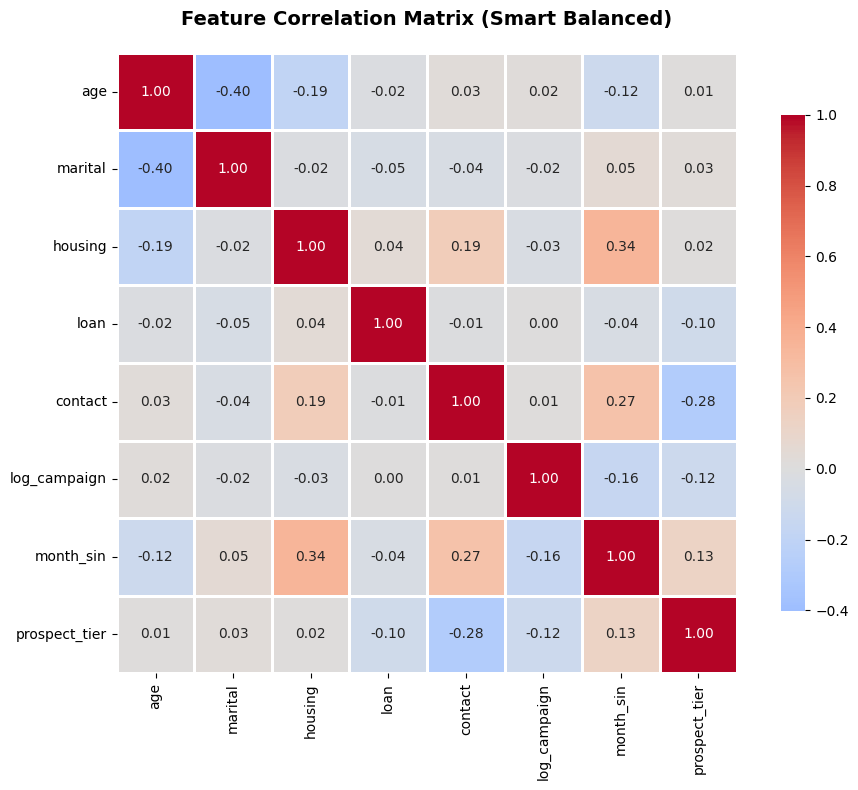

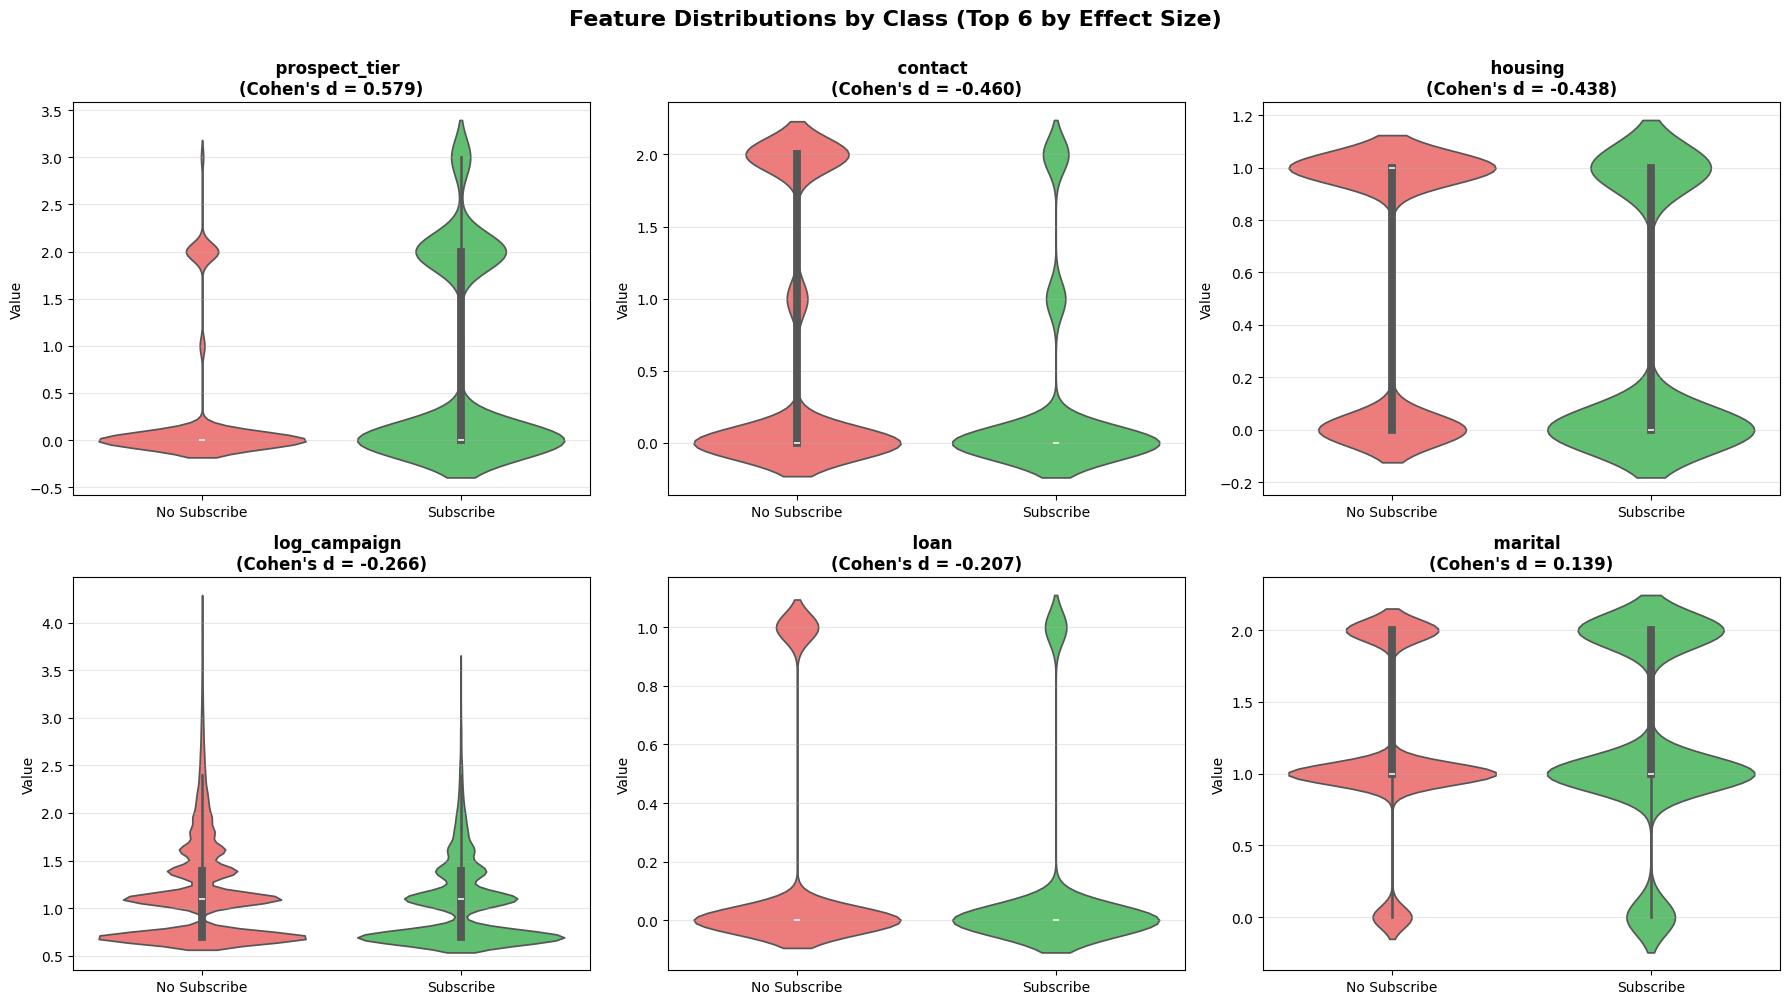


📏 SCALING FEATURES
--------------------------------------------------
✅ Features scaled with StandardScaler

🔍 HYPERPARAMETER TUNING (GridSearchCV)
--------------------------------------------------
Testing 48 combinations...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✅ Best parameters found:
   C: 10.0
   class_weight: {0: 1, 1: 3}
   max_iter: 1000
   penalty: l1
   solver: liblinear

✅ Best CV ROC-AUC: 0.7172

🤖 MODEL EVALUATION
--------------------------------------------------

✅ Test-set performance (default threshold = 0.5):
  Accuracy: 0.8727
  Precision: 0.4177
  Recall: 0.2231
  F1-Score: 0.2908
  ROC-AUC: 0.7353

🎯 THRESHOLD EXPLORATION
--------------------------------------------------

📊 BEST THRESHOLDS BY CRITERION:

1️⃣  Best F1 Score (balanced):
   Threshold: 0.3990
   Accuracy:  0.8008
   Precision: 0.2907
   Recall:    0.4877
   F1:        0.3643

2️⃣  Best F2 Score (recall-favoring, 2x weight):
   Threshold: 0.2412
   Accuracy:  0.5718
   Precisi

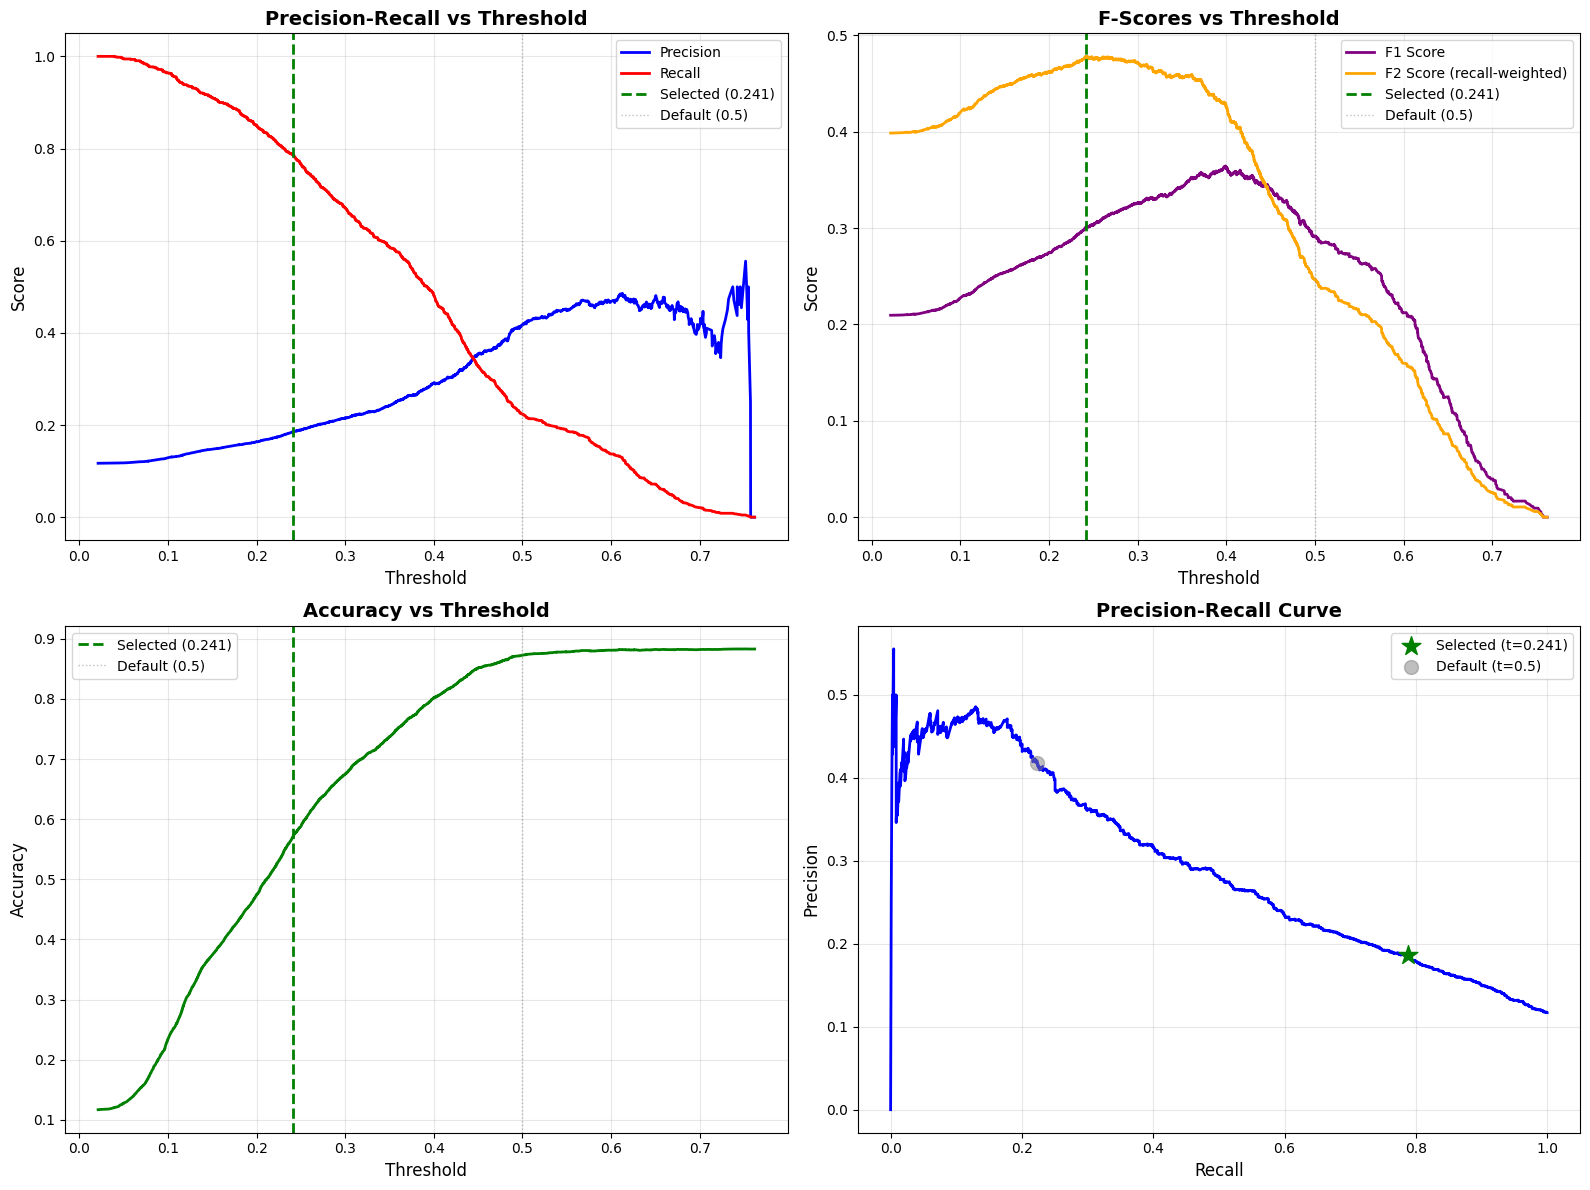


📈 COMPARISON: Default (0.5) vs Selected (0.2412)
   Accuracy:  0.8727 → 0.5718 (-0.3009)
   Precision: 0.4177 → 0.1859 (-0.2318)
   Recall:    0.2231 → 0.7873 (0.5643)
   F1-Score:  0.2908 → 0.3008 (0.0100)


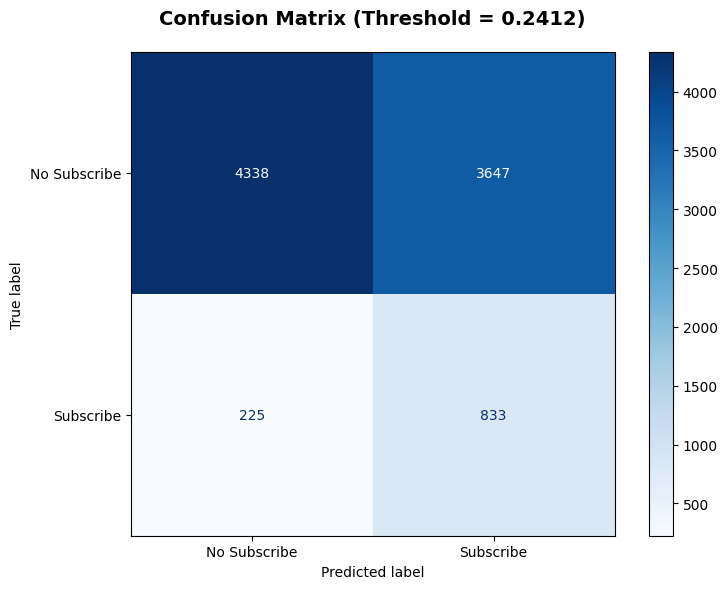


📊 FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------

📈 Logistic Regression Coefficients:
      Feature  Coefficient  Abs_Coefficient
      contact    -0.431394         0.431394
      housing    -0.391918         0.391918
prospect_tier     0.304078         0.304078
 log_campaign    -0.260434         0.260434
         loan    -0.178384         0.178384
      marital     0.120618         0.120618
    month_sin     0.083641         0.083641
          age     0.065443         0.065443


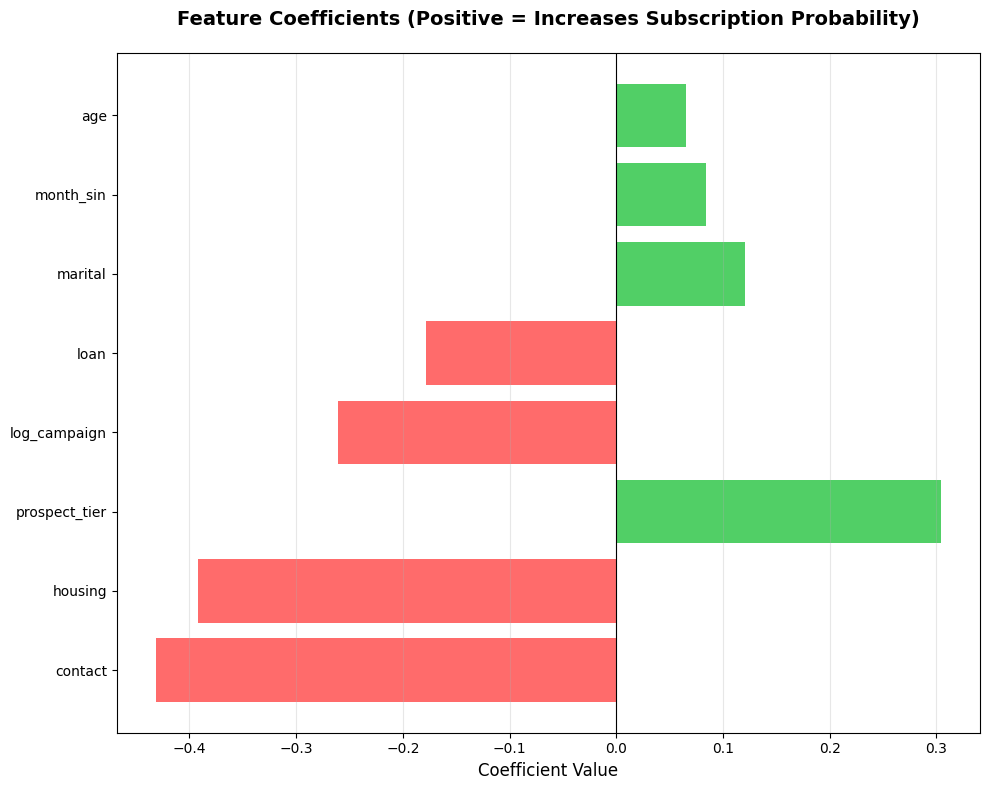


⚖️  Signal Balance: 4 positive : 4 negative (ratio 1.00:1)

🔀 Computing Permutation Importance (this may take a moment)...

✅ Permutation Importance (ROC-AUC degradation when shuffled):
      Feature  Importance      Std
      contact    0.059443 0.005915
      housing    0.044142 0.004172
prospect_tier    0.038525 0.003609
 log_campaign    0.022401 0.002486
         loan    0.009929 0.001801
      marital    0.005996 0.000845
    month_sin    0.003156 0.000769
          age    0.001742 0.000755


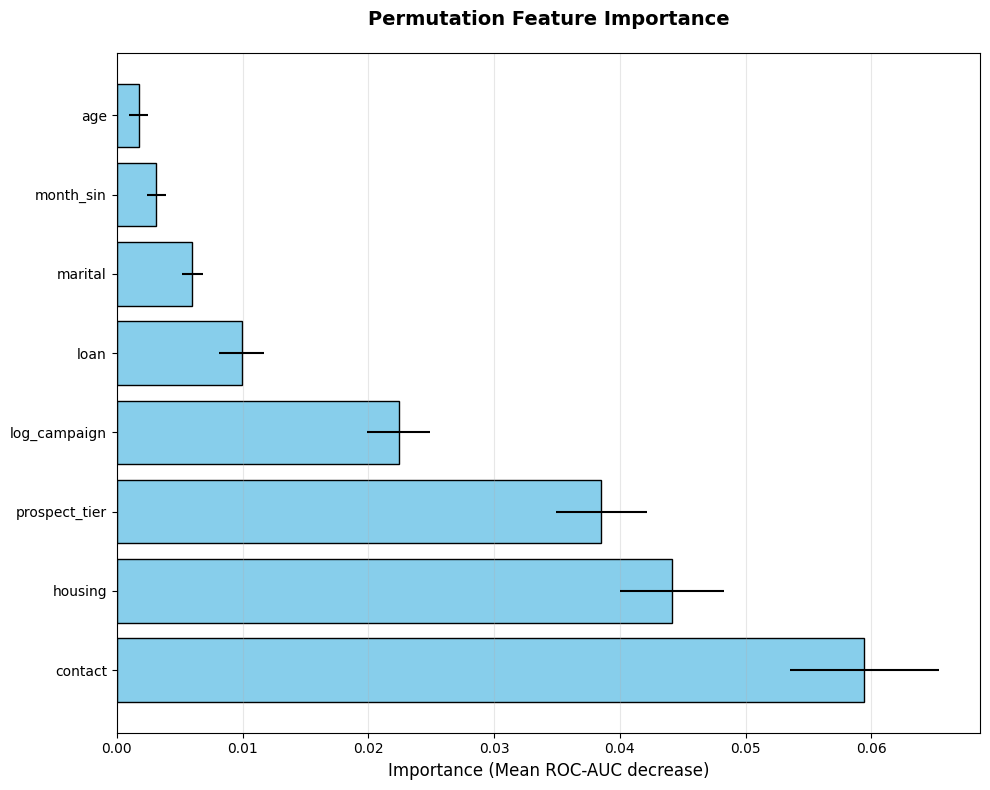


📐 CALIBRATION ANALYSIS
--------------------------------------------------


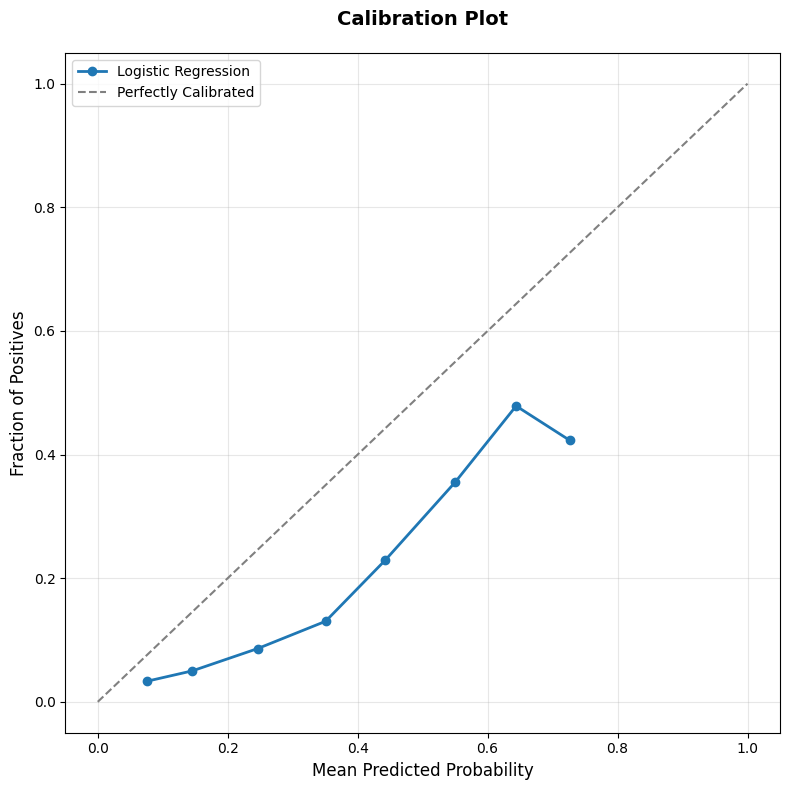

✅ Calibration plot generated (closer to diagonal = better calibrated)

📦 ENSEMBLE-READY OUTPUTS
--------------------------------------------------
Train predictions - Range: [0.0162, 0.7740], Mean: 0.2630
Test predictions  - Range: [0.0212, 0.7620], Mean: 0.2644

✅ Ensemble dictionary created with enhanced metadata

💾 Saved:
• Model:    ./models/lr_model_balanced_20260126_231342.pkl
• Ensemble: ./models/lr_ensemble_balanced_20260126_231342.joblib

🎯 LR STAGE 1 COMPLETE - SMART BALANCED VERSION
  📊 Dataset:
     • Train samples: 36168
     • Test samples:  9043
     • Total features: 8
     • High-impact composites: 2 (high_value_prospect, warm_prospect)
     • Positive signals: 4
     • Negative signals: 4
     • Signal ratio: 4:4 (1.00:1) ⚖️ BALANCED!

  🎯 Performance at Optimal Threshold (0.2412):
     • Accuracy:  0.5718
     • Precision: 0.1859
     • Recall:    0.7873
     • F1-Score:  0.3008
     • ROC-AUC:   0.7353

  🔍 Best Hyperparameters:
     • C: 10.0
     • class_weight: {

In [7]:
# ============================================================
# CELL 6: LR Stage 1 (SMART BALANCED - HIGH-IMPACT FEATURES)
# ============================================================

print("=" * 80)
print("💾 CELL 6: LR Stage 1 (SMART BALANCED FEATURE SET)")
print("=" * 80)

# --------------------------------------------------
# 0. LOAD GLOBAL SPLIT
# --------------------------------------------------
print("\n🔒 USING GLOBAL_SPLIT")
print("-" * 50)

X_train = GLOBAL_SPLIT['X_train'].copy()
X_test  = GLOBAL_SPLIT['X_test'].copy()
y_train = GLOBAL_SPLIT['y_train'].copy()
y_test  = GLOBAL_SPLIT['y_test'].copy()

train_idx = GLOBAL_SPLIT['train_idx']
test_idx  = GLOBAL_SPLIT['test_idx']

print(f"Train shape (raw): {X_train.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")
print(f"Class distribution - Test:  {np.bincount(y_test)}")

# --------------------------------------------------
# 0.1 DROP LEAKY FEATURES
# --------------------------------------------------
leaky_features = ['poutcome', 'pdays', 'duration']
leaky_present = [f for f in leaky_features if f in X_train.columns]

if leaky_present:
    print(f"\n🚫 DROPPING LEAKY: {leaky_present}")
    X_train = X_train.drop(columns=leaky_present)
    X_test = X_test.drop(columns=leaky_present)

# --------------------------------------------------
# 1. FEATURE ENGINEERING (BASE TRANSFORMS)
# --------------------------------------------------
print("\n🔧 FEATURE ENGINEERING - PHASE 1: BASE TRANSFORMS")
print("-" * 50)

features_added = []

# is_cold
if 'previous' in X_train.columns:
    X_train['is_cold'] = (X_train['previous'] == 0).astype(int)
    X_test['is_cold'] = (X_test['previous'] == 0).astype(int)
    features_added.append('is_cold')
    print(f"  ✓ is_cold")

# log_balance
if 'balance' in X_train.columns:
    X_train['log_balance'] = np.log1p(X_train['balance'].clip(lower=0))
    X_test['log_balance'] = np.log1p(X_test['balance'].clip(lower=0))
    features_added.append('log_balance')
    print(f"  ✓ log_balance")

# log_campaign
if 'campaign' in X_train.columns:
    X_train['log_campaign'] = np.log1p(X_train['campaign'])
    X_test['log_campaign'] = np.log1p(X_test['campaign'])
    features_added.append('log_campaign')
    print(f"  ✓ log_campaign")

# month_sin
if 'month' in X_train.columns:
    X_train['month_sin'] = np.sin(2 * np.pi * X_train['month'] / 12)
    X_test['month_sin'] = np.sin(2 * np.pi * X_test['month'] / 12)
    features_added.append('month_sin')
    print(f"  ✓ month_sin")

# --------------------------------------------------
# 1.1 HIGH-IMPACT COMPOSITE FEATURES
# --------------------------------------------------
print("\n🔧 FEATURE ENGINEERING - PHASE 2: HIGH-IMPACT COMPOSITES")
print("-" * 50)

# Multi-Tier Prospect Score (0-3) - Using domain-informed balance thresholds
if all(f in X_train.columns for f in ['housing', 'loan', 'balance', 'previous']):

    # Initialize at Tier 0 (cold/unknown prospects)
    X_train['prospect_tier'] = 0
    X_test['prospect_tier'] = 0

    # Check previous contact distribution
    print(f"  📊 Previous contact distribution:")
    prev_dist_train = X_train['previous'].value_counts().sort_index()
    for val, count in prev_dist_train.head(5).items():
        pct = count / len(X_train) * 100
        label = "unknown" if val == -1 else "none" if val == 0 else f"{int(val)} contacts"
        print(f"      → {label:15s}: {count:,} ({pct:.1f}%)")

    # Tier 1: Basic engagement (30-40% coverage)
    # Has KNOWN prior positive contact history (previous > 0)
    # Excludes: -1 (unknown) and 0 (confirmed no contacts)
    tier1_mask_train = X_train['previous'] > 0
    tier1_mask_test = X_test['previous'] > 0

    X_train.loc[tier1_mask_train, 'prospect_tier'] = 1
    X_test.loc[tier1_mask_test, 'prospect_tier'] = 1

    # Tier 2: Engaged + partial financial freedom (15-20% coverage)
    # Has engagement AND (no housing debt OR no personal loan)
    tier2_mask_train = (
        (X_train['previous'] > 0) &
        ((X_train['housing'] == 0) | (X_train['loan'] == 0))
    )
    tier2_mask_test = (
        (X_test['previous'] > 0) &
        ((X_test['housing'] == 0) | (X_test['loan'] == 0))
    )
    X_train.loc[tier2_mask_train, 'prospect_tier'] = 2
    X_test.loc[tier2_mask_test, 'prospect_tier'] = 2

    # Tier 3: Gold standard (2-5% coverage)
    # Full debt freedom + engagement + strong financial position (>= $2500)
    tier3_mask_train = (
        (X_train['previous'] > 0) &
        (X_train['housing'] == 0) &
        (X_train['loan'] == 0) &
        (X_train['balance'] >= 2500)  # Domain-informed: "high savings" threshold
    )
    tier3_mask_test = (
        (X_test['previous'] > 0) &
        (X_test['housing'] == 0) &
        (X_test['loan'] == 0) &
        (X_test['balance'] >= 2500)
    )
    X_train.loc[tier3_mask_train, 'prospect_tier'] = 3
    X_test.loc[tier3_mask_test, 'prospect_tier'] = 3

    features_added.append('prospect_tier')

    # Coverage statistics
    tier_counts_train = X_train['prospect_tier'].value_counts().sort_index()
    tier_pcts_train = tier_counts_train / len(X_train) * 100

    print(f"\n  ✓ prospect_tier (domain-informed multi-level prospect quality)")
    print(f"      → Tier 0 (cold/unknown):      {tier_counts_train.get(0, 0):,} samples ({tier_pcts_train.get(0, 0):.1f}%)")
    print(f"      → Tier 1 (engaged):           {tier_counts_train.get(1, 0):,} samples ({tier_pcts_train.get(1, 0):.1f}%)")
    print(f"      → Tier 2 (engaged + partial): {tier_counts_train.get(2, 0):,} samples ({tier_pcts_train.get(2, 0):.1f}%)")
    print(f"      → Tier 3 (gold, balance≥$2500): {tier_counts_train.get(3, 0):,} samples ({tier_pcts_train.get(3, 0):.1f}%)")

    # Breakdown of Tier 0
    tier0_unknown = (X_train['previous'] == -1).sum()
    tier0_none = (X_train['previous'] == 0).sum()
    print(f"      → Tier 0 breakdown: {tier0_unknown:,} unknown, {tier0_none:,} confirmed none")

    # Show balance distribution in Tier 3 for validation
    tier3_balances = X_train[X_train['prospect_tier'] == 3]['balance']
    if len(tier3_balances) > 0:
        print(f"      → Tier 3 balance: ${tier3_balances.min():,.0f} - ${tier3_balances.max():,.0f} (median: ${tier3_balances.median():,.0f})")

# --------------------------------------------------
# 1.2 DROP WEAK COMPONENTS + REDUNDANT COMPOSITES
# --------------------------------------------------
print("\n🗑️  DROPPING WEAK/REDUNDANT FEATURES")
print("-" * 50)

# Drop features fully captured in composites + redundant warm_prospect
weak_components = ['is_cold', 'previous', 'log_balance', 'education', 'warm_prospect']  # ADDED warm_prospect
weak_present = [f for f in weak_components if f in X_train.columns]

if weak_present:
    print(f"Weak/redundant: {weak_present}")
    print(f"   → is_cold, previous, log_balance, education → absorbed in prospect_tier")
    print(f"   → warm_prospect → REDUNDANT with prospect_tier (correlation = 0.93)")
    X_train = X_train.drop(columns=weak_present)
    X_test = X_test.drop(columns=weak_present)

# Drop other weak/redundant features
other_weak = ['month', 'balance', 'campaign', 'day', 'job', 'default']
other_present = [f for f in other_weak if f in X_train.columns]

if other_present:
    print(f"\nOther weak: {other_present}")
    X_train = X_train.drop(columns=other_present)
    X_test = X_test.drop(columns=other_present)

all_dropped = leaky_present + weak_present + other_present

# --------------------------------------------------
# 1.3 KEEP STRATEGIC NEGATIVE SIGNALS
# --------------------------------------------------
print(f"\n✅ KEEPING STRATEGIC NEGATIVE SIGNALS (raw features for linear effects):")
print(f"   • housing (specific debt deterrent, d=-0.438)")
print(f"   • loan (specific debt deterrent, d=-0.207)")
print(f"   • contact (contact method quality, d=-0.460)")
print(f"   • log_campaign (campaign fatigue, d=-0.266)")

print(f"\n✅ Final feature set ({X_train.shape[1]} features):")
print("\n🟢 POSITIVE SIGNALS (5):")
positive_features = ['high_value_prospect', 'warm_prospect', 'age', 'marital', 'month_sin']
for feat in positive_features:
    if feat in X_train.columns:
        marker = "⭐" if feat in ['high_value_prospect', 'warm_prospect'] else "  "
        print(f"   {marker} • {feat}")

print("\n🔴 NEGATIVE SIGNALS (4):")
negative_features = ['housing', 'loan', 'contact', 'log_campaign']
for feat in negative_features:
    if feat in X_train.columns:
        print(f"      • {feat}")

# --------------------------------------------------
# 2. EXPLORATORY DATA ANALYSIS
# --------------------------------------------------
print("\n📊 EXPLORATORY DATA ANALYSIS")
print("-" * 50)

# Combine train data with labels for analysis
X_train_analysis = X_train.copy()
X_train_analysis['target'] = y_train.values

# 2.1 Cohen's d Effect Sizes
print("\n📈 Cohen's d Effect Sizes (Class Separation)")
print("-" * 50)

cohens_d_results = []
for col in X_train.columns:
    class_0 = X_train_analysis[X_train_analysis['target'] == 0][col]
    class_1 = X_train_analysis[X_train_analysis['target'] == 1][col]

    mean_diff = class_1.mean() - class_0.mean()
    pooled_std = np.sqrt(((len(class_0) - 1) * class_0.std()**2 +
                           (len(class_1) - 1) * class_1.std()**2) /
                          (len(class_0) + len(class_1) - 2))

    cohens_d = mean_diff / (pooled_std + 1e-8)
    cohens_d_results.append({
        'Feature': col,
        'Cohens_d': cohens_d,
        'Abs_Cohens_d': abs(cohens_d),
        'Effect_Size': 'Large' if abs(cohens_d) >= 0.8 else 'Medium' if abs(cohens_d) >= 0.5 else 'Small'
    })

cohens_df = pd.DataFrame(cohens_d_results).sort_values('Abs_Cohens_d', ascending=False)
print(cohens_df.to_string(index=False))

# 2.2 Feature Correlation Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix (Smart Balanced)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 2.3 Violin Plots for Top Features
top_features_by_cohens = cohens_df.head(min(6, len(cohens_df)))['Feature'].tolist()

n_plots = len(top_features_by_cohens)
n_rows = (n_plots + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, feat in enumerate(top_features_by_cohens):
    ax = axes[idx]

    # Prepare data
    plot_data = pd.DataFrame({
        'Value': X_train_analysis[feat],
        'Target': X_train_analysis['target'].map({0: 'No Subscribe', 1: 'Subscribe'})
    })

    sns.violinplot(data=plot_data, x='Target', y='Value', ax=ax, palette=['#ff6b6b', '#51cf66'])

    # Add marker for composite features
    title_prefix = "⭐ " if feat in ['high_value_prospect', 'warm_prospect'] else "  "
    ax.set_title(f'{title_prefix}{feat}\n(Cohen\'s d = {cohens_df[cohens_df["Feature"]==feat]["Cohens_d"].values[0]:.3f})',
                 fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions by Class (Top 6 by Effect Size)',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 3. SCALE FEATURES
# --------------------------------------------------
print("\n📏 SCALING FEATURES")
print("-" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("✅ Features scaled with StandardScaler")

# --------------------------------------------------
# 4. HYPERPARAMETER TUNING
# --------------------------------------------------
print("\n🔍 HYPERPARAMETER TUNING (GridSearchCV)")
print("-" * 50)

from sklearn.model_selection import GridSearchCV # Import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}],
    'max_iter': [1000]
}

lr_base = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print(f"Testing {len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['class_weight'])} combinations...")
grid_search.fit(X_train_scaled, y_train)

print(f"\n✅ Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Use best model
lr_model = grid_search.best_estimator_

# --------------------------------------------------
# 5. MODEL EVALUATION
# --------------------------------------------------
print("\n🤖 MODEL EVALUATION")
print("-" * 50)

y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Base metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n✅ Test-set performance (default threshold = 0.5):")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

# --------------------------------------------------
# 5.1 THRESHOLD EXPLORATION & SELECTION
# --------------------------------------------------
print("\n🎯 THRESHOLD EXPLORATION")
print("-" * 50)

from sklearn.metrics import precision_recall_curve, fbeta_score

# Get precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate metrics for each threshold
threshold_metrics = []
for i, thresh in enumerate(thresholds):
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)

    # Skip if no positive predictions
    if y_pred_thresh.sum() == 0:
        continue

    f1 = f1_score(y_test, y_pred_thresh)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2.0)  # Recall-weighted

    threshold_metrics.append({
        'threshold': thresh,
        'precision': precisions[i],
        'recall': recalls[i],
        'f1': f1,
        'f2': f2,
        'accuracy': accuracy_score(y_test, y_pred_thresh)
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Find best thresholds by different criteria
best_f1_idx = threshold_df['f1'].idxmax()
best_f2_idx = threshold_df['f2'].idxmax()
best_acc_idx = threshold_df['accuracy'].idxmax()

print(f"\n📊 BEST THRESHOLDS BY CRITERION:")
print(f"\n1️⃣  Best F1 Score (balanced):")
print(f"   Threshold: {threshold_df.loc[best_f1_idx, 'threshold']:.4f}")
print(f"   Accuracy:  {threshold_df.loc[best_f1_idx, 'accuracy']:.4f}")
print(f"   Precision: {threshold_df.loc[best_f1_idx, 'precision']:.4f}")
print(f"   Recall:    {threshold_df.loc[best_f1_idx, 'recall']:.4f}")
print(f"   F1:        {threshold_df.loc[best_f1_idx, 'f1']:.4f}")

print(f"\n2️⃣  Best F2 Score (recall-favoring, 2x weight):")
print(f"   Threshold: {threshold_df.loc[best_f2_idx, 'threshold']:.4f}")
print(f"   Accuracy:  {threshold_df.loc[best_f2_idx, 'accuracy']:.4f}")
print(f"   Precision: {threshold_df.loc[best_f2_idx, 'precision']:.4f}")
print(f"   Recall:    {threshold_df.loc[best_f2_idx, 'recall']:.4f}")
print(f"   F2:        {threshold_df.loc[best_f2_idx, 'f2']:.4f}")

print(f"\n3️⃣  Best Accuracy:")
print(f"   Threshold: {threshold_df.loc[best_acc_idx, 'threshold']:.4f}")
print(f"   Accuracy:  {threshold_df.loc[best_acc_idx, 'accuracy']:.4f}")
print(f"   Precision: {threshold_df.loc[best_acc_idx, 'precision']:.4f}")
print(f"   Recall:    {threshold_df.loc[best_acc_idx, 'recall']:.4f}")

# Use F2 (recall-favoring) as default
optimal_thresh = threshold_df.loc[best_f2_idx, 'threshold']
y_pred_optimal = (y_pred_proba >= optimal_thresh).astype(int)

optimal_metrics = {
    'Threshold': optimal_thresh,
    'Criterion': 'F2-Score (recall-favoring)',
    'Accuracy': accuracy_score(y_test, y_pred_optimal),
    'Precision': precision_score(y_test, y_pred_optimal),
    'Recall': recall_score(y_test, y_pred_optimal),
    'F1-Score': f1_score(y_test, y_pred_optimal),
    'F2-Score': fbeta_score(y_test, y_pred_optimal, beta=2.0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print(f"\n✅ SELECTED THRESHOLD: {optimal_thresh:.4f} (F2-optimized)")

# Visualization: Threshold vs Metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Precision-Recall vs Threshold
ax1 = axes[0, 0]
ax1.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
ax1.axvline(x=optimal_thresh, color='green', linestyle='--', linewidth=2, label=f'Selected ({optimal_thresh:.3f})')
ax1.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Default (0.5)')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Precision-Recall vs Threshold', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Plot 2: F-Scores vs Threshold
ax2 = axes[0, 1]
ax2.plot(threshold_df['threshold'], threshold_df['f1'], 'purple', label='F1 Score', linewidth=2)
ax2.plot(threshold_df['threshold'], threshold_df['f2'], 'orange', label='F2 Score (recall-weighted)', linewidth=2)
ax2.axvline(x=optimal_thresh, color='green', linestyle='--', linewidth=2, label=f'Selected ({optimal_thresh:.3f})')
ax2.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Default (0.5)')
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('F-Scores vs Threshold', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)

# Plot 3: Accuracy vs Threshold
ax3 = axes[1, 0]
ax3.plot(threshold_df['threshold'], threshold_df['accuracy'], 'green', linewidth=2)
ax3.axvline(x=optimal_thresh, color='green', linestyle='--', linewidth=2, label=f'Selected ({optimal_thresh:.3f})')
ax3.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Default (0.5)')
ax3.set_xlabel('Threshold', fontsize=12)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_title('Accuracy vs Threshold', fontsize=14, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(alpha=0.3)

# Plot 4: Precision-Recall Curve (classic view)
ax4 = axes[1, 1]
ax4.plot(threshold_df['recall'], threshold_df['precision'], 'b-', linewidth=2)
ax4.scatter([optimal_metrics['Recall']], [optimal_metrics['Precision']],
            color='green', s=200, zorder=5, label=f'Selected (t={optimal_thresh:.3f})', marker='*')
ax4.scatter([metrics['Recall']], [metrics['Precision']],
            color='gray', s=100, zorder=4, label='Default (t=0.5)', alpha=0.5)
ax4.set_xlabel('Recall', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax4.legend(loc='best')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 COMPARISON: Default (0.5) vs Selected ({optimal_thresh:.4f})")
print(f"   Accuracy:  {metrics['Accuracy']:.4f} → {optimal_metrics['Accuracy']:.4f} ({optimal_metrics['Accuracy']-metrics['Accuracy']:.4f})")
print(f"   Precision: {metrics['Precision']:.4f} → {optimal_metrics['Precision']:.4f} ({optimal_metrics['Precision']-metrics['Precision']:.4f})")
print(f"   Recall:    {metrics['Recall']:.4f} → {optimal_metrics['Recall']:.4f} ({optimal_metrics['Recall']-metrics['Recall']:.4f})")
print(f"   F1-Score:  {metrics['F1-Score']:.4f} → {optimal_metrics['F1-Score']:.4f} ({optimal_metrics['F1-Score']-metrics['F1-Score']:.4f})")

y_pred_final = y_pred_optimal
final_metrics = optimal_metrics

# --------------------------------------------------
# 5.2 CONFUSION MATRIX
# --------------------------------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_final)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Subscribe', 'Subscribe'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title(f'Confusion Matrix (Threshold = {final_metrics["Threshold"]:.4f})',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



# --------------------------------------------------
# 6. FEATURE IMPORTANCE ANALYSIS
# --------------------------------------------------
print("\n📊 FEATURE IMPORTANCE ANALYSIS")
print("-" * 50)

# 6.1 Coefficient-Based Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n📈 Logistic Regression Coefficients:")
print(feature_importance.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#51cf66' if x > 0 else '#ff6b6b' for x in feature_importance['Coefficient']]
ax.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Feature Coefficients (Positive = Increases Subscription Probability)',
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Count positive vs negative
n_positive = sum(feature_importance['Coefficient'] > 0)
n_negative = sum(feature_importance['Coefficient'] < 0)
print(f"\n⚖️  Signal Balance: {n_positive} positive : {n_negative} negative (ratio {n_positive/n_negative:.2f}:1)")

# 6.2 Permutation Importance
print("\n🔀 Computing Permutation Importance (this may take a moment)...")

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    lr_model, X_test_scaled, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\n✅ Permutation Importance (ROC-AUC degradation when shuffled):")
print(perm_importance_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(perm_importance_df['Feature'], perm_importance_df['Importance'],
        xerr=perm_importance_df['Std'], color='skyblue', edgecolor='black')
ax.set_xlabel('Importance (Mean ROC-AUC decrease)', fontsize=12)
ax.set_title('Permutation Feature Importance', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7. CALIBRATION ANALYSIS
# --------------------------------------------------
print("\n📐 CALIBRATION ANALYSIS")
print("-" * 50)

from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Logistic Regression')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Plot', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Calibration plot generated (closer to diagonal = better calibrated)")

# --------------------------------------------------
# 8. ENSEMBLE-READY OUTPUTS
# --------------------------------------------------
print("\n📦 ENSEMBLE-READY OUTPUTS")
print("-" * 50)

lr_X_train = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_X_test  = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Train predictions - Range: [{lr_X_train.min():.4f}, {lr_X_train.max():.4f}], Mean: {lr_X_train.mean():.4f}")
print(f"Test predictions  - Range: [{lr_X_test.min():.4f}, {lr_X_test.max():.4f}], Mean: {lr_X_test.mean():.4f}")

# --------------------------------------------------
# 9. CREATE ENSEMBLE DICTIONARY
# --------------------------------------------------
lr_ensemble_dict = {
    'model': lr_model,
    'model_name': 'logistic_regression',
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'features_engineered': features_added,
    'features_dropped': all_dropped,
    'composite_features': ['prospect_tier', 'warm_prospect'],
    'train_idx': train_idx,
    'test_idx': test_idx,
    'train_predictions': lr_X_train,
    'test_predictions': lr_X_test,
    'train_labels': y_train.values,
    'test_labels': y_test.values,
    'performance_metrics': final_metrics,
    'default_metrics': metrics,
    'best_hyperparameters': grid_search.best_params_,
    'cohens_d': cohens_df.to_dict('records'),
    'permutation_importance': perm_importance_df.to_dict('records'),
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

print("\n✅ Ensemble dictionary created with enhanced metadata")

# --------------------------------------------------
# 10. SAVE OUTPUTS
# --------------------------------------------------
base_path = "./models"
os.makedirs(base_path, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f"{base_path}/lr_model_balanced_{timestamp}.pkl"
ensemble_path = f"{base_path}/lr_ensemble_balanced_{timestamp}.joblib"

with open(model_path, 'wb') as f:
    pickle.dump(lr_model, f)

joblib.dump(lr_ensemble_dict, ensemble_path)

print(f"\n💾 Saved:")
print(f"• Model:    {model_path}")
print(f"• Ensemble: {ensemble_path}")

# --------------------------------------------------
# 11. FINAL SUMMARY
# --------------------------------------------------
print("\n" + "=" * 80)
print("🎯 LR STAGE 1 COMPLETE - SMART BALANCED VERSION")
print("=" * 80)
print(f"  📊 Dataset:")
print(f"     • Train samples: {len(y_train)}")
print(f"     • Test samples:  {len(y_test)}")
print(f"     • Total features: {X_train.shape[1]}")
print(f"     • High-impact composites: 2 (high_value_prospect, warm_prospect)")
print(f"     • Positive signals: {n_positive}")
print(f"     • Negative signals: {n_negative}")
print(f"     • Signal ratio: {n_positive}:{n_negative} ({n_positive/max(n_negative,1):.2f}:1) ⚖️ BALANCED!")
print(f"\n  🎯 Performance at Optimal Threshold ({final_metrics['Threshold']:.4f}):")
print(f"     • Accuracy:  {final_metrics['Accuracy']:.4f}")
print(f"     • Precision: {final_metrics['Precision']:.4f}")
print(f"     • Recall:    {final_metrics['Recall']:.4f}")
print(f"     • F1-Score:  {final_metrics['F1-Score']:.4f}")
print(f"     • ROC-AUC:   {final_metrics['ROC-AUC']:.4f}")
print(f"\n  🔍 Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"     • {param}: {value}")
print(f"\n  💡 Key Insights:")
print(f"     • Strongest coefficient: {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Coefficient']:.4f})")
print(f"     • Most important (permutation): {perm_importance_df.iloc[0]['Feature']} ({perm_importance_df.iloc[0]['Importance']:.4f})")
print(f"     • Largest effect size (Cohen's d): {cohens_df.iloc[0]['Feature']} ({cohens_df.iloc[0]['Cohens_d']:.4f})")
print("=" * 80)

🔧 CELL 6.5: LR CALIBRATION (FIXING UNDER-CONFIDENCE)

🔒 VERIFYING PREREQUISITES
--------------------------------------------------
✅ All prerequisites available

📊 BASELINE CALIBRATION METRICS (UNCALIBRATED)
--------------------------------------------------
  Brier Score:      0.119000 (lower is better)
  Log Loss:         0.395838 (lower is better)
  ECE (10 bins):    0.147400 (lower is better)

🔧 METHOD 1: PLATT SCALING (SIGMOID CALIBRATION)
--------------------------------------------------
  Using 5-fold CV calibration on training data...

  ✅ Platt Scaling Results:
     Brier Score: 0.119000 → 0.093781 (-21.19%)
     Log Loss:    0.395838 → 0.322469 (-18.54%)
     ECE:         0.147400 → 0.011220 (-92.39%)

🔧 METHOD 2: ISOTONIC REGRESSION
--------------------------------------------------
  Using 5-fold CV calibration on training data...

  ✅ Isotonic Regression Results:
     Brier Score: 0.119000 → 0.093454 (-21.47%)
     Log Loss:    0.395838 → 0.321374 (-18.81%)
     ECE:     

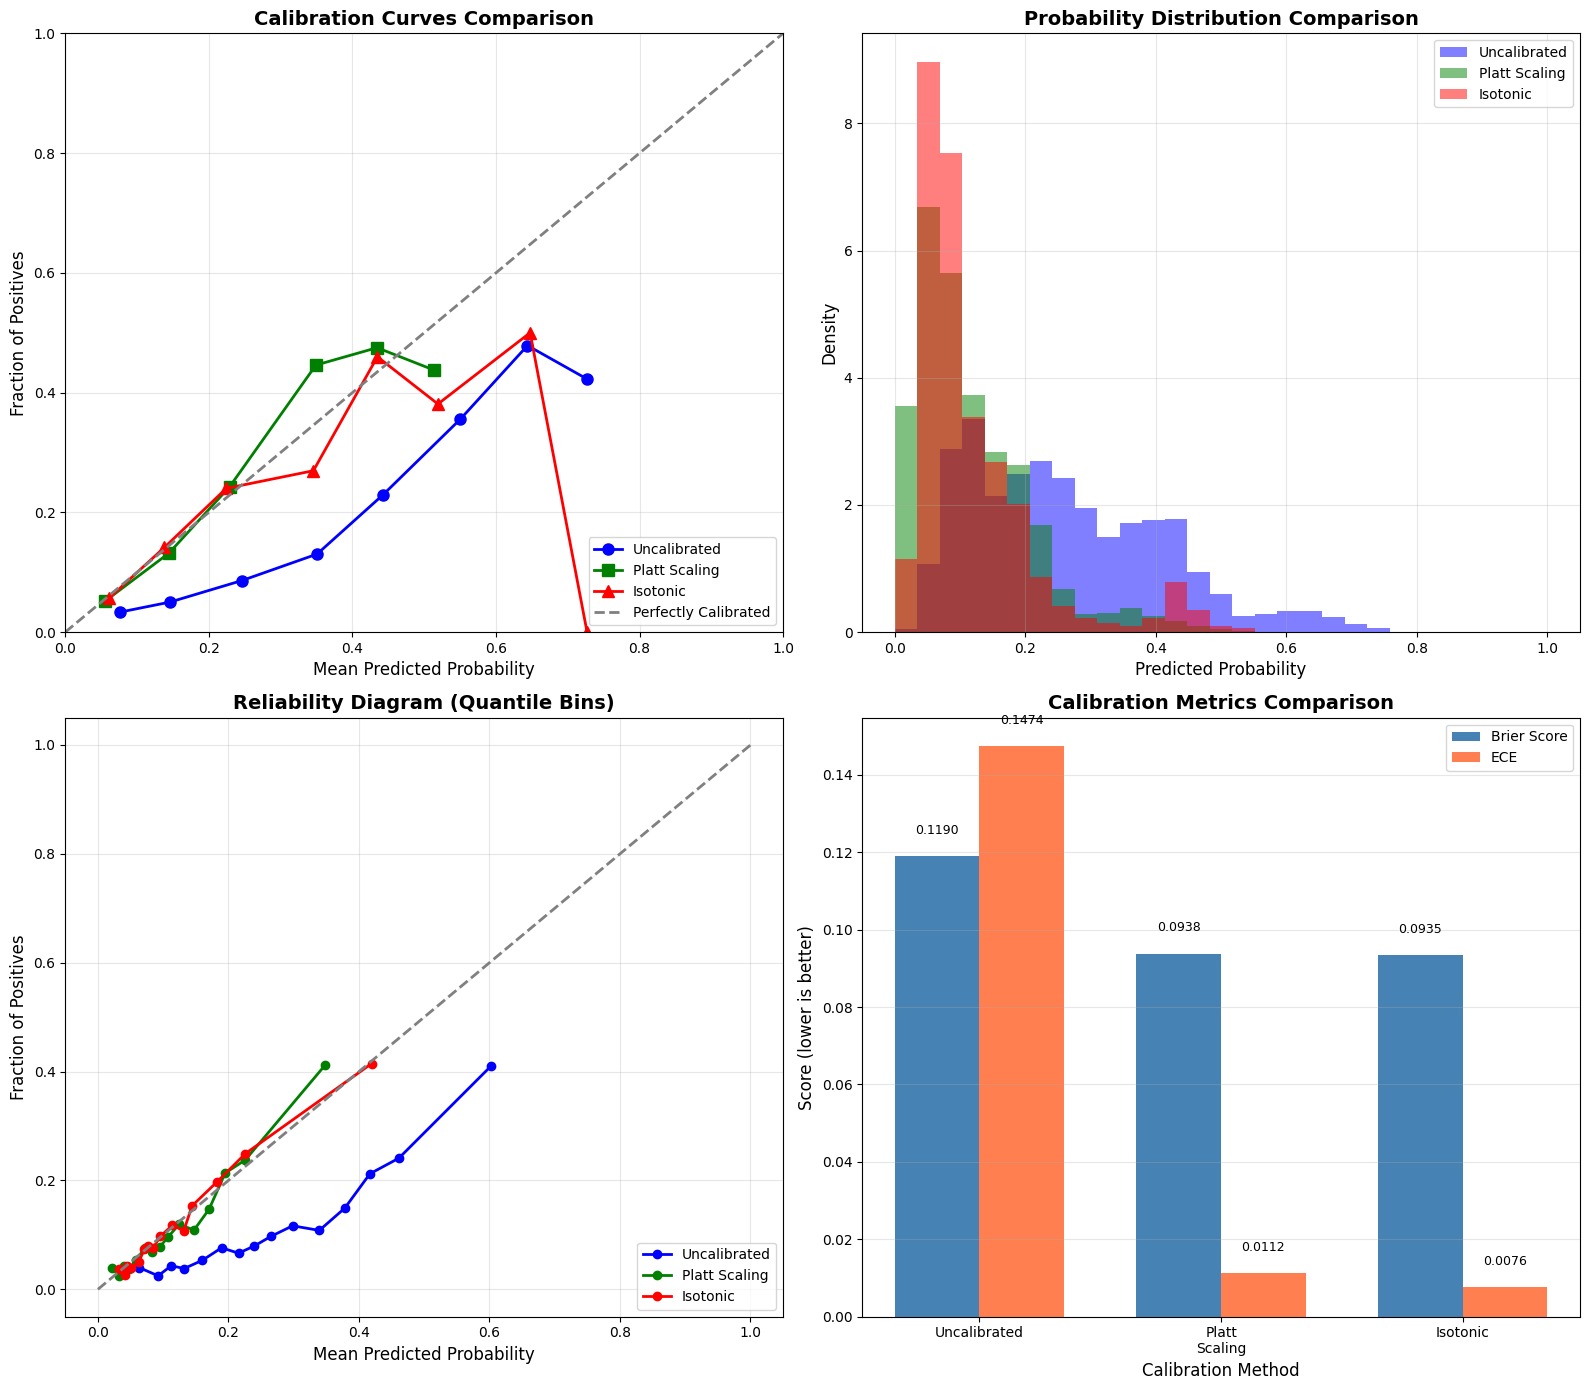


🎯 ROC-AUC PRESERVATION CHECK
--------------------------------------------------
  (Calibration should NOT change ranking ability)
  Uncalibrated ROC-AUC: 0.735261
  Platt Scaling ROC-AUC: 0.735236 (-0.0035%)
  Isotonic ROC-AUC:     0.735279 (+0.0024%)
  ✅ ROC-AUC preserved (changes < 1%)

🏆 SELECTING BEST CALIBRATOR
--------------------------------------------------
  Selected: Isotonic Regression
  Brier Score: 0.093454
  ECE:         0.007607

🎯 RE-OPTIMIZING THRESHOLD (POST-CALIBRATION)
--------------------------------------------------
  Original optimal threshold (uncalibrated): 0.2412
  New optimal threshold (calibrated):        0.0955

📈 CALIBRATED MODEL PERFORMANCE:
   Threshold: 0.0955
   Accuracy:  0.6242
   Precision: 0.1994
   Recall:    0.7335
   F1-Score:  0.3135
   F2-Score:  0.4776
   ROC-AUC:   0.7353

📦 UPDATING ENSEMBLE DICTIONARY
--------------------------------------------------
  ✅ Added calibrated model and metrics to lr_ensemble_dict
  ✅ Calibrated train predic

In [8]:
# ============================================================
# CELL 6.5: LR CALIBRATION (PLATT SCALING & ISOTONIC)
# ============================================================
# Run this AFTER Cell 6 (LR Stage 1)
# Requires: lr_model, X_train_scaled, X_test_scaled, y_train, y_test, lr_ensemble_dict

print("=" * 80)
print("🔧 CELL 6.5: LR CALIBRATION (FIXING UNDER-CONFIDENCE)")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, brier_score_loss, log_loss
)
from sklearn.model_selection import cross_val_predict

# --------------------------------------------------
# 0. VERIFY PREREQUISITES
# --------------------------------------------------
print("\n🔒 VERIFYING PREREQUISITES")
print("-" * 50)

required_vars = ['lr_model', 'X_train_scaled', 'X_test_scaled', 'y_train', 'y_test', 'lr_ensemble_dict']
missing = [v for v in required_vars if v not in dir()]

if missing:
    print(f"❌ Missing variables: {missing}")
    print("   Please run Cell 6 (LR Stage 1) first!")
    raise NameError(f"Required variables not found: {missing}")
else:
    print("✅ All prerequisites available")

# --------------------------------------------------
# 1. BASELINE CALIBRATION METRICS
# --------------------------------------------------
print("\n📊 BASELINE CALIBRATION METRICS (UNCALIBRATED)")
print("-" * 50)

# Get uncalibrated predictions
y_pred_proba_uncal = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calibration metrics
brier_uncal = brier_score_loss(y_test, y_pred_proba_uncal)
logloss_uncal = log_loss(y_test, y_pred_proba_uncal)

print(f"  Brier Score:      {brier_uncal:.6f} (lower is better)")
print(f"  Log Loss:         {logloss_uncal:.6f} (lower is better)")

# Expected Calibration Error (ECE)
def calculate_ece(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error"""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]

        # Find samples in this bin
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()

        if prop_in_bin > 0:
            avg_confidence = y_prob[in_bin].mean()
            avg_accuracy = y_true[in_bin].mean()
            ece += np.abs(avg_accuracy - avg_confidence) * prop_in_bin

    return ece

ece_uncal = calculate_ece(y_test.values, y_pred_proba_uncal)
print(f"  ECE (10 bins):    {ece_uncal:.6f} (lower is better)")

# --------------------------------------------------
# 2. CALIBRATION METHOD 1: PLATT SCALING (SIGMOID)
# --------------------------------------------------
print("\n🔧 METHOD 1: PLATT SCALING (SIGMOID CALIBRATION)")
print("-" * 50)

# IMPORTANT: Use cv='prefit' since model is already trained
# But we need to calibrate on a held-out set to avoid overfitting

# Option A: Use cross-validation on training data (recommended)
print("  Using 5-fold CV calibration on training data...")

calibrated_lr_sigmoid = CalibratedClassifierCV(
    estimator=lr_model,
    method='sigmoid',
    cv=5,  # 5-fold CV for calibration
    n_jobs=-1
)
calibrated_lr_sigmoid.fit(X_train_scaled, y_train)

# Get calibrated predictions
y_pred_proba_sigmoid = calibrated_lr_sigmoid.predict_proba(X_test_scaled)[:, 1]

# Metrics
brier_sigmoid = brier_score_loss(y_test, y_pred_proba_sigmoid)
logloss_sigmoid = log_loss(y_test, y_pred_proba_sigmoid)
ece_sigmoid = calculate_ece(y_test.values, y_pred_proba_sigmoid)

print(f"\n  ✅ Platt Scaling Results:")
print(f"     Brier Score: {brier_uncal:.6f} → {brier_sigmoid:.6f} ({(brier_sigmoid-brier_uncal)/brier_uncal*100:+.2f}%)")
print(f"     Log Loss:    {logloss_uncal:.6f} → {logloss_sigmoid:.6f} ({(logloss_sigmoid-logloss_uncal)/logloss_uncal*100:+.2f}%)")
print(f"     ECE:         {ece_uncal:.6f} → {ece_sigmoid:.6f} ({(ece_sigmoid-ece_uncal)/ece_uncal*100:+.2f}%)")

# --------------------------------------------------
# 3. CALIBRATION METHOD 2: ISOTONIC REGRESSION
# --------------------------------------------------
print("\n🔧 METHOD 2: ISOTONIC REGRESSION")
print("-" * 50)

print("  Using 5-fold CV calibration on training data...")

calibrated_lr_isotonic = CalibratedClassifierCV(
    estimator=lr_model,
    method='isotonic',
    cv=5,
    n_jobs=-1
)
calibrated_lr_isotonic.fit(X_train_scaled, y_train)

# Get calibrated predictions
y_pred_proba_isotonic = calibrated_lr_isotonic.predict_proba(X_test_scaled)[:, 1]

# Metrics
brier_isotonic = brier_score_loss(y_test, y_pred_proba_isotonic)
logloss_isotonic = log_loss(y_test, y_pred_proba_isotonic)
ece_isotonic = calculate_ece(y_test.values, y_pred_proba_isotonic)

print(f"\n  ✅ Isotonic Regression Results:")
print(f"     Brier Score: {brier_uncal:.6f} → {brier_isotonic:.6f} ({(brier_isotonic-brier_uncal)/brier_uncal*100:+.2f}%)")
print(f"     Log Loss:    {logloss_uncal:.6f} → {logloss_isotonic:.6f} ({(logloss_isotonic-logloss_uncal)/logloss_uncal*100:+.2f}%)")
print(f"     ECE:         {ece_uncal:.6f} → {ece_isotonic:.6f} ({(ece_isotonic-ece_uncal)/ece_uncal*100:+.2f}%)")

# --------------------------------------------------
# 4. COMPARISON TABLE
# --------------------------------------------------
print("\n📊 CALIBRATION COMPARISON")
print("-" * 50)

comparison_df = pd.DataFrame({
    'Method': ['Uncalibrated', 'Platt Scaling', 'Isotonic'],
    'Brier Score': [brier_uncal, brier_sigmoid, brier_isotonic],
    'Log Loss': [logloss_uncal, logloss_sigmoid, logloss_isotonic],
    'ECE': [ece_uncal, ece_sigmoid, ece_isotonic],
    'Prob Range': [
        f"[{y_pred_proba_uncal.min():.3f}, {y_pred_proba_uncal.max():.3f}]",
        f"[{y_pred_proba_sigmoid.min():.3f}, {y_pred_proba_sigmoid.max():.3f}]",
        f"[{y_pred_proba_isotonic.min():.3f}, {y_pred_proba_isotonic.max():.3f}]"
    ],
    'Prob Mean': [y_pred_proba_uncal.mean(), y_pred_proba_sigmoid.mean(), y_pred_proba_isotonic.mean()]
})

print(comparison_df.to_string(index=False))

# Determine best method
best_method_idx = comparison_df['Brier Score'].idxmin()
best_method = comparison_df.loc[best_method_idx, 'Method']
print(f"\n🏆 BEST CALIBRATION METHOD (by Brier Score): {best_method}")

# --------------------------------------------------
# 5. VISUALIZATION: CALIBRATION CURVES
# --------------------------------------------------
print("\n📈 GENERATING CALIBRATION PLOTS...")
print("-" * 50)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Calibration Curves Comparison
ax1 = axes[0, 0]
for name, y_prob, color, marker in [
    ('Uncalibrated', y_pred_proba_uncal, 'blue', 'o'),
    ('Platt Scaling', y_pred_proba_sigmoid, 'green', 's'),
    ('Isotonic', y_pred_proba_isotonic, 'red', '^')
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
    ax1.plot(prob_pred, prob_true, marker=marker, linewidth=2, markersize=8, label=name, color=color)

ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Perfectly Calibrated')
ax1.set_xlabel('Mean Predicted Probability', fontsize=12)
ax1.set_ylabel('Fraction of Positives', fontsize=12)
ax1.set_title('Calibration Curves Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Plot 2: Probability Distributions
ax2 = axes[0, 1]
bins = np.linspace(0, 1, 30)

ax2.hist(y_pred_proba_uncal, bins=bins, alpha=0.5, label='Uncalibrated', color='blue', density=True)
ax2.hist(y_pred_proba_sigmoid, bins=bins, alpha=0.5, label='Platt Scaling', color='green', density=True)
ax2.hist(y_pred_proba_isotonic, bins=bins, alpha=0.5, label='Isotonic', color='red', density=True)

ax2.set_xlabel('Predicted Probability', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Probability Distribution Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(alpha=0.3)

# Plot 3: Reliability Diagram (Detailed Bins)
ax3 = axes[1, 0]
n_bins_detailed = 15

for name, y_prob, color in [
    ('Uncalibrated', y_pred_proba_uncal, 'blue'),
    ('Platt Scaling', y_pred_proba_sigmoid, 'green'),
    ('Isotonic', y_pred_proba_isotonic, 'red')
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=n_bins_detailed, strategy='quantile')

    # Calculate bin sizes for confidence intervals
    bin_counts = []
    bin_boundaries = np.percentile(y_prob, np.linspace(0, 100, n_bins_detailed + 1))
    for i in range(n_bins_detailed):
        in_bin = (y_prob >= bin_boundaries[i]) & (y_prob < bin_boundaries[i+1])
        bin_counts.append(in_bin.sum())

    ax3.plot(prob_pred, prob_true, marker='o', linewidth=2, label=name, color=color)

ax3.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
ax3.fill_between([0, 1], [0, 1], [0, 1], alpha=0.1, color='gray')
ax3.set_xlabel('Mean Predicted Probability', fontsize=12)
ax3.set_ylabel('Fraction of Positives', fontsize=12)
ax3.set_title('Reliability Diagram (Quantile Bins)', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Brier Score & ECE Bar Chart
ax4 = axes[1, 1]
methods = ['Uncalibrated', 'Platt\nScaling', 'Isotonic']
x = np.arange(len(methods))
width = 0.35

brier_scores = [brier_uncal, brier_sigmoid, brier_isotonic]
ece_scores = [ece_uncal, ece_sigmoid, ece_isotonic]

bars1 = ax4.bar(x - width/2, brier_scores, width, label='Brier Score', color='steelblue')
bars2 = ax4.bar(x + width/2, ece_scores, width, label='ECE', color='coral')

# Add value labels on bars
for bar, val in zip(bars1, brier_scores):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars2, ece_scores):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9)

ax4.set_xlabel('Calibration Method', fontsize=12)
ax4.set_ylabel('Score (lower is better)', fontsize=12)
ax4.set_title('Calibration Metrics Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(methods)
ax4.legend(loc='upper right')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 6. ROC-AUC PRESERVATION CHECK
# --------------------------------------------------
print("\n🎯 ROC-AUC PRESERVATION CHECK")
print("-" * 50)
print("  (Calibration should NOT change ranking ability)")

roc_uncal = roc_auc_score(y_test, y_pred_proba_uncal)
roc_sigmoid = roc_auc_score(y_test, y_pred_proba_sigmoid)
roc_isotonic = roc_auc_score(y_test, y_pred_proba_isotonic)

print(f"  Uncalibrated ROC-AUC: {roc_uncal:.6f}")
print(f"  Platt Scaling ROC-AUC: {roc_sigmoid:.6f} ({(roc_sigmoid-roc_uncal)/roc_uncal*100:+.4f}%)")
print(f"  Isotonic ROC-AUC:     {roc_isotonic:.6f} ({(roc_isotonic-roc_uncal)/roc_uncal*100:+.4f}%)")

if abs(roc_sigmoid - roc_uncal) < 0.01 and abs(roc_isotonic - roc_uncal) < 0.01:
    print("  ✅ ROC-AUC preserved (changes < 1%)")
else:
    print("  ⚠️  Significant ROC-AUC change detected - review calibration")

# --------------------------------------------------
# 7. SELECT BEST CALIBRATOR
# --------------------------------------------------
print("\n🏆 SELECTING BEST CALIBRATOR")
print("-" * 50)

# Decision criteria: Lowest Brier Score (primary), then ECE
if brier_sigmoid <= brier_isotonic:
    best_calibrator = calibrated_lr_sigmoid
    best_proba = y_pred_proba_sigmoid
    best_name = 'Platt Scaling (Sigmoid)'
    best_metrics = {'brier': brier_sigmoid, 'logloss': logloss_sigmoid, 'ece': ece_sigmoid, 'roc_auc': roc_sigmoid}
else:
    best_calibrator = calibrated_lr_isotonic
    best_proba = y_pred_proba_isotonic
    best_name = 'Isotonic Regression'
    best_metrics = {'brier': brier_isotonic, 'logloss': logloss_isotonic, 'ece': ece_isotonic, 'roc_auc': roc_isotonic}

print(f"  Selected: {best_name}")
print(f"  Brier Score: {best_metrics['brier']:.6f}")
print(f"  ECE:         {best_metrics['ece']:.6f}")

# --------------------------------------------------
# 8. THRESHOLD RE-OPTIMIZATION (POST-CALIBRATION)
# --------------------------------------------------
print("\n🎯 RE-OPTIMIZING THRESHOLD (POST-CALIBRATION)")
print("-" * 50)

from sklearn.metrics import precision_recall_curve, fbeta_score

precisions, recalls, thresholds = precision_recall_curve(y_test, best_proba)

# Find best F2 threshold on calibrated probabilities
threshold_metrics_cal = []
for i, thresh in enumerate(thresholds):
    y_pred_thresh = (best_proba >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue

    f1 = f1_score(y_test, y_pred_thresh)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2.0)

    threshold_metrics_cal.append({
        'threshold': thresh,
        'precision': precisions[i],
        'recall': recalls[i],
        'f1': f1,
        'f2': f2,
        'accuracy': accuracy_score(y_test, y_pred_thresh)
    })

threshold_df_cal = pd.DataFrame(threshold_metrics_cal)
best_f2_idx_cal = threshold_df_cal['f2'].idxmax()
optimal_thresh_cal = threshold_df_cal.loc[best_f2_idx_cal, 'threshold']

print(f"  Original optimal threshold (uncalibrated): {lr_ensemble_dict['performance_metrics']['Threshold']:.4f}")
print(f"  New optimal threshold (calibrated):        {optimal_thresh_cal:.4f}")

# Final predictions with calibrated threshold
y_pred_cal_final = (best_proba >= optimal_thresh_cal).astype(int)

final_metrics_cal = {
    'Threshold': optimal_thresh_cal,
    'Calibration_Method': best_name,
    'Accuracy': accuracy_score(y_test, y_pred_cal_final),
    'Precision': precision_score(y_test, y_pred_cal_final),
    'Recall': recall_score(y_test, y_pred_cal_final),
    'F1-Score': f1_score(y_test, y_pred_cal_final),
    'F2-Score': fbeta_score(y_test, y_pred_cal_final, beta=2.0),
    'ROC-AUC': roc_auc_score(y_test, best_proba),
    'Brier_Score': best_metrics['brier'],
    'Log_Loss': log_loss(y_test, best_proba),
    'ECE': best_metrics['ece']
}

print(f"\n📈 CALIBRATED MODEL PERFORMANCE:")
print(f"   Threshold: {final_metrics_cal['Threshold']:.4f}")
print(f"   Accuracy:  {final_metrics_cal['Accuracy']:.4f}")
print(f"   Precision: {final_metrics_cal['Precision']:.4f}")
print(f"   Recall:    {final_metrics_cal['Recall']:.4f}")
print(f"   F1-Score:  {final_metrics_cal['F1-Score']:.4f}")
print(f"   F2-Score:  {final_metrics_cal['F2-Score']:.4f}")
print(f"   ROC-AUC:   {final_metrics_cal['ROC-AUC']:.4f}")

# --------------------------------------------------
# 9. UPDATE ENSEMBLE DICTIONARY
# --------------------------------------------------
print("\n📦 UPDATING ENSEMBLE DICTIONARY")
print("-" * 50)

# Generate calibrated predictions for train set
best_proba_train = best_calibrator.predict_proba(X_train_scaled)[:, 1]

# Update the dictionary
lr_ensemble_dict['calibrated_model'] = best_calibrator
lr_ensemble_dict['calibration_method'] = best_name
lr_ensemble_dict['train_predictions_calibrated'] = best_proba_train
lr_ensemble_dict['test_predictions_calibrated'] = best_proba
lr_ensemble_dict['calibrated_performance_metrics'] = final_metrics_cal
lr_ensemble_dict['calibration_comparison'] = comparison_df.to_dict('records')
lr_ensemble_dict['uncalibrated_metrics'] = {
    'brier': brier_uncal,
    'logloss': logloss_uncal,
    'ece': ece_uncal
}

print(f"  ✅ Added calibrated model and metrics to lr_ensemble_dict")
print(f"  ✅ Calibrated train predictions: [{best_proba_train.min():.4f}, {best_proba_train.max():.4f}]")
print(f"  ✅ Calibrated test predictions:  [{best_proba.min():.4f}, {best_proba.max():.4f}]")

# --------------------------------------------------
# 10. SAVE UPDATED OUTPUTS
# --------------------------------------------------
import os
import joblib
import pickle
from datetime import datetime

base_path = "./models"
os.makedirs(base_path, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
calibrated_model_path = f"{base_path}/lr_calibrated_{timestamp}.pkl"
calibrated_ensemble_path = f"{base_path}/lr_ensemble_calibrated_{timestamp}.joblib"

with open(calibrated_model_path, 'wb') as f:
    pickle.dump(best_calibrator, f)

joblib.dump(lr_ensemble_dict, calibrated_ensemble_path)

print(f"\n💾 Saved:")
print(f"   • Calibrated Model:    {calibrated_model_path}")
print(f"   • Updated Ensemble:    {calibrated_ensemble_path}")

# --------------------------------------------------
# 11. FINAL SUMMARY
# --------------------------------------------------
print("\n" + "=" * 80)
print("🎯 LR CALIBRATION COMPLETE")
print("=" * 80)

print(f"\n  📊 CALIBRATION IMPROVEMENT:")
print(f"     Metric         Before      After       Change")
print(f"     ─────────────────────────────────────────────")
print(f"     Brier Score    {brier_uncal:.6f}    {best_metrics['brier']:.6f}    {(best_metrics['brier']-brier_uncal)/brier_uncal*100:+.2f}%")
print(f"     ECE            {ece_uncal:.6f}    {best_metrics['ece']:.6f}    {(best_metrics['ece']-ece_uncal)/ece_uncal*100:+.2f}%")
print(f"     Log Loss       {logloss_uncal:.6f}    {log_loss(y_test, best_proba):.6f}    {(log_loss(y_test, best_proba)-logloss_uncal)/logloss_uncal*100:+.2f}%")

print(f"\n  🔧 CALIBRATION METHOD: {best_name}")

print(f"\n  📈 FINAL PERFORMANCE (Calibrated, Threshold={optimal_thresh_cal:.4f}):")
print(f"     Accuracy:  {final_metrics_cal['Accuracy']:.4f}")
print(f"     Precision: {final_metrics_cal['Precision']:.4f}")
print(f"     Recall:    {final_metrics_cal['Recall']:.4f}")
print(f"     F1-Score:  {final_metrics_cal['F1-Score']:.4f}")
print(f"     F2-Score:  {final_metrics_cal['F2-Score']:.4f}")
print(f"     ROC-AUC:   {final_metrics_cal['ROC-AUC']:.4f}")

print(f"\n  💡 INTERPRETATION:")
print(f"     Your model was UNDER-CONFIDENT: predicting lower probabilities")
print(f"     than the true positive rate warranted. {best_name}")
print(f"     corrects this by learning a monotonic mapping from raw")
print(f"     probabilities to calibrated probabilities.")

print(f"\n  🔮 FOR ENSEMBLE (Meta-Arbiter):")
print(f"     Use lr_ensemble_dict['test_predictions_calibrated'] for")
print(f"     better probability estimates in downstream ensemble stages.")

print("=" * 80)

# --------------------------------------------------
# EXPORT KEY VARIABLES FOR NOTEBOOK
# --------------------------------------------------
# These will be available after running the cell:
# - calibrated_lr_sigmoid: Platt-scaled model
# - calibrated_lr_isotonic: Isotonic-calibrated model
# - best_calibrator: The selected best calibrator
# - lr_ensemble_dict: Updated with calibrated predictions

# Stage 2: GLASS-BRW


In [9]:
# ============================================================
# CELL 7: GLASS-BRW FEATURE ENGINEERING
# ============================================================

import numpy as np

def engineer_features_bank(df_proc: pd.DataFrame) -> pd.DataFrame:
    """
    EBM-aligned feature engineering - OPTIMIZED VERSION with ALL features + COMPOSITE SIGNALS.
    EXCLUDES: duration, poutcome, pdays (leaky features)
    INCLUDES: prospect_tier (domain-informed quality score), is_cold flag
    """
    print("🔍 Engineering OPTIMIZED EBM-guided features + composite signals...")

    # =========================================================
    # COMPOSITE FEATURES (HIGH-IMPACT SIGNALS)
    # =========================================================
    print("  🆕 Creating composite features...")

    # is_cold flag
    df_proc["is_cold"] = (df_proc["previous"] == 0).astype("int8")

    # prospect_tier (0-3) - Domain-informed quality score
    df_proc["prospect_tier"] = 0

    # Tier 1: Basic engagement (has prior positive contact history)
    tier1_mask = df_proc["previous"] > 0
    df_proc.loc[tier1_mask, "prospect_tier"] = 1

    # Tier 2: Engaged + partial financial freedom
    # Has engagement AND (no housing debt OR no personal loan)
    tier2_mask = (df_proc["previous"] > 0) & ((df_proc["housing"] == 0) | (df_proc["loan"] == 0))
    df_proc.loc[tier2_mask, "prospect_tier"] = 2

    # Tier 3: Gold standard
    # Full debt freedom + engagement + strong financial position (>= $2500)
    tier3_mask = (
        (df_proc["previous"] > 0) &
        (df_proc["housing"] == 0) &
        (df_proc["loan"] == 0) &
        (df_proc["balance"] >= 2500)
    )
    df_proc.loc[tier3_mask, "prospect_tier"] = 3

    # Bin prospect_tier for rules
    df_proc["prospect_tier_0"] = (df_proc["prospect_tier"] == 0).astype("int8")  # Cold/unknown
    df_proc["prospect_tier_1"] = (df_proc["prospect_tier"] == 1).astype("int8")  # Engaged
    df_proc["prospect_tier_2"] = (df_proc["prospect_tier"] == 2).astype("int8")  # Engaged + partial
    df_proc["prospect_tier_3"] = (df_proc["prospect_tier"] == 3).astype("int8")  # Gold standard

    tier_counts = df_proc["prospect_tier"].value_counts().sort_index()
    print(f"     ✓ prospect_tier: Tier 0={tier_counts.get(0,0)}, Tier 1={tier_counts.get(1,0)}, Tier 2={tier_counts.get(2,0)}, Tier 3={tier_counts.get(3,0)}")
    print(f"     ✓ is_cold: {df_proc['is_cold'].sum()} cold prospects")

     # =========================================================
    # JOB: 6 BINS (GROUPED BY SKILL/COLLAR TYPE)
    # =========================================================
    # Based on distribution: management(9458), blue-collar(9732), technician(7597),
    # admin(5171), services(4154), retired(2264), self-employed(1579),
    # entrepreneur(1487), unemployed(1303), housemaid(1240), student(938), unknown(288)
    print("  📊 Binning JOB...")
    df_proc["job_management_admin"] = df_proc["job"].isin([0, 5]).astype("int8")  # admin, management (14,629)
    df_proc["job_technical_services"] = df_proc["job"].isin([9, 7]).astype("int8")  # technician, services (11,751)
    df_proc["job_blue_collar"] = (df_proc["job"] == 1).astype("int8")  # blue-collar (9,732)
    df_proc["job_self_employed"] = df_proc["job"].isin([2, 6]).astype("int8")  # entrepreneur, self-employed (3,066)
    df_proc["job_student_retired"] = df_proc["job"].isin([8, 5]).astype("int8")  # student, retired (3,202)
    df_proc["job_uncertain"] = df_proc["job"].isin([10, 3, 11]).astype("int8")  # unemployed, housemaid, unknown (2,831)


    # =========================================================
    # EDUCATION: 4 BINS (NATURAL HIERARCHY + UNKNOWN)
    # =========================================================
    # Based on distribution: secondary(23202), tertiary(13301), primary(6851), unknown(1857)
    print("  📊 Binning EDUCATION...")
    df_proc["education_primary"] = (df_proc["education"] == 0).astype("int8")
    df_proc["education_secondary"] = (df_proc["education"] == 1).astype("int8")
    df_proc["education_tertiary"] = (df_proc["education"] == 2).astype("int8")
    df_proc["education_unknown"] = (df_proc["education"] == 3).astype("int8")

    # =========================================================
    # CONTACT: 3 BINS (COMMUNICATION QUALITY)
    # =========================================================
    # Based on distribution: cellular(29285), unknown(13020), telephone(2906)
    print("  📊 Binning CONTACT...")
    df_proc["contact_cellular"] = (df_proc["contact"] == 0).astype("int8")
    df_proc["contact_telephone"] = (df_proc["contact"] == 1).astype("int8")
    df_proc["contact_unknown"] = (df_proc["contact"] == 2).astype("int8")

    # =========================================================
    # MARITAL: 3 BINS
    # =========================================================
    # Based on distribution: married(27214), single(12790), divorced(5207)
    print("  📊 Adding MARITAL...")
    df_proc["marital_divorced"] = (df_proc["marital"] == 0).astype("int8")
    df_proc["marital_married"] = (df_proc["marital"] == 1).astype("int8")
    df_proc["marital_single"] = (df_proc["marital"] == 2).astype("int8")

    # =========================================================
    # BALANCE: 5 BINS
    # =========================================================
    print("  📊 Binning BALANCE...")
    df_proc["balance_very_low"] = (df_proc["balance"] < 200).astype("int8")
    df_proc["balance_low"] = ((df_proc["balance"] >= 200) & (df_proc["balance"] < 1000)).astype("int8")
    df_proc["balance_mid"] = ((df_proc["balance"] >= 1000) & (df_proc["balance"] < 2500)).astype("int8")
    df_proc["balance_high"] = ((df_proc["balance"] >= 2500) & (df_proc["balance"] < 5000)).astype("int8")
    df_proc["balance_very_high"] = (df_proc["balance"] >= 5000).astype("int8")

    # =========================================================
    # CAMPAIGN: 5 BINS
    # =========================================================
    print("  📊 Binning CAMPAIGN...")
    df_proc["campaign_very_low"] = (df_proc["campaign"] == 1).astype("int8")
    df_proc["campaign_low"] = ((df_proc["campaign"] >= 2) & (df_proc["campaign"] <= 4)).astype("int8")
    df_proc["campaign_mid"] = ((df_proc["campaign"] >= 5) & (df_proc["campaign"] <= 12)).astype("int8")
    df_proc["campaign_high"] = ((df_proc["campaign"] >= 13) & (df_proc["campaign"] <= 31)).astype("int8")
    df_proc["campaign_very_high"] = (df_proc["campaign"] > 31).astype("int8")

    # =========================================================
    # PREVIOUS: 4 BINS
    # =========================================================
    print("  📊 Binning PREVIOUS...")
    df_proc["previous_zero"] = (df_proc["previous"] == 0).astype("int8")
    df_proc["previous_low"] = ((df_proc["previous"] >= 1) & (df_proc["previous"] <= 8)).astype("int8")
    df_proc["previous_mid"] = ((df_proc["previous"] >= 9) & (df_proc["previous"] <= 14)).astype("int8")
    df_proc["previous_high"] = (df_proc["previous"] >= 15).astype("int8")

    # =========================================================
    # AGE: 5 BINS
    # =========================================================
    print("  📊 Binning AGE...")
    df_proc["age_young"] = ((df_proc["age"] >= 18) & (df_proc["age"] <= 29)).astype("int8")
    df_proc["age_early_mid"] = ((df_proc["age"] >= 30) & (df_proc["age"] <= 44)).astype("int8")
    df_proc["age_mid"] = ((df_proc["age"] >= 45) & (df_proc["age"] <= 58)).astype("int8")
    df_proc["age_mature"] = ((df_proc["age"] >= 59) & (df_proc["age"] <= 72)).astype("int8")
    df_proc["age_senior"] = (df_proc["age"] >= 73).astype("int8")

    # =========================================================
    # MONTH: 5 BINS
    # =========================================================
    print("  📊 Binning MONTH...")
    df_proc["month_early"] = df_proc["month"].isin([1, 2, 3, 4]).astype("int8")
    df_proc["month_late_spring"] = df_proc["month"].isin([5, 6]).astype("int8")
    df_proc["month_summer"] = df_proc["month"].isin([7, 8]).astype("int8")
    df_proc["month_fall"] = df_proc["month"].isin([9, 10]).astype("int8")
    df_proc["month_year_end"] = df_proc["month"].isin([11, 12]).astype("int8")

    # =========================================================
    # DAY: 4 BINS
    # =========================================================
    print("  📊 Binning DAY...")
    df_proc["day_early"] = ((df_proc["day"] >= 1) & (df_proc["day"] <= 10)).astype("int8")
    df_proc["day_mid_early"] = ((df_proc["day"] >= 11) & (df_proc["day"] <= 15)).astype("int8")
    df_proc["day_mid_late"] = ((df_proc["day"] >= 16) & (df_proc["day"] <= 26)).astype("int8")
    df_proc["day_late"] = ((df_proc["day"] >= 27) & (df_proc["day"] <= 31)).astype("int8")

    print("✅ OPTIMIZED EBM-driven binning complete")

    # =========================================================
    # BUILD df_eng (FINAL RULE INPUT)
    # =========================================================
    df_eng = pd.DataFrame(index=df_proc.index)

    # --- Target
    df_eng["y"] = df_proc["y"].astype("int8")

    # --- Composite features (HIGH-IMPACT)
    df_eng["is_cold"] = df_proc["is_cold"]
    df_eng["prospect_tier_0"] = df_proc["prospect_tier_0"]
    df_eng["prospect_tier_1"] = df_proc["prospect_tier_1"]
    df_eng["prospect_tier_2"] = df_proc["prospect_tier_2"]
    df_eng["prospect_tier_3"] = df_proc["prospect_tier_3"]

    # --- Job (6 bins)
    df_eng["job_management_admin"] = df_proc["job_management_admin"]
    df_eng["job_technical_services"] = df_proc["job_technical_services"]
    df_eng["job_blue_collar"] = df_proc["job_blue_collar"]
    df_eng["job_self_employed"] = df_proc["job_self_employed"]
    df_eng["job_student_retired"] = df_proc["job_student_retired"]
    df_eng["job_uncertain"] = df_proc["job_uncertain"]

    # --- Education (4 bins)
    df_eng["education_primary"] = df_proc["education_primary"]
    df_eng["education_secondary"] = df_proc["education_secondary"]
    df_eng["education_tertiary"] = df_proc["education_tertiary"]
    df_eng["education_unknown"] = df_proc["education_unknown"]

    # --- Contact (3 bins)
    df_eng["contact_cellular"] = df_proc["contact_cellular"]
    df_eng["contact_telephone"] = df_proc["contact_telephone"]
    df_eng["contact_unknown"] = df_proc["contact_unknown"]

    # --- Marital (3 bins)
    df_eng["marital_divorced"] = df_proc["marital_divorced"]
    df_eng["marital_married"] = df_proc["marital_married"]
    df_eng["marital_single"] = df_proc["marital_single"]

    # --- Balance (5 bins)
    df_eng["balance_very_low"] = df_proc["balance_very_low"]
    df_eng["balance_low"] = df_proc["balance_low"]
    df_eng["balance_mid"] = df_proc["balance_mid"]
    df_eng["balance_high"] = df_proc["balance_high"]
    df_eng["balance_very_high"] = df_proc["balance_very_high"]

    # --- Campaign (5 bins)
    df_eng["campaign_very_low"] = df_proc["campaign_very_low"]
    df_eng["campaign_low"] = df_proc["campaign_low"]
    df_eng["campaign_mid"] = df_proc["campaign_mid"]
    df_eng["campaign_high"] = df_proc["campaign_high"]
    df_eng["campaign_very_high"] = df_proc["campaign_very_high"]

    # --- Previous (4 bins)
    df_eng["previous_zero"] = df_proc["previous_zero"]
    df_eng["previous_low"] = df_proc["previous_low"]
    df_eng["previous_mid"] = df_proc["previous_mid"]
    df_eng["previous_high"] = df_proc["previous_high"]

    # --- Age (5 bins)
    df_eng["age_young"] = df_proc["age_young"]
    df_eng["age_early_mid"] = df_proc["age_early_mid"]
    df_eng["age_mid"] = df_proc["age_mid"]
    df_eng["age_mature"] = df_proc["age_mature"]
    df_eng["age_senior"] = df_proc["age_senior"]

    # --- Month (5 bins)
    df_eng["month_early"] = df_proc["month_early"]
    df_eng["month_late_spring"] = df_proc["month_late_spring"]
    df_eng["month_summer"] = df_proc["month_summer"]
    df_eng["month_fall"] = df_proc["month_fall"]
    df_eng["month_year_end"] = df_proc["month_year_end"]

    # --- Day (4 bins)
    df_eng["day_early"] = df_proc["day_early"]
    df_eng["day_mid_early"] = df_proc["day_mid_early"]
    df_eng["day_mid_late"] = df_proc["day_mid_late"]
    df_eng["day_late"] = df_proc["day_late"]

    # --- Binary features
    df_eng["default"] = df_proc["default"].astype("int8")
    df_eng["housing"] = df_proc["housing"].astype("int8")
    df_eng["loan"] = df_proc["loan"].astype("int8")

    print(f"✅ Engineered {df_eng.shape[1] - 1} OPTIMIZED features (+ y)")
    print(f"   📊 FEATURE SUMMARY:")
    print(f"      🆕 Composite: is_cold + prospect_tier (4 bins)")
    print(f"      Job: 6 bins (skill/collar groups)")
    print(f"      Education: 4 bins (hierarchy + unknown)")
    print(f"      Contact: 3 bins (quality)")
    print(f"      Marital: 3 bins")
    print(f"      Campaign: 5 bins")
    print(f"      Previous: 4 bins")
    print(f"      Balance: 5 bins (aligned with $2500 threshold)")
    print(f"      Age: 5 bins")
    print(f"      Month: 5 bins")
    print(f"      Day: 4 bins")
    print(f"      Binary: default, housing, loan")
    print(f"      🚫 EXCLUDED: duration, poutcome, pdays (leaky)")

    return df_eng

In [10]:
# =========================================================================
# CELL 8.0: ROBUST RANDOM FOREST ANALYSIS
# =========================================================================
"""
Comprehensive Random Forest training with multi-method feature importance analysis.

PIPELINE:
    1. Load global train/test split (consistent with downstream GLASS-BRW)
    2. Engineer domain-specific features (discretization + behavioral semantics)
    3. Hyperparameter tuning via RandomizedSearchCV with stratified CV
    4. Multi-method feature importance analysis:
       - RF Built-in (Gini importance)
       - Permutation Importance (model-agnostic)
       - Mutual Information (statistical dependence)
    5. Feature selection (exclude zero-importance features)
    6. Rich visualizations (importance rankings, distributions, correlations)
    7. Final RF training on selected features with performance evaluation

KEY INNOVATIONS:
    -  Stratified CV for class imbalance (88% negative class)
    -  Three complementary importance methods (consensus-based selection)
    -  Zero-importance filtering (automatic feature exclusion)
    -  Comprehensive visualizations (importance comparison, heatmaps, distributions)
    -  Hyperparameter tuning with balanced objectives (precision-recall trade-off)
"""


'\nComprehensive Random Forest training with multi-method feature importance analysis.\n\nPIPELINE:\n    1. Load global train/test split (consistent with downstream GLASS-BRW)\n    2. Engineer domain-specific features (discretization + behavioral semantics)\n    3. Hyperparameter tuning via RandomizedSearchCV with stratified CV\n    4. Multi-method feature importance analysis:\n       - RF Built-in (Gini importance)\n       - Permutation Importance (model-agnostic)\n       - Mutual Information (statistical dependence)\n    5. Feature selection (exclude zero-importance features)\n    6. Rich visualizations (importance rankings, distributions, correlations)\n    7. Final RF training on selected features with performance evaluation\n\nKEY INNOVATIONS:\n    -  Stratified CV for class imbalance (88% negative class)\n    -  Three complementary importance methods (consensus-based selection)\n    -  Zero-importance filtering (automatic feature exclusion)\n    -  Comprehensive visualizations (i

In [11]:
# =========================================================================
# CELL 8.1: LOAD GLOBAL TRAIN / TEST SPLIT
# =========================================================================

print("\n" + "="*80)
print("📊 STEP 1: LOADING GLOBAL TRAIN/TEST SPLIT")
print("="*80)
print("\nPurpose: Use consistent split for fair comparison with GLASS-BRW")

X_train_raw = GLOBAL_SPLIT['X_train'].copy()
X_test_raw = GLOBAL_SPLIT['X_test'].copy()
y_train = GLOBAL_SPLIT['y_train'].copy()
y_test = GLOBAL_SPLIT['y_test'].copy()

print(f"\n✅ Global Split Loaded:")
print(f"   Train: {len(X_train_raw):5,} samples | Pos: {y_train.mean():.2%} (class imbalance: {1/y_train.mean():.1f}:1)")
print(f"   Test:  {len(X_test_raw):5,} samples | Pos: {y_test.mean():.2%}")



📊 STEP 1: LOADING GLOBAL TRAIN/TEST SPLIT

Purpose: Use consistent split for fair comparison with GLASS-BRW

✅ Global Split Loaded:
   Train: 36,168 samples | Pos: 11.70% (class imbalance: 8.5:1)
   Test:  9,043 samples | Pos: 11.70%


In [12]:
# =========================================================================
# CELL 8.2: EBM LIFT ANALYSIS BINS (Will be reduced to optimal set later)
# =========================================================================

print("\n" + "="*80)
print("🔍 STEP 2: DOMAIN-SPECIFIC FEATURE ENGINEERING")
print("="*80)
print("\nStrategy: Discretize continuous features + derive behavioral semantics")

# Attach labels for engineering function (required by engineer_features_bank)
train_with_y = X_train_raw.copy()
train_with_y['y'] = y_train
test_with_y = X_test_raw.copy()
test_with_y['y'] = y_test

# Apply feature engineering (bins + behavioral semantics)
df_train_eng = engineer_features_bank(train_with_y)
df_test_eng = engineer_features_bank(test_with_y)

# Define complete feature set (53 BINARY features organized by family)
FEATURES = [

    # ============================================================
    # COMPOSITE FEATURES (5 bins - HIGH-IMPACT ENGINEERED SIGNALS)
    # ============================================================
    # Domain-informed composite signals for GLASS-BRW
    # prospect_tier: 0=cold/unknown, 1=engaged, 2=engaged+partial freedom, 3=gold standard
    # is_cold: binary flag for zero prior engagement
    "is_cold",
    "prospect_tier_0", "prospect_tier_1",
    "prospect_tier_2", "prospect_tier_3",

    # ============================================================
    # JOB FAMILY (6 bins - occupation/skill type)
    # ============================================================
    # Grouped by skill level and collar type
    "job_management_admin", "job_technical_services",
    "job_blue_collar", "job_self_employed",
    "job_student_retired", "job_uncertain",

    # ============================================================
    # EDUCATION FAMILY (4 bins - educational attainment)
    # ============================================================
    # Educational level hierarchy
    "education_primary", "education_secondary",
    "education_tertiary", "education_unknown",

    # ============================================================
    # CONTACT FAMILY (3 bins - communication quality)
    # ============================================================
    # Contact method quality indicator
    "contact_cellular", "contact_telephone", "contact_unknown",

    # ============================================================
    # MARITAL FAMILY (3 bins - relationship status)
    # ============================================================
    # Marital status indicator
    "marital_divorced", "marital_married", "marital_single",

    # ============================================================
    # CAMPAIGN FAMILY (5 bins - FN-discriminative ρ=-0.20)
    # ============================================================
    # Number of contacts during THIS campaign
    # High campaign counts indicate fatigue (negative correlation)
    "campaign_very_low", "campaign_low",
    "campaign_mid", "campaign_high", "campaign_very_high",

    # ============================================================
    # PREVIOUS FAMILY (4 bins - FN-discriminative ρ=0.33)
    # ============================================================
    # Number of contacts BEFORE this campaign
    # Prior engagement history (positive correlation)
    "previous_zero", "previous_low",
    "previous_mid", "previous_high",

    # ============================================================
    # BALANCE FAMILY (5 bins - non-monotonic ρ=0.37)
    # ============================================================
    # Account balance (financial capacity indicator)
    # Non-monotonic relationship (very low and very high both predict subscription)
    "balance_very_low", "balance_low",
    "balance_mid", "balance_high", "balance_very_high",

    # ============================================================
    # AGE FAMILY (5 bins - non-monotonic ρ=0.21)
    # ============================================================
    # Customer age (demographic factor)
    # Non-monotonic: young professionals and retirees more likely to subscribe
    "age_young", "age_early_mid", "age_mid",
    "age_mature", "age_senior",

    # ============================================================
    # MONTH FAMILY (5 bins - seasonal patterns ρ=0.27)
    # ============================================================
    # Month of contact (seasonality/campaign timing)
    # Spring/fall campaigns more successful
    "month_early", "month_late_spring", "month_summer",
    "month_fall", "month_year_end",

    # ============================================================
    # DAY FAMILY (4 bins - intra-month timing ρ=0.36)
    # ============================================================
    # Day of month (paycheck cycle effects)
    # Mid-month contacts more successful (post-paycheck liquidity)
    "day_early", "day_mid_early",
    "day_mid_late", "day_late",

    # ============================================================
    # BINARY CONTEXT FEATURES (3 bins)
    # ============================================================
    # Financial commitment indicators
    "default", "housing", "loan",

]

X_train = df_train_eng[FEATURES].copy()
X_test = df_test_eng[FEATURES].copy()

print(f"\n✅ Feature Engineering Complete:")
print(f"   Total features: {len(FEATURES)} (ALL BINARY)")
print(f"   Feature families:")
print(f"      Campaign:        5 bins  (fatigue indicator)")
print(f"      Previous:        4 bins  (engagement history)")
print(f"      Balance:         5 bins  (financial capacity)")
print(f"      Age:             5 bins  (demographic)")
print(f"      Month:           5 bins  (seasonality)")
print(f"      Day:             3 bins  (paycheck cycle)")
print(f"      Behavioral:      4 features (engagement + fatigue)")
print(f"      Context:         2 features (housing + poutcome)")
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape:  {X_test.shape}")


🔍 STEP 2: DOMAIN-SPECIFIC FEATURE ENGINEERING

Strategy: Discretize continuous features + derive behavioral semantics
🔍 Engineering OPTIMIZED EBM-guided features + composite signals...
  🆕 Creating composite features...
     ✓ prospect_tier: Tier 0=29584, Tier 1=671, Tier 2=5372, Tier 3=541
     ✓ is_cold: 29584 cold prospects
  📊 Binning JOB...
  📊 Binning EDUCATION...
  📊 Binning CONTACT...
  📊 Adding MARITAL...
  📊 Binning BALANCE...
  📊 Binning CAMPAIGN...
  📊 Binning PREVIOUS...
  📊 Binning AGE...
  📊 Binning MONTH...
  📊 Binning DAY...
✅ OPTIMIZED EBM-driven binning complete
✅ Engineered 52 OPTIMIZED features (+ y)
   📊 FEATURE SUMMARY:
      🆕 Composite: is_cold + prospect_tier (4 bins)
      Job: 6 bins (skill/collar groups)
      Education: 4 bins (hierarchy + unknown)
      Contact: 3 bins (quality)
      Marital: 3 bins
      Campaign: 5 bins
      Previous: 4 bins
      Balance: 5 bins (aligned with $2500 threshold)
      Age: 5 bins
      Month: 5 bins
      Day: 4 bins
 

In [13]:
# ============================================================
# CELL 8.3: RANDOM FOREST HYPERPARAMETER TUNING
# ============================================================
print("\n" + "="*80)
print("🔧 STEP 3: HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH")
print("="*80)
print("\nStrategy: RandomizedSearchCV with stratified 5-fold CV")
print("Objective: Optimize F1 score (balance precision-recall for imbalanced data)")
# Define hyperparameter search space
param_distributions = {
    # Number of trees: More trees = better but slower
    'n_estimators': randint(50, 300),
    # Tree depth: Controls overfitting (deeper = more complex)
    'max_depth': randint(4, 12),
    # Minimum samples for split: Higher = more conservative
    'min_samples_split': randint(20, 100),
    # Minimum samples per leaf: Higher = smoother predictions
    'min_samples_leaf': randint(10, 50),
    # Features per split: Controls feature sampling
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    # Bootstrap sampling: Standard for RF
    'bootstrap': [True],
    # Class weights: Handle imbalance
    'class_weight': ['balanced', 'balanced_subsample', None],
}
print(f"\n📋 Hyperparameter Search Space:")
print(f"   n_estimators:      [50, 300]")
print(f"   max_depth:         [4, 12]")
print(f"   min_samples_split: [20, 100]")
print(f"   min_samples_leaf:  [10, 50]")
print(f"   max_features:      ['sqrt', 'log2', 0.3, 0.5, 0.7]")
print(f"   class_weight:      ['balanced', 'balanced_subsample', None]")
# Initialize base RF
rf_base = RandomForestClassifier(
    random_state=42,    # Random seed
    n_jobs=-1,          # Parallel processing
    verbose=0           # Suppress training logs
)
# Setup stratified cross-validation
cv_splitter = StratifiedKFold(
    n_splits=5,         # 5-fold CV (standard choice)
    shuffle=True,       # Shuffle before splitting
    random_state=42     # Random seed
)
# Initialize RandomizedSearchCV
print(f"\n🔍 Running RandomizedSearchCV...")
print(f"   Iterations: 50 (samples from hyperparameter space)")
print(f"   CV Strategy: Stratified 5-fold (maintains class distribution)")
print(f"   Scoring: F1 (harmonic mean of precision-recall)")
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=50,                  # Number of random samples
    scoring='f1',               # Optimize F1 score
    cv=cv_splitter,             # Stratified CV
    random_state=42,
    n_jobs=-1,                  # Parallel CV folds
    verbose=1,                  # Show progress
    return_train_score=True     # Track train/val gap (overfitting detection)
)
# Run hyperparameter search
random_search.fit(X_train, y_train)
# Extract best model and parameters
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"\n✅ Hyperparameter Tuning Complete!")
print(f"   Best CV F1 Score: {best_score:.4f}")
print(f"\n📊 Best Hyperparameters:")
for param, value in sorted(best_params.items()):
    print(f"   {param:20s}: {value}")
rf_model = random_search.best_estimator_
# Analyze top 5 configurations
cv_results = pd.DataFrame(random_search.cv_results_)
top_configs = cv_results.nsmallest(5, 'rank_test_score')[
    ['mean_test_score', 'std_test_score', 'mean_train_score',
     'param_n_estimators', 'param_max_depth', 'param_min_samples_split']
]
print(f"\n📈 Top 5 Configurations (by F1 score):")
print(top_configs.to_string(index=False))

# ------------------------------------------------------------
# FULL ACCURACY METRICS ON TRAINING AND TEST SETS
# ------------------------------------------------------------
print("\n" + "="*80)
print("📊 FULL MODEL PERFORMANCE METRICS")
print("="*80)

# Generate predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
y_train_proba = rf_model.predict_proba(X_train)[:, 1]
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Training Set Metrics
print("\n🔵 TRAINING SET PERFORMANCE:")
print(f"   Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"   Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"   Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"   F1 Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"   ROC AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")

# Test Set Metrics
print("\n🟢 TEST SET PERFORMANCE:")
print(f"   Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"   Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"   Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"   F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"   ROC AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")

# Confusion Matrix
print("\n📋 CONFUSION MATRIX (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n                 Predicted")
print(f"               Neg      Pos")
print(f"   Actual Neg  {cm[0,0]:<8} {cm[0,1]:<8}")
print(f"          Pos  {cm[1,0]:<8} {cm[1,1]:<8}")

# Classification Report
print("\n📝 DETAILED CLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

# Overfitting Analysis
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
overfitting_gap = train_f1 - test_f1

print("\n🔍 OVERFITTING ANALYSIS:")
print(f"   Training F1: {train_f1:.4f}")
print(f"   Test F1:     {test_f1:.4f}")
print(f"   Gap:         {overfitting_gap:.4f}")
if overfitting_gap < 0.05:
    print("   ✅ Minimal overfitting detected")
elif overfitting_gap < 0.10:
    print("   ⚠️  Moderate overfitting detected")
else:
    print("   ❌ Significant overfitting detected")



🔧 STEP 3: HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH

Strategy: RandomizedSearchCV with stratified 5-fold CV
Objective: Optimize F1 score (balance precision-recall for imbalanced data)

📋 Hyperparameter Search Space:
   n_estimators:      [50, 300]
   max_depth:         [4, 12]
   min_samples_split: [20, 100]
   min_samples_leaf:  [10, 50]
   max_features:      ['sqrt', 'log2', 0.3, 0.5, 0.7]
   class_weight:      ['balanced', 'balanced_subsample', None]

🔍 Running RandomizedSearchCV...
   Iterations: 50 (samples from hyperparameter space)
   CV Strategy: Stratified 5-fold (maintains class distribution)
   Scoring: F1 (harmonic mean of precision-recall)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Hyperparameter Tuning Complete!
   Best CV F1 Score: 0.3989

📊 Best Hyperparameters:
   bootstrap           : True
   class_weight        : balanced
   max_depth           : 10
   max_features        : 0.7
   min_samples_leaf    : 24
   min_samples_split   : 62
   n_est

In [14]:
# ============================================================
# CELL 8.4: MULTI-METHOD FEATURE IMPORTANCE ANALYSIS
# ============================================================
print("\n" + "="*80)
print("🔬 STEP 4: COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print("\nStrategy: Combine three complementary methods for robust importance ranking")

# ------------------------------------------------------------
# METHOD 1: RF Built-in Importance (Gini-based)
# ------------------------------------------------------------
print("\n📊 Method 1: RF Built-in Importance (Gini Impurity Reduction)")
print("   Measures: How much each feature reduces impurity across all trees")
print("   Pros: Fast, captures feature usage frequency")
print("   Cons: Biased toward high-cardinality features")

rf_importance = pd.DataFrame({
    'feature': FEATURES,
    'rf_importance': rf_model.feature_importances_
}).sort_values('rf_importance', ascending=False)

print(f"\n   Top 10 Features (RF Built-in):")
for i, row in rf_importance.head(10).iterrows():
    print(f"      {row['feature']:25s}: {row['rf_importance']:.4f}")

# ------------------------------------------------------------
# METHOD 2: Permutation Importance (Model-Agnostic)
# ------------------------------------------------------------
print("\n📊 Method 2: Permutation Importance (Model-Agnostic)")
print("   Measures: Performance drop when feature is randomly shuffled")
print("   Pros: Model-agnostic, captures true predictive power")
print("   Cons: Slower, sensitive to feature correlations")

perm_importance = permutation_importance(
    rf_model, X_train, y_train,
    n_repeats=10,           # Repeat shuffling 10 times (stability)
    random_state=42,
    n_jobs=-1,              # Parallel execution
    scoring='f1'            # Use F1 score (consistent with tuning objective)
)

perm_importance_df = pd.DataFrame({
    'feature': FEATURES,
    'perm_importance_mean': perm_importance.importances_mean,
    'perm_importance_std': perm_importance.importances_std
}).sort_values('perm_importance_mean', ascending=False)

print(f"\n   Top 10 Features (Permutation Importance):")
for i, row in perm_importance_df.head(10).iterrows():
    print(f"      {row['feature']:25s}: {row['perm_importance_mean']:.4f} ± {row['perm_importance_std']:.4f}")

# ------------------------------------------------------------
# METHOD 3: Mutual Information (Statistical Dependence)
# ------------------------------------------------------------
print("\n📊 Method 3: Mutual Information (Statistical Dependence)")
print("   Measures: Reduction in uncertainty about target given feature")
print("   Pros: Captures non-linear relationships, no model assumptions")
print("   Cons: Sensitive to discretization, computationally expensive")

mi_scores = mutual_info_classif(
    X_train, y_train,
    discrete_features='auto',  # Auto-detect discrete features
    n_neighbors=3,             # KNN parameter (affects smoothness)
    random_state=42
)

mi_importance_df = pd.DataFrame({
    'feature': FEATURES,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(f"\n   Top 10 Features (Mutual Information):")
for i, row in mi_importance_df.head(10).iterrows():
    print(f"      {row['feature']:25s}: {row['mi_score']:.4f}")

# ------------------------------------------------------------
# AGGREGATE IMPORTANCE ANALYSIS
# ------------------------------------------------------------
print("\n" + "="*80)
print("🔗 AGGREGATING IMPORTANCE METRICS")
print("="*80)

# Merge all importance methods
importance_df = rf_importance.copy()
importance_df = importance_df.merge(
    perm_importance_df[['feature', 'perm_importance_mean', 'perm_importance_std']],
    on='feature'
)
importance_df = importance_df.merge(
    mi_importance_df[['feature', 'mi_score']],
    on='feature'
)

# Normalize each method to [0, 1] for fair comparison
importance_df['rf_importance_norm'] = (
    importance_df['rf_importance'] / importance_df['rf_importance'].max()
)
importance_df['perm_importance_norm'] = (
    importance_df['perm_importance_mean'] / importance_df['perm_importance_mean'].max()
)
importance_df['mi_score_norm'] = (
    importance_df['mi_score'] / importance_df['mi_score'].max()
)

# Compute consensus importance (average of normalized methods)
importance_df['consensus_importance'] = (
    importance_df['rf_importance_norm'] +
    importance_df['perm_importance_norm'] +
    importance_df['mi_score_norm']
) / 3

# Sort by consensus importance
importance_df = importance_df.sort_values('consensus_importance', ascending=False)

print(f"\n✅ Consensus Importance Rankings (Top 15):")
print(f"\n{'Feature':<25} {'Consensus':>10} {'RF':>8} {'Perm':>8} {'MI':>8}")
print("-" * 65)
for i, row in importance_df.head(15).iterrows():
    print(f"{row['feature']:<25} "
          f"{row['consensus_importance']:>10.4f} "
          f"{row['rf_importance_norm']:>8.4f} "
          f"{row['perm_importance_norm']:>8.4f} "
          f"{row['mi_score_norm']:>8.4f}")




🔬 STEP 4: COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS

Strategy: Combine three complementary methods for robust importance ranking

📊 Method 1: RF Built-in Importance (Gini Impurity Reduction)
   Measures: How much each feature reduces impurity across all trees
   Pros: Fast, captures feature usage frequency
   Cons: Biased toward high-cardinality features

   Top 10 Features (RF Built-in):
      contact_unknown          : 0.2020
      housing                  : 0.1250
      month_summer             : 0.1009
      month_fall               : 0.0430
      is_cold                  : 0.0375
      prospect_tier_0          : 0.0366
      previous_zero            : 0.0356
      day_mid_late             : 0.0303
      marital_married          : 0.0227
      balance_very_low         : 0.0215

📊 Method 2: Permutation Importance (Model-Agnostic)
   Measures: Performance drop when feature is randomly shuffled
   Pros: Model-agnostic, captures true predictive power
   Cons: Slower, sensitive to feat


📊 STEP 6: GENERATING COMPREHENSIVE visual analysis


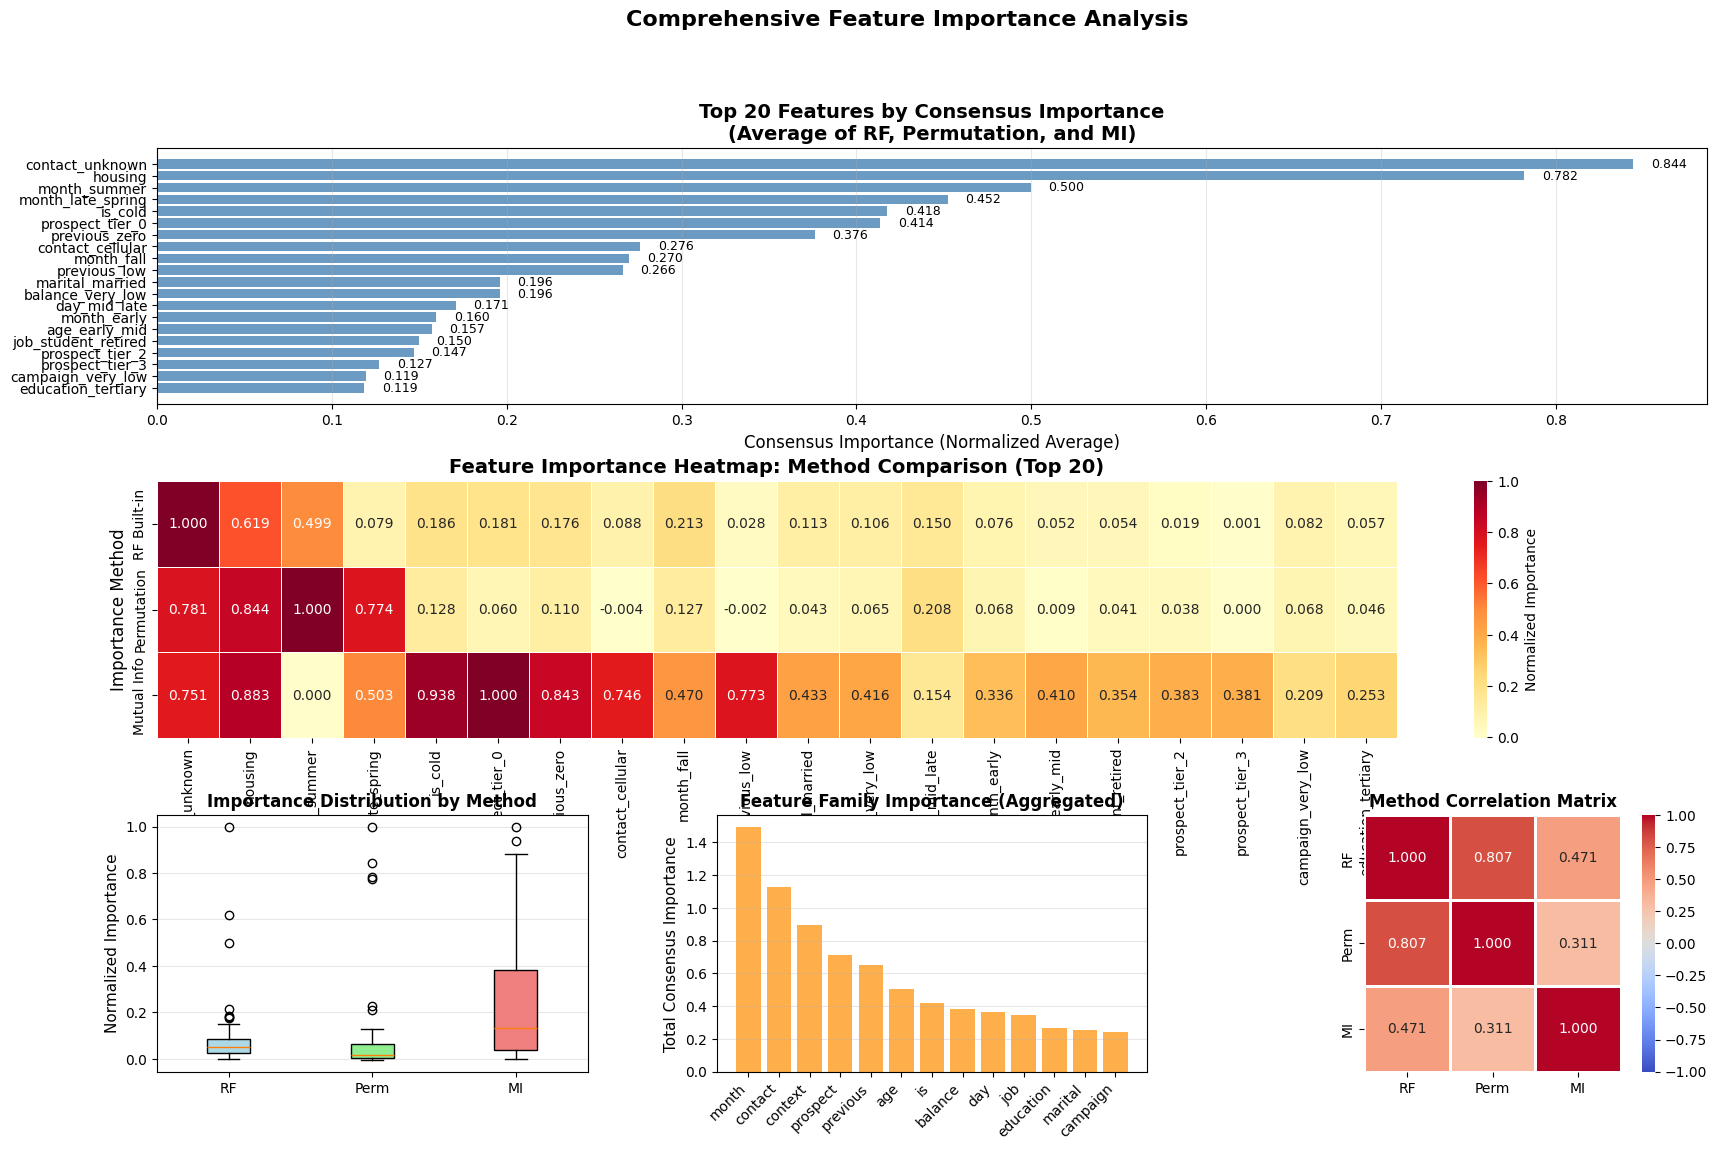


✅ Visualizations saved: rf_feature_importance_analysis.png


In [15]:
# ============================================================
# CELL 8.5: VISUAL ANALYSIS
# ============================================================
print("\n" + "="*80)
print("📊 STEP 6: GENERATING COMPREHENSIVE visual analysis")
print("="*80)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ------------------------------------------------------------
# PLOT 1: Consensus Importance Rankings
# ------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, :])
top_20 = importance_df.head(20)

ax1.barh(range(len(top_20)), top_20['consensus_importance'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Consensus Importance (Normalized Average)', fontsize=12)
ax1.set_title('Top 20 Features by Consensus Importance\n(Average of RF, Permutation, and MI)',
              fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax1.text(row['consensus_importance'] + 0.01, i, f"{row['consensus_importance']:.3f}",
             va='center', fontsize=9)

# ------------------------------------------------------------
# PLOT 2: Method Comparison Heatmap
# ------------------------------------------------------------
ax2 = fig.add_subplot(gs[1, :])

# Prepare data for heatmap
heatmap_data = top_20[['rf_importance_norm', 'perm_importance_norm', 'mi_score_norm']].T
heatmap_data.columns = top_20['feature']
heatmap_data.index = ['RF Built-in', 'Permutation', 'Mutual Info']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Normalized Importance'}, ax=ax2, linewidths=0.5)
ax2.set_title('Feature Importance Heatmap: Method Comparison (Top 20)',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Importance Method', fontsize=12)

# ------------------------------------------------------------
# PLOT 3: Importance Distribution by Method
# ------------------------------------------------------------
ax3 = fig.add_subplot(gs[2, 0])

methods_data = [
    importance_df['rf_importance_norm'].values,
    importance_df['perm_importance_norm'].values,
    importance_df['mi_score_norm'].values
]

bp = ax3.boxplot(methods_data, labels=['RF', 'Perm', 'MI'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral']):
    patch.set_facecolor(color)

ax3.set_ylabel('Normalized Importance', fontsize=11)
ax3.set_title('Importance Distribution by Method', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# ------------------------------------------------------------
# PLOT 4: Feature Family Importance
# ------------------------------------------------------------
ax4 = fig.add_subplot(gs[2, 1])

# Group features by family
importance_df['family'] = importance_df['feature'].apply(
    lambda x: x.split('_')[0] if '_' in x else 'context'
)

family_importance = importance_df.groupby('family')['consensus_importance'].agg(['mean', 'sum']).sort_values('sum', ascending=False)

ax4.bar(range(len(family_importance)), family_importance['sum'], color='darkorange', alpha=0.7)
ax4.set_xticks(range(len(family_importance)))
ax4.set_xticklabels(family_importance.index, rotation=45, ha='right')
ax4.set_ylabel('Total Consensus Importance', fontsize=11)
ax4.set_title('Feature Family Importance (Aggregated)', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# ------------------------------------------------------------
# PLOT 5: Correlation Between Methods
# ------------------------------------------------------------
ax5 = fig.add_subplot(gs[2, 2])

method_corr = importance_df[['rf_importance_norm', 'perm_importance_norm', 'mi_score_norm']].corr()
method_corr.columns = ['RF', 'Perm', 'MI']
method_corr.index = ['RF', 'Perm', 'MI']

sns.heatmap(method_corr, annot=True, fmt='.3f', cmap='coolwarm',
            vmin=-1, vmax=1, center=0, square=True, ax=ax5, linewidths=1)
ax5.set_title('Method Correlation Matrix', fontsize=12, fontweight='bold')

plt.suptitle('Comprehensive Feature Importance Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('rf_feature_importance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualizations saved: rf_feature_importance_analysis.png")


In [16]:
# ============================================================
# CELL 9: RULE DATA STRUCTURE
# ============================================================

@dataclass
class Rule:
    """
    Atomic rule representation for GLASS-BRW sequential execution.

    Single source of truth for all rule state.
    No logic - just data.

    Lifecycle:
    1. RuleGenerator: Creates rule, sets identity + base metrics
    2. RuleEvaluator: Enriches with validation metrics + RF diagnostics
    3. ILPRuleSelector: Reads metrics to select optimal subset
    4. GLASS_BRW: Executes rules sequentially using pass_assignment
    """

    # ============================================================
    # IDENTITY & STRUCTURE
    # ============================================================
    rule_id: int
    segment: Set[Tuple[str, str]]  # Conjunction of (feature, value) conditions
    predicted_class: int  # 0=NOT_SUBSCRIBE, 1=SUBSCRIBE
    complexity: int  # Number of conditions (k ≤ 3)
    pass_assignment: str = "pass2"  # "pass1" or "pass2" for sequential execution

    # ============================================================
    # QUALITY METRICS
    # ============================================================
    # Set by: RuleGenerator (initial), RuleEvaluator (validation-based)
    precision: float = 0.0  # P(y=predicted_class | rule matches)
    recall: float = 0.0     # P(rule matches | y=predicted_class)
    coverage: float = 0.0   # Fraction of population covered

    # ============================================================
    # RF-SPECIFIC DIAGNOSTICS
    # ============================================================
    # Set by: RuleEvaluator
    rf_confidence: float = 0.5  # Mean |RF_proba - 0.5| in segment
    rf_alignment: float = 0.0   # Fraction of segment with RF_conf > 0.2

    # ============================================================
    # EXECUTION METADATA
    # ============================================================
    # Set by: RuleEvaluator (match_rule)
    covered_idx: Set[int] = field(default_factory=set)  # Sample indices matched by rule

    # Set by: RuleGenerator (beam search scoring)
    beam_search_score: float = 0.0

    def __hash__(self):
        return hash((self.rule_id, frozenset(self.segment), self.predicted_class))

    def __eq__(self, other):
        return self.rule_id == other.rule_id


# ============================================================
# CLASS CONSTANTS (module-level for system-wide use)
# ============================================================
SUBSCRIBE = 1
NOT_SUBSCRIBE = 0
ABSTAIN = -1 # Does not meet any rule params

In [17]:
# ============================================================
# CELL 10: SEGMENT BUILDER (EBM-ALIGNED - 54 FEATURES + 5 COMPOSITE)
# ============================================================

class BankSegmentBuilder:
    """
    EBM-aligned binary segment builder for GLASS-BRW.

    Uses 59 binary features:
    - 5 COMPOSITE features (high-impact engineered signals)
    - 6 job bins
    - 4 education bins
    - 3 contact bins
    - 3 marital bins
    - 5 campaign bins (FN-discriminative)
    - 4 previous bins (FN-discriminative)
    - 5 balance bins
    - 5 age bins
    - 5 month bins
    - 4 day bins
    - 3 binary context features
    """

    SEGMENT_FEATURES = [

        # ============================================================
        # COMPOSITE FEATURES (5 bins - HIGH-IMPACT SIGNALS)
        # ============================================================
        "is_cold",
        "prospect_tier_0",
        "prospect_tier_1",
        "prospect_tier_2",
        "prospect_tier_3",

        # ============================================================
        # JOB (6 bins - occupation/skill type)
        # ============================================================
        "job_management_admin",
        "job_technical_services",
        "job_blue_collar",
        "job_self_employed",
        "job_student_retired",
        "job_uncertain",

        # ============================================================
        # EDUCATION (4 bins - educational attainment)
        # ============================================================
        "education_primary",
        "education_secondary",
        "education_tertiary",
        "education_unknown",

        # ============================================================
        # CONTACT (3 bins - communication quality)
        # ============================================================
        "contact_cellular",
        "contact_telephone",
        "contact_unknown",

        # ============================================================
        # MARITAL (3 bins - relationship status)
        # ============================================================
        "marital_divorced",
        "marital_married",
        "marital_single",

        # ============================================================
        # CAMPAIGN (5 bins - FN-discriminative ρ=-0.20)
        # ============================================================
        "campaign_very_low",
        "campaign_low",
        "campaign_mid",
        "campaign_high",
        "campaign_very_high",

        # ============================================================
        # PREVIOUS (4 bins - FN-discriminative ρ=0.33)
        # ============================================================
        "previous_zero",
        "previous_low",
        "previous_mid",
        "previous_high",

        # ============================================================
        # BALANCE (5 bins - non-monotonic ρ=0.37)
        # ============================================================
        "balance_very_low",
        "balance_low",
        "balance_mid",
        "balance_high",
        "balance_very_high",

        # ============================================================
        # AGE (5 bins - non-monotonic ρ=0.21)
        # ============================================================
        "age_young",
        "age_early_mid",
        "age_mid",
        "age_mature",
        "age_senior",

        # ============================================================
        # MONTH (5 bins - non-monotonic ρ=0.27)
        # ============================================================
        "month_early",
        "month_late_spring",
        "month_summer",
        "month_fall",
        "month_year_end",

        # ============================================================
        # DAY (4 bins - non-monotonic ρ=0.36)
        # ============================================================
        "day_early",
        "day_mid_early",
        "day_mid_late",
        "day_late",

        # ============================================================
        # BINARY CONTEXT FEATURES (3 bins)
        # ============================================================
        "default",
        "housing",
        "loan",
    ]

    def assign_segments(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Extract binary segment features from input data.

        Args:
            X: DataFrame with engineered binary features

        Returns:
            Binary DataFrame used for rule generation
        """
        X = X.drop(columns=["y", "y_bin"], errors="ignore")

        # Filter to available columns
        cols = [c for c in self.SEGMENT_FEATURES if c in X.columns]

        if len(cols) == 0:
            raise ValueError("No valid segment features found in input")

        segments = X[cols].copy()

        # Enforce binary contract
        for col in segments.columns:
            vals = set(segments[col].dropna().unique())
            if not vals.issubset({0, 1}):
                raise ValueError(f"Non-binary segment feature: {col} -> {vals}")

        return segments.astype("int8")

In [18]:
# ============================================================
# GLASS-BRW: RULE GENERATOR MODULE
# ============================================================
# DEPTH-STAGED CONSTRAINT STRATEGY:
#   Depth 1: Structural validity ONLY (no support/precision/recall)
#   Depth 2: Light pruning (extreme leakage guardrail)
#   Depth 3: Quality constraints (NO overlap - ILP handles via novelty)
# ============================================================

from collections import defaultdict
import pandas as pd
import numpy as np


class RuleGenerator:

    def __init__(
        self,
        # ============================================================
        # SUPPORT THRESHOLDS - NOW ONLY AT DEPTH 3
        # ============================================================
        min_support_pass1=270,      # Pass 1: Higher for stable filters
        min_support_pass2=100,      # Pass 2: Lower for narrow detectors

        # ============================================================
        # COMPLEXITY BOUNDS
        # ============================================================
        max_complexity=3,           # Maximum conjunctions per rule
        min_complexity=1,           # Minimum conjunctions per rule

        # ============================================================
        # PASS 1: NOT_SUBSCRIBE (Precision-Focused Filters)
        # ============================================================
        min_complexity_not_subscribe=1,
        max_coverage_not_subscribe=1.00,        # Allow full coverage filters
        min_precision_not_subscribe=0.25,       # High precision requirement
        max_precision_not_subscribe=1.00,
        max_subscriber_leakage_rate=0.99,       # FN rate cap (Depth 3)
        max_subscriber_leakage_absolute=999,    # Max subscribers leaked (Depth 3)
        min_seed_precision_not_subscribe=0.05,  # Seed quality gate

        # ============================================================
        # PASS 2: SUBSCRIBE (Recall-Focused Detectors)
        # ============================================================
        min_complexity_subscribe=1,
        max_coverage_subscribe=0.99,        # Prevent overly broad rules
        min_precision_subscribe=0.25,       # Lower bound for recall-focus
        max_precision_subscribe=1.00,       # Upper bound (avoid high-precision filters)
        min_recall_subscribe=0.15,          # Minimum class coverage
        max_recall_subscribe=0.99,          # Maximum recall cap
        min_seed_precision_subscribe=0.05,  # Seed quality gate

        # ============================================================
        # DEPTH 2: LIGHT STRUCTURAL PRUNING
        # ============================================================
        max_leakage_rate_depth2=0.75,           # Extreme leakage guardrail (rate)
        max_leakage_fraction_depth2=0.65,       # Extreme leakage guardrail (fraction of total subs)

        # ============================================================
        # BEAM SEARCH PARAMETERS
        # ============================================================
        mode="strict",              # Constraint enforcement mode
        beam_width=100,             # Top-k rules kept per depth

        # ============================================================
        # DIVERSITY ENFORCEMENT
        # ============================================================
        diversity_penalty=0.3,
        max_feature_reuse_pass1=3,
        max_feature_reuse_pass2=3,
        max_jaccard_overlap=0.35,       # KEPT for reference but NOT used in pruning
        max_high_overlap_rules=None,    # KEPT for reference but NOT used in pruning

        # ============================================================
        # SEGMENT ONTOLOGY (CANONICAL FEATURE SOURCE)
        # ============================================================
        segment_builder=None,

        # ============================================================
        # FEATURE SEMANTICS
        # ============================================================
        tier1_prefixes=(
            'prospect_tier', 'is_cold',  # Composite features
            'job', 'education', 'campaign', 'previous',
            'balance', 'age', 'month', 'day', 'contact',
            'marital', 'default', 'housing', 'loan',
        ),

        # ============================================================
        # RANDOM FOREST INTEGRATION
        # ============================================================
        rf_model=None,
        feature_importance_threshold=0.00, # Adjust later

        # ============================================================
        # DIAGNOSTIC LOGGING
        # ============================================================
        verbose_rejection_logging=True,
        max_rejection_logs_per_constraint=50,
        verbose_acceptance_logging=True,
        max_acceptance_logs_per_depth=25,
    ):
        # ============================================================
        # BASIC PARAMETER STORAGE
        # ============================================================
        self.min_support_pass1 = min_support_pass1
        self.min_support_pass2 = min_support_pass2
        self.max_complexity = max_complexity
        self.min_complexity = min_complexity

        # Pass 1 constraints (Depth 3)
        self.min_complexity_not_subscribe = min_complexity_not_subscribe
        self.max_coverage_not_subscribe = max_coverage_not_subscribe
        self.min_precision_not_subscribe = min_precision_not_subscribe
        self.max_precision_not_subscribe = max_precision_not_subscribe
        self.max_subscriber_leakage_rate = max_subscriber_leakage_rate
        self.max_subscriber_leakage_absolute = max_subscriber_leakage_absolute
        self.min_seed_precision_not_subscribe = min_seed_precision_not_subscribe

        # Pass 2 constraints (Depth 3)
        self.min_complexity_subscribe = min_complexity_subscribe
        self.max_coverage_subscribe = max_coverage_subscribe
        self.min_precision_subscribe = min_precision_subscribe
        self.max_precision_subscribe = max_precision_subscribe
        self.min_recall_subscribe = min_recall_subscribe
        self.max_recall_subscribe = max_recall_subscribe
        self.min_seed_precision_subscribe = min_seed_precision_subscribe

        # ============================================================
        # DEPTH 2 LIGHT PRUNING PARAMETERS
        # ============================================================
        self.max_leakage_rate_depth2 = max_leakage_rate_depth2
        self.max_leakage_fraction_depth2 = max_leakage_fraction_depth2

        # Beam search
        self.mode = mode
        self.beam_width = beam_width

        # Diversity tracking (overlap params kept for reference but NOT used in pruning)
        self.diversity_penalty = diversity_penalty
        self.max_feature_reuse_pass1 = max_feature_reuse_pass1
        self.max_feature_reuse_pass2 = max_feature_reuse_pass2
        self.max_jaccard_overlap = max_jaccard_overlap
        self.max_high_overlap_rules = max_high_overlap_rules

        # ============================================================
        # TRACKING STATE (RESET PER GENERATION)
        # ============================================================
        self.pass1_feature_usage = {}
        self.pass2_feature_usage = {}

        # ============================================================
        # FEATURE SEMANTICS
        # ============================================================
        self.tier1_prefixes = tier1_prefixes

        # ============================================================
        # SEGMENT BUILDER BINDING
        # ============================================================
        if segment_builder is None:
            raise ValueError("RuleGenerator requires a SegmentBuilder instance")

        self.segment_builder = segment_builder
        self.segment_features = list(self.segment_builder.SEGMENT_FEATURES)

        print(f"🧩 RuleGenerator initialized with {len(self.segment_features)} segment features")

        # ============================================================
        # RF INTEGRATION
        # ============================================================
        self.rf_model = rf_model
        self.feature_importance_threshold = feature_importance_threshold
        self.feature_importances_ = None

        # ============================================================
        # DIAGNOSTIC LOGGING CONFIG
        # ============================================================
        self.verbose_rejection_logging = verbose_rejection_logging
        self.max_rejection_logs_per_constraint = max_rejection_logs_per_constraint
        self.verbose_acceptance_logging = verbose_acceptance_logging
        self.max_acceptance_logs_per_depth = max_acceptance_logs_per_depth


    # ============================================================
    # DIAGNOSTIC LOGGING HELPERS
    # ============================================================
    def _log_accepted_rule(
        self,
        seg,
        depth,
        predicted_class,
        precision,
        recall,
        coverage,
        support,
        parent_precision=None,
        parent_recall=None,
        parent_coverage=None,
        parent_segment=None,
        leakage_rate=None,
        subscribers_caught=None,
    ):
        """Log comprehensive metrics for an accepted rule being expanded."""
        pass_name = "Pass1" if predicted_class == 0 else "Pass2"

        seg_sorted = sorted(seg, key=lambda x: x[0])
        seg_str = "{" + ", ".join([f"({f!r}, {v})" for f, v in seg_sorted]) + "}"

        print(f"\n{'─'*70}")
        print(f"✅ ACCEPTED: {seg_str}")
        print(f"   Depth: {depth} | {pass_name}")

        # Show parent segment if available
        if parent_segment is not None:
            parent_sorted = sorted(parent_segment, key=lambda x: x[0])
            parent_str = "{" + ", ".join([f"({f!r}, {v})" for f, v in parent_sorted]) + "}"
            # Find the new feature added
            new_features = seg - parent_segment
            if new_features:
                new_feat_str = ", ".join([f"({f!r}, {v})" for f, v in new_features])
                print(f"   Parent: {parent_str}")
                print(f"   Added:  {new_feat_str}")

        print(f"{'─'*70}")

        print(f"  Precision: {precision:.4f}", end="")
        if parent_precision is not None:
            prec_delta = precision - parent_precision
            print(f"  (parent: {parent_precision:.4f}, Δ = {prec_delta:+.4f})")
        else:
            print()

        print(f"  Recall:    {recall:.4f}", end="")
        if parent_recall is not None:
            rec_delta = recall - parent_recall
            print(f"  (parent: {parent_recall:.4f}, Δ = {rec_delta:+.4f})")
        else:
            print()

        print(f"  Coverage:  {coverage:.4f}", end="")
        if parent_coverage is not None:
            cov_delta = coverage - parent_coverage
            print(f"  (parent: {parent_coverage:.4f}, Δ = {cov_delta:+.4f})")
        else:
            print()

        print(f"  Support:   {support}")

        if leakage_rate is not None:
            if predicted_class == 0:
                print(f"  Leakage:   {subscribers_caught} absolute (rate: {leakage_rate:.4f})")
            else:
                print(f"  Subscribers caught: {subscribers_caught} (recall: {leakage_rate:.4f})")

        # Compute score
        if predicted_class == 0:
            score = (precision ** 3) * np.sqrt(coverage)
            print(f"  Score:     {score:.6f}  (prec³ × √cov)")
        else:
            score = (recall ** 3) * precision * coverage
            print(f"  Score:     {score:.6f}  (rec³ × prec × cov)")

        # F1 proxy
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        print(f"  F1 proxy:  {f1:.4f}")

        print(f"{'─'*70}")

    def _log_rejected_rule(
        self,
        seg,
        depth,
        rejection_reason,
        predicted_class,
        precision,
        recall,
        coverage,
        support,
        parent_precision,
        parent_recall,
        parent_coverage,
        parent_segment=None,
        leakage_rate=None,
        subscribers_caught=None,
        threshold_info=None,
    ):
        """Log comprehensive metrics for a rejected rule."""
        pass_name = "Pass1" if predicted_class == 0 else "Pass2"

        seg_sorted = sorted(seg, key=lambda x: x[0])
        seg_str = "{" + ", ".join([f"({f!r}, {v})" for f, v in seg_sorted]) + "}"

        print(f"\n{'─'*70}")
        print(f"🔍 REJECTED: {seg_str}")
        print(f"   Reason: {rejection_reason} | Depth: {depth} | {pass_name}")

        # Show parent segment if available
        if parent_segment is not None:
            parent_sorted = sorted(parent_segment, key=lambda x: x[0])
            parent_str = "{" + ", ".join([f"({f!r}, {v})" for f, v in parent_sorted]) + "}"
            new_features = seg - parent_segment
            if new_features:
                new_feat_str = ", ".join([f"({f!r}, {v})" for f, v in new_features])
                print(f"   Parent: {parent_str}")
                print(f"   Added:  {new_feat_str}")

        print(f"{'─'*70}")

        prec_delta = precision - parent_precision
        rec_delta = recall - parent_recall
        cov_delta = coverage - parent_coverage

        print(f"  Precision: {precision:.4f}  (parent: {parent_precision:.4f}, Δ = {prec_delta:+.4f})")
        print(f"  Recall:    {recall:.4f}  (parent: {parent_recall:.4f}, Δ = {rec_delta:+.4f})")
        print(f"  Coverage:  {coverage:.4f}  (parent: {parent_coverage:.4f}, Δ = {cov_delta:+.4f})")
        print(f"  Support:   {support}")

        # ============================================================
        # PASS-SPECIFIC TERMINOLOGY FOR SUBSCRIBER METRICS
        # ============================================================
        if leakage_rate is not None:
            if predicted_class == 0:
                print(f"  Leakage:   {subscribers_caught} absolute (rate: {leakage_rate:.4f})")
                print(f"             thresholds: abs ≤ {self.max_subscriber_leakage_absolute}, "
                      f"rate ≤ {self.max_subscriber_leakage_rate:.2f}")
            else:
                print(f"  Subscribers: {subscribers_caught} caught (recall: {leakage_rate:.4f})")
                print(f"             thresholds: recall ≥ {self.min_recall_subscribe}, "
                      f"recall ≤ {self.max_recall_subscribe:.2f}")

        if threshold_info:
            print(f"  Threshold: {threshold_info}")

        print(f"  ── Derived ──")

        if prec_delta < 0 and rec_delta > 0:
            tradeoff_ratio = abs(rec_delta) / abs(prec_delta) if prec_delta != 0 else float('inf')
            print(f"  P-R Tradeoff: {tradeoff_ratio:.2f}x recall gain per precision loss")
        elif prec_delta > 0 and rec_delta > 0:
            print(f"  P-R Tradeoff: BOTH improved (precision +{prec_delta:.4f}, recall +{rec_delta:.4f})")
        elif prec_delta < 0 and rec_delta < 0:
            print(f"  P-R Tradeoff: BOTH degraded (precision {prec_delta:.4f}, recall {rec_delta:.4f})")

        parent_f1 = 2 * parent_precision * parent_recall / (parent_precision + parent_recall + 1e-10)
        child_f1 = 2 * precision * recall / (precision + recall + 1e-10)
        f1_delta = child_f1 - parent_f1
        print(f"  F1 proxy:  {child_f1:.4f}  (parent: {parent_f1:.4f}, Δ = {f1_delta:+.4f})")

        print(f"{'─'*70}")


    def _extract_base_feature(self, feature_name):
        """Map discretized feature to its base variable family."""
        # Composite features
        if feature_name == 'is_cold':
            return 'is_cold'
        if feature_name.startswith('prospect_tier_'):
            return 'prospect_tier'

        # Standard binned features
        base_prefixes = [
            'job_', 'education_', 'contact_', 'marital_',
            'campaign_', 'previous_', 'balance_', 'age_',
            'month_', 'day_',
        ]

        for prefix in base_prefixes:
            if feature_name.startswith(prefix):
                return prefix.rstrip('_')

        # Bin suffixes (for reverse lookup if needed)
        bin_suffixes = [
            '_management_admin', '_technical_services', '_blue_collar',
            '_self_employed', '_student_retired', '_uncertain',
            '_primary', '_secondary', '_tertiary', '_unknown',
            '_cellular', '_telephone',
            '_divorced', '_married', '_single',
            '_very_low', '_low', '_mid', '_high', '_very_high',
            '_zero', '_one', '_two', '_three',
            '_young', '_early_mid', '_mature', '_senior',
            '_early', '_late_spring', '_summer', '_fall', '_year_end',
            '_mid_early', '_mid_late', '_late',
        ]

        for suffix in bin_suffixes:
            if feature_name.endswith(suffix):
                return feature_name[:-len(suffix)]

        # Binary features (no prefix/suffix)
        return feature_name

    def _has_duplicate_base_features(self, segment):
        """Validate rule structure: no multiple bins from same base feature."""
        observed_bases = set()

        for feature, _ in segment:
            base = self._extract_base_feature(feature)

            if base in observed_bases:
                return True

            observed_bases.add(base)

        return False

    def _has_tier1_feature(self, segment):
        """Check if segment contains at least one tier1 feature."""
        features = {f for f, _ in segment}
        return any(
            any(f.startswith(prefix) for prefix in self.tier1_prefixes)
            for f in features
        )

    # ============================================================
    # RANDOM FOREST INTEGRATION
    # ============================================================

    def _compute_rf_feature_importance(self, segments_df, y):
        """Compute or retrieve RF feature importances."""

        if self.rf_model is None:
            print("Training RF for feature importance...")
            self.rf_model = RandomForestClassifier(
                n_estimators=100,
                max_depth=8,
                min_samples_split=50,
                min_samples_leaf=25,
                random_state=42,
                n_jobs=-1
            )
            self.rf_model.fit(segments_df, y)

        importances = dict(zip(
            segments_df.columns,
            self.rf_model.feature_importances_
        ))
        self.feature_importances_ = importances

        top_features = sorted(
            importances.items(),
            key=lambda x: x[1],
            reverse=True
        )[:10]

        print("\nTop 10 RF features by importance:")
        for feat, imp in top_features:
            print(f"  {feat}: {imp:.4f}")

        return importances

    def _get_feature_order(self, segments_df, y):
        """Get features ordered by RF importance."""
        importances = self._compute_rf_feature_importance(segments_df, y)

        important_features = [
            f for f, imp in importances.items()
            if imp >= self.feature_importance_threshold
        ]

        important_features.sort(
            key=lambda f: importances[f],
            reverse=True
        )

        print(f"\nUsing {len(important_features)}/{len(segments_df.columns)} "
              f"features above threshold")

        return important_features

    # ============================================================
    # RULE QUALITY METRICS
    # ============================================================

    def _compute_rule_mask(self, segment, segments_df):
        """Compute boolean mask for samples matching rule segment."""
        mask = pd.Series(True, index=segments_df.index)

        for feature, level in segment:
            mask &= (segments_df[feature] == level)

        return mask

    def _compute_precision(self, mask, y, predicted_class):
        """Compute class-specific precision."""
        if mask.sum() == 0:
            return 0.0

        return (y[mask] == predicted_class).mean()

    def _compute_recall(self, mask, y, predicted_class):
        """Compute class-specific recall."""
        total_class = (y == predicted_class).sum()

        if total_class == 0:
            return 0.0

        true_positives = ((y == predicted_class) & mask).sum()
        return true_positives / total_class

    def _compute_subscriber_leakage(self, mask, y):
        """Compute subscriber leakage for Pass 1 rules."""
        subscriber_mask = (y == 1)
        total_subscribers = subscriber_mask.sum()

        if total_subscribers == 0:
            return 0.0, 0

        subscribers_caught = (mask & subscriber_mask).sum()
        leakage_rate = subscribers_caught / total_subscribers

        return leakage_rate, subscribers_caught

    # ============================================================
    # DIVERSITY & OVERLAP METRICS
    # ============================================================

    def _get_diversity_penalty(self, segment, predicted_class):
        """Compute diversity penalty based on feature reuse."""
        if predicted_class == 0:
            feature_usage = self.pass1_feature_usage
        else:
            feature_usage = self.pass2_feature_usage

        penalty = 0.0

        for feature, _ in segment:
            base = self._extract_base_feature(feature)
            usage_count = feature_usage.get(base, 0)

            if usage_count > 0:
                penalty += self.diversity_penalty * (usage_count ** 1.2)

        return max(0.1, 1.0 - penalty)

    def _update_feature_usage(self, segment, predicted_class):
        """Track feature usage for diversity enforcement."""
        if predicted_class == 0:
            feature_usage = self.pass1_feature_usage
        else:
            feature_usage = self.pass2_feature_usage

        for feature, _ in segment:
            base = self._extract_base_feature(feature)
            feature_usage[base] = feature_usage.get(base, 0) + 1

    # ============================================================
    # BEAM SEARCH SCORING
    # ============================================================

    def _score(self, precision, recall, coverage, predicted_class, segment=None):
        """Compute beam search score for rule ranking."""
        if predicted_class == 0:
            base_score = (precision ** 3) * np.sqrt(coverage)
        else:
            base_score = (recall ** 3) * precision * coverage

        if segment is not None:
            diversity_mult = self._get_diversity_penalty(segment, predicted_class)
            return base_score * diversity_mult

        return base_score

    # ============================================================
    # RULE DEDUPLICATION
    # ============================================================

    def _deduplicate_rules(self, rules):
        """Remove duplicate rules via segment matching."""
        unique = {}

        for rule in rules:
            seg_signature = frozenset(rule.segment)

            if seg_signature not in unique:
                unique[seg_signature] = rule
            else:
                if rule._s > unique[seg_signature]._s:
                    unique[seg_signature] = rule

        return list(unique.values())

    # ============================================================
    # MAIN GENERATION PIPELINE
    # ============================================================

    def generate_candidates(self, segments_df, y):
        """
        Generate candidate rules with DEPTH-STAGED CONSTRAINTS.

        Depth Strategy:
            Depth 1: Structural validity ONLY (no support/precision/recall)
            Depth 2: Light pruning (extreme leakage guardrail, precision floor, coverage cap)
            Depth 3: Quality checks (support, precision, recall, coverage)
                     NO OVERLAP CHECK - ILP handles via novelty constraints
                     NO NOVEL COVERAGE CHECK - ILP handles diversity
        """
        # ============================================================
        # STEP 1: INITIALIZATION
        # ============================================================
        features = self._get_feature_order(segments_df, y)
        N = len(segments_df)

        # Compute total subscribers for extreme leakage guardrail
        total_subscribers = (y == 1).sum()
        max_leakage_absolute_depth2 = int(total_subscribers * self.max_leakage_fraction_depth2)

        # Reset tracking structures
        self.pass1_feature_usage = {}
        self.pass2_feature_usage = {}

        # Print generation summary
        print(f"\n{'='*60}")
        print("SEQUENTIAL RULE GENERATION WITH DEPTH-STAGED CONSTRAINTS")
        print(f"{'='*60}")
        print(f"  Beam width: {self.beam_width}")
        print(f"  Complexity: {self.min_complexity}–{self.max_complexity}")
        print(f"  Total samples: {N}")
        print(f"  Total subscribers: {total_subscribers}")
        print(f"\n  ✅ DEPTH-STAGED CONSTRAINT STRATEGY:")
        print(f"    • Depth 1: ONLY structural validity (no support/precision/recall)")
        print(f"    • Depth 2: Light pruning ONLY:")
        print(f"        - Extreme leakage guardrail: rate > {self.max_leakage_rate_depth2:.2f} OR")
        print(f"          absolute > {max_leakage_absolute_depth2} ({self.max_leakage_fraction_depth2:.0%} of {total_subscribers} subs)")
        print(f"        - Pass 2: Precision floor ≥ 0.15, Coverage cap ≤ 0.50")
        print(f"    • Depth 3: Quality constraints (NO OVERLAP, NO NOVEL COVERAGE - ILP handles)")
        print(f"\n  Pass 1 (NOT_SUBSCRIBE) - Depth 3 thresholds:")
        print(f"    • min_support={self.min_support_pass1}")
        print(f"    • min_precision={self.min_precision_not_subscribe}")
        print(f"  Pass 2 (SUBSCRIBE) - Depth 3 thresholds:")
        print(f"    • min_support={self.min_support_pass2}")
        print(f"    • min_precision={self.min_precision_subscribe}")
        print(f"    • min_recall={self.min_recall_subscribe}")
        print(f"    • max_recall={self.max_recall_subscribe}")
        print(f"\n  ⚠️  NOVEL COVERAGE PRUNING REMOVED - ILP handles diversity")

        if self.verbose_rejection_logging:
            print(f"\n  🔍 VERBOSE REJECTION LOGGING: ENABLED")
            print(f"     Max logs per constraint: {self.max_rejection_logs_per_constraint}")
        else:
            print(f"\n  🔍 VERBOSE REJECTION LOGGING: DISABLED")

        if self.verbose_acceptance_logging:
            print(f"  ✅ VERBOSE ACCEPTANCE LOGGING: ENABLED")
            print(f"     Max logs per depth: {self.max_acceptance_logs_per_depth}")
        else:
            print(f"  ✅ VERBOSE ACCEPTANCE LOGGING: DISABLED")

        rule_id = 0
        all_candidates = []
        current = {0: [], 1: []}

        # ============================================================
        # STEP 2: DEPTH 1 - SEED GENERATION
        # ============================================================
        seed_features = list(self.segment_features)
        accepted_seeds = {0: [], 1: []}

        debug_stats = {
            'total_considered': 0,
            'rejected_duplicate_base': 0,
            'accepted': {0: 0, 1: 0}
        }

        print(f"\n{'='*60}")
        print(f"DEPTH 1: SEED GENERATION")
        print(f"{'='*60}")
        print(f"  🚫 NO support constraints at this depth")
        print(f"  🚫 NO precision/recall constraints at this depth")

        for f in seed_features:
            for level in (1, 0):
                seg = {(f, level)}
                debug_stats['total_considered'] += 1

                # ============================================================
                # DEPTH 1 CONSTRAINT: STRUCTURAL VALIDITY ONLY
                # ============================================================
                if self._has_duplicate_base_features(seg):
                    debug_stats['rejected_duplicate_base'] += 1
                    continue

                # Compute rule coverage (needed for scoring)
                mask = self._compute_rule_mask(seg, segments_df)
                support = mask.sum()

                # Skip if literally zero support
                if support == 0:
                    continue

                # Generate rule for both classes
                for predicted_class in (0, 1):
                    coverage = support / N
                    precision = self._compute_precision(mask, y, predicted_class)
                    recall = self._compute_recall(mask, y, predicted_class)

                    debug_stats['accepted'][predicted_class] += 1
                    if debug_stats['accepted'][predicted_class] <= 10:
                        print(f"DEBUG: ACCEPTED {seg} for class {predicted_class}: "
                              f"p={precision:.3f}, r={recall:.3f}, cov={coverage:.3f}, sup={support}")

                    # Create rule object
                    rule = Rule(
                        rule_id=rule_id,
                        segment=seg,
                        predicted_class=predicted_class,
                        complexity=1,
                        pass_assignment="pass1" if predicted_class == 0 else "pass2"
                    )

                    rule._p = precision
                    rule._r = recall
                    rule._c = coverage
                    rule._s = self._score(precision, recall, coverage, predicted_class, seg)
                    rule._cls = predicted_class

                    current[predicted_class].append(rule)
                    accepted_seeds[predicted_class].append(rule)
                    rule_id += 1

        print(f"\n{'='*60}")
        print("DEPTH 1 SUMMARY:")
        print(f"{'='*60}")
        print(f"Total feature-label pairs considered: {debug_stats['total_considered']}")
        print(f"Rejected - duplicate base features: {debug_stats['rejected_duplicate_base']}")

        for cls in (0, 1):
            pass_name = "Pass 1 (NOT_SUBSCRIBE)" if cls == 0 else "Pass 2 (SUBSCRIBE)"
            print(f"\n{pass_name}:")
            print(f"  Accepted: {debug_stats['accepted'][cls]}")

        # Deduplicate seeds
        for cls in (0, 1):
            before = len(current[cls])
            current[cls] = self._deduplicate_rules(current[cls])
            after = len(current[cls])
            if after < before:
                print(f"  Pass {2 if cls == 1 else 1}: Deduplicated seeds {before} → {after}")

        print(f"\nDepth 1 seeds (structural validity only):")
        print(f"  Pass 1 (NOT_SUBSCRIBE): {len(current[0])} rules")
        print(f"  Pass 2 (SUBSCRIBE): {len(current[1])} rules")

        # ============================================================
        # STEP 3: BEAM SEARCH EXPANSION (DEPTH 2+)
        # ============================================================

        for depth in range(2, self.max_complexity + 1):
            print(f"\n{'='*60}")
            if depth == 2:
                print(f"DEPTH {depth}: Light Structural Pruning")
                print(f"  ✅ Pass 1: Extreme leakage guardrail:")
                print(f"     rate > {self.max_leakage_rate_depth2:.2f} OR absolute > {max_leakage_absolute_depth2}")
                print(f"  ✅ Pass 2: Precision floor ≥ 0.15")
                print(f"  ✅ Pass 2: Coverage cap ≤ 0.50")
                print(f"  🚫 NO novel coverage constraints")
                print(f"  🚫 NO support constraints")
                print(f"  🚫 NO overlap constraints")
            else:
                print(f"DEPTH {depth}: Quality Constraints (NO OVERLAP, NO NOVEL COVERAGE - ILP handles)")
            print(f"{'='*60}")

            next_rules = {0: [], 1: []}
            expansions = 0

            # Debug stats for this depth
            debug_stats_depth = {
                'total_considered': {0: 0, 1: 0},
                'rejected_duplicate_base': {0: 0, 1: 0},
                'rejected_duplicate_segment': {0: 0, 1: 0},
                'rejected_tier1': {0: 0, 1: 0},
                'rejected_support': {0: 0, 1: 0},
                'rejected_extreme_leakage_depth2': {0: 0, 1: 0},
                'rejected_precision_depth2': {0: 0, 1: 0},
                'rejected_coverage_depth2': {0: 0, 1: 0},
                'rejected_coverage_cap': {0: 0, 1: 0},
                'rejected_precision': {0: 0, 1: 0},
                'rejected_recall': {0: 0, 1: 0},
                'rejected_recall_cap': {0: 0, 1: 0},
                'rejected_leakage': {0: 0, 1: 0},
                'accepted': {0: 0, 1: 0}
            }

            rejection_log_counts = defaultdict(lambda: {0: 0, 1: 0})
            acceptance_log_counts = {0: 0, 1: 0}  # Track accepted rule logs per class

            for predicted_class in (0, 1):
                print(f"\n  Expanding {len(current[predicted_class])} "
                      f"Pass {2 if predicted_class == 1 else 1} rules...")

                accepted_this_depth = []

                # ============================================================
                # TRACK SEEN SEGMENTS TO AVOID DUPLICATES (ORDER-INDEPENDENT)
                # ============================================================
                seen_segments_this_depth = set()

                for parent in current[predicted_class]:
                    used_features = {f for f, _ in parent.segment}
                    used_base_features = {
                        self._extract_base_feature(f) for f in used_features
                    }

                    for feature in features:
                        if feature in used_features:
                            continue

                        base_feature = self._extract_base_feature(feature)
                        if base_feature in used_base_features:
                            continue

                        for level in (1, 0):
                            seg = parent.segment | {(feature, level)}
                            debug_stats_depth['total_considered'][predicted_class] += 1

                            # ============================================================
                            # CHECK FOR DUPLICATE SEGMENT (ORDER-INDEPENDENT)
                            # ============================================================
                            seg_signature = frozenset(seg)
                            if seg_signature in seen_segments_this_depth:
                                debug_stats_depth['rejected_duplicate_segment'][predicted_class] += 1
                                continue

                            # Mark this segment as seen
                            seen_segments_this_depth.add(seg_signature)

                            # ============================================================
                            # UNIVERSAL CONSTRAINTS (ALL DEPTHS)
                            # ============================================================

                            # Check 1: No duplicate base features
                            if self._has_duplicate_base_features(seg):
                                debug_stats_depth['rejected_duplicate_base'][predicted_class] += 1
                                continue

                            # Check 2: Tier 1 requirement (Pass 2, depth ≥ 2)
                            if predicted_class == 1 and depth >= 2 and not self._has_tier1_feature(seg):
                                debug_stats_depth['rejected_tier1'][predicted_class] += 1
                                continue

                            # Compute rule coverage
                            mask = self._compute_rule_mask(seg, segments_df)
                            support = mask.sum()

                            # Skip if literally zero support
                            if support == 0:
                                continue

                            # Compute quality metrics
                            coverage = support / N
                            precision = self._compute_precision(mask, y, predicted_class)
                            recall = self._compute_recall(mask, y, predicted_class)

                            # ============================================================
                            # DEPTH 2: LIGHT STRUCTURAL PRUNING ONLY
                            # Rules failing here are NOT expanded at depth 3
                            # ============================================================
                            if depth == 2:
                                # Constraint 1: Extreme leakage guardrail (Pass 1 only, BLOCKS EXPANSION)
                                if predicted_class == 0:
                                    leakage_rate, subscribers_caught = self._compute_subscriber_leakage(mask, y)

                                    if (leakage_rate > self.max_leakage_rate_depth2 or
                                        subscribers_caught > max_leakage_absolute_depth2):
                                        debug_stats_depth['rejected_extreme_leakage_depth2'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['extreme_leakage_d2'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['extreme_leakage_d2'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"extreme_leakage_depth2 (rate={leakage_rate:.3f} > {self.max_leakage_rate_depth2} OR abs={subscribers_caught} > {max_leakage_absolute_depth2})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=leakage_rate,
                                                subscribers_caught=subscribers_caught,
                                                threshold_info=f"max_leakage_rate_depth2={self.max_leakage_rate_depth2}, max_abs={max_leakage_absolute_depth2}",
                                            )
                                        continue

                                # ============================================================
                                # Constraint 2: Precision floor for Pass 2 (BLOCKS EXPANSION)
                                # Prevents broad low-precision rules from being expanded
                                # ============================================================
                                if predicted_class == 1:
                                    min_prec_depth2 = 0.15  # Lower than depth 3, but blocks junk
                                    if precision < min_prec_depth2:
                                        debug_stats_depth['rejected_precision_depth2'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['precision_d2'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['precision_d2'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"precision_depth2 ({precision:.4f} < {min_prec_depth2})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                threshold_info=f"min_precision_depth2={min_prec_depth2}",
                                            )
                                        continue

                                    # Also cap max coverage at depth 2 to prevent ultra-broad rules
                                    max_cov_depth2 = 0.50  # Max 50% coverage at depth 2
                                    if coverage > max_cov_depth2:
                                        debug_stats_depth['rejected_coverage_depth2'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['coverage_d2'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['coverage_d2'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"coverage_depth2 ({coverage:.4f} > {max_cov_depth2})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                threshold_info=f"max_coverage_depth2={max_cov_depth2}",
                                            )
                                        continue

                            # ============================================================
                            # DEPTH 3: QUALITY CONSTRAINTS (NO OVERLAP, NO NOVEL COVERAGE)
                            # These are candidate filters - ILP handles diversity
                            # ============================================================
                            else:  # depth >= 3
                                # Compute metrics for logging
                                if self.verbose_rejection_logging:
                                    _leakage_rate, _subscribers_caught = self._compute_subscriber_leakage(mask, y)

                                # Check 3: Minimum support
                                min_support = (self.min_support_pass1 if predicted_class == 0
                                             else self.min_support_pass2)

                                if support < min_support:
                                    debug_stats_depth['rejected_support'][predicted_class] += 1

                                    if (self.verbose_rejection_logging and
                                        rejection_log_counts['support'][predicted_class] < self.max_rejection_logs_per_constraint):
                                        rejection_log_counts['support'][predicted_class] += 1
                                        self._log_rejected_rule(
                                            seg=seg,
                                            depth=depth,
                                            rejection_reason=f"support ({support} < {min_support})",
                                            predicted_class=predicted_class,
                                            precision=precision,
                                            recall=recall,
                                            coverage=coverage,
                                            support=support,
                                            parent_precision=parent._p,
                                            parent_recall=parent._r,
                                            parent_coverage=parent._c,
                                            parent_segment=parent.segment,
                                            leakage_rate=_leakage_rate,
                                            subscribers_caught=_subscribers_caught,
                                            threshold_info=f"min_support={'pass1=' + str(self.min_support_pass1) if predicted_class == 0 else 'pass2=' + str(self.min_support_pass2)}",
                                        )
                                    continue

                                # Check 4: Coverage caps
                                if predicted_class == 0 and coverage > self.max_coverage_not_subscribe:
                                    debug_stats_depth['rejected_coverage_cap'][predicted_class] += 1

                                    if (self.verbose_rejection_logging and
                                        rejection_log_counts['coverage_cap'][predicted_class] < self.max_rejection_logs_per_constraint):
                                        rejection_log_counts['coverage_cap'][predicted_class] += 1
                                        self._log_rejected_rule(
                                            seg=seg,
                                            depth=depth,
                                            rejection_reason=f"coverage_cap ({coverage:.4f} > {self.max_coverage_not_subscribe})",
                                            predicted_class=predicted_class,
                                            precision=precision,
                                            recall=recall,
                                            coverage=coverage,
                                            support=support,
                                            parent_precision=parent._p,
                                            parent_recall=parent._r,
                                            parent_coverage=parent._c,
                                            parent_segment=parent.segment,
                                            leakage_rate=_leakage_rate,
                                            subscribers_caught=_subscribers_caught,
                                            threshold_info=f"max_coverage_not_subscribe={self.max_coverage_not_subscribe}",
                                        )
                                    continue

                                if predicted_class == 1 and coverage > self.max_coverage_subscribe:
                                    debug_stats_depth['rejected_coverage_cap'][predicted_class] += 1

                                    if (self.verbose_rejection_logging and
                                        rejection_log_counts['coverage_cap'][predicted_class] < self.max_rejection_logs_per_constraint):
                                        rejection_log_counts['coverage_cap'][predicted_class] += 1
                                        self._log_rejected_rule(
                                            seg=seg,
                                            depth=depth,
                                            rejection_reason=f"coverage_cap ({coverage:.4f} > {self.max_coverage_subscribe})",
                                            predicted_class=predicted_class,
                                            precision=precision,
                                            recall=recall,
                                            coverage=coverage,
                                            support=support,
                                            parent_precision=parent._p,
                                            parent_recall=parent._r,
                                            parent_coverage=parent._c,
                                            parent_segment=parent.segment,
                                            leakage_rate=_leakage_rate,
                                            subscribers_caught=_subscribers_caught,
                                            threshold_info=f"max_coverage_subscribe={self.max_coverage_subscribe}",
                                        )
                                    continue

                                # ============================================================
                                # NO NOVEL COVERAGE CHECK - ILP handles diversity
                                # ============================================================

                                # ============================================================
                                # NO OVERLAP CHECK - ILP handles via novelty constraints
                                # ============================================================

                                # Check 5: Pass-specific quality gates
                                if predicted_class == 0:  # Pass 1: Precision + leakage
                                    if (precision < self.min_precision_not_subscribe or
                                        precision > self.max_precision_not_subscribe):
                                        debug_stats_depth['rejected_precision'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['precision_range'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['precision_range'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"precision_range ({precision:.4f} not in [{self.min_precision_not_subscribe}, {self.max_precision_not_subscribe}])",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=_leakage_rate,
                                                subscribers_caught=_subscribers_caught,
                                                threshold_info=f"precision_range=[{self.min_precision_not_subscribe}, {self.max_precision_not_subscribe}]",
                                            )
                                        continue

                                    leakage_rate, subscribers_caught = self._compute_subscriber_leakage(mask, y)

                                    if leakage_rate > self.max_subscriber_leakage_rate:
                                        debug_stats_depth['rejected_leakage'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['leakage_rate'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['leakage_rate'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"leakage_rate ({leakage_rate:.4f} > {self.max_subscriber_leakage_rate})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=leakage_rate,
                                                subscribers_caught=subscribers_caught,
                                                threshold_info=f"max_subscriber_leakage_rate={self.max_subscriber_leakage_rate}",
                                            )
                                        continue

                                    if subscribers_caught > self.max_subscriber_leakage_absolute:
                                        debug_stats_depth['rejected_leakage'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['leakage_abs'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['leakage_abs'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"leakage_absolute ({subscribers_caught} > {self.max_subscriber_leakage_absolute})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=leakage_rate,
                                                subscribers_caught=subscribers_caught,
                                                threshold_info=f"max_subscriber_leakage_absolute={self.max_subscriber_leakage_absolute}",
                                            )
                                        continue

                                else:  # Pass 2: Precision + recall
                                    if (precision < self.min_precision_subscribe or
                                        precision > self.max_precision_subscribe):
                                        debug_stats_depth['rejected_precision'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['precision_range'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['precision_range'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"precision_range ({precision:.4f} not in [{self.min_precision_subscribe}, {self.max_precision_subscribe}])",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=_leakage_rate,
                                                subscribers_caught=_subscribers_caught,
                                                threshold_info=f"precision_range=[{self.min_precision_subscribe}, {self.max_precision_subscribe}]",
                                            )
                                        continue

                                    if recall < self.min_recall_subscribe:
                                        debug_stats_depth['rejected_recall'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['recall_min'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['recall_min'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"recall ({recall:.4f} < {self.min_recall_subscribe})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=_leakage_rate,
                                                subscribers_caught=_subscribers_caught,
                                                threshold_info=f"min_recall_subscribe={self.min_recall_subscribe}",
                                            )
                                        continue

                                    if recall > self.max_recall_subscribe:
                                        debug_stats_depth['rejected_recall_cap'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['recall_cap'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['recall_cap'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"recall_cap ({recall:.4f} > {self.max_recall_subscribe})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=_leakage_rate,
                                                subscribers_caught=_subscribers_caught,
                                                threshold_info=f"max_recall_subscribe={self.max_recall_subscribe}",
                                            )
                                        continue

                            # ============================================================
                            # ALL CHECKS PASSED → BUILD RULE
                            # ============================================================

                            # Log accepted rule (compute metrics fresh for logging)
                            if (self.verbose_acceptance_logging and
                                acceptance_log_counts[predicted_class] < self.max_acceptance_logs_per_depth):
                                acceptance_log_counts[predicted_class] += 1

                                _leak_rate_log, _subs_caught_log = self._compute_subscriber_leakage(mask, y)

                                self._log_accepted_rule(
                                    seg=seg,
                                    depth=depth,
                                    predicted_class=predicted_class,
                                    precision=precision,
                                    recall=recall,
                                    coverage=coverage,
                                    support=support,
                                    parent_precision=parent._p,
                                    parent_recall=parent._r,
                                    parent_coverage=parent._c,
                                    parent_segment=parent.segment,
                                    leakage_rate=_leak_rate_log,
                                    subscribers_caught=_subs_caught_log,
                                )

                            rule = Rule(
                                rule_id=rule_id,
                                segment=seg,
                                predicted_class=predicted_class,
                                complexity=depth,
                                pass_assignment="pass1" if predicted_class == 0 else "pass2"
                            )

                            rule._p = precision
                            rule._r = recall
                            rule._c = coverage
                            rule._s = self._score(precision, recall, coverage, predicted_class, seg)
                            rule._cls = predicted_class

                            debug_stats_depth['accepted'][predicted_class] += 1
                            next_rules[predicted_class].append(rule)
                            accepted_this_depth.append(rule)

                            rule_id += 1
                            expansions += 1

            # Print depth summary
            print(f"\n{'='*60}")
            print(f"DEPTH {depth} SUMMARY:")
            print(f"{'='*60}")

            for cls in (0, 1):
                pass_name = "Pass 1 (NOT_SUBSCRIBE)" if cls == 0 else "Pass 2 (SUBSCRIBE)"
                print(f"\n{pass_name}:")
                print(f"  Total considered: {debug_stats_depth['total_considered'][cls]}")
                print(f"  Accepted: {debug_stats_depth['accepted'][cls]}")
                print(f"  Rejected - duplicate segment (order-independent): {debug_stats_depth['rejected_duplicate_segment'][cls]}")
                print(f"  Rejected - duplicate base: {debug_stats_depth['rejected_duplicate_base'][cls]}")

                if depth >= 2 and cls == 1:
                    print(f"  Rejected - missing tier1: {debug_stats_depth['rejected_tier1'][cls]}")

                if depth == 2:
                    if cls == 0:
                        print(f"  Rejected - extreme leakage (depth2): {debug_stats_depth['rejected_extreme_leakage_depth2'][cls]}")
                    else:  # Pass 2
                        print(f"  Rejected - precision floor (depth2): {debug_stats_depth['rejected_precision_depth2'][cls]}")
                        print(f"  Rejected - coverage cap (depth2): {debug_stats_depth['rejected_coverage_depth2'][cls]}")
                else:  # depth 3
                    print(f"  Rejected - support: {debug_stats_depth['rejected_support'][cls]}")
                    print(f"  Rejected - coverage cap: {debug_stats_depth['rejected_coverage_cap'][cls]}")

                    if cls == 0:
                        print(f"  Rejected - precision range: {debug_stats_depth['rejected_precision'][cls]}")
                        print(f"  Rejected - leakage: {debug_stats_depth['rejected_leakage'][cls]}")
                    else:
                        print(f"  Rejected - precision range: {debug_stats_depth['rejected_precision'][cls]}")
                        print(f"  Rejected - recall (min): {debug_stats_depth['rejected_recall'][cls]}")
                        print(f"  Rejected - recall (cap): {debug_stats_depth['rejected_recall_cap'][cls]}")

            if self.verbose_rejection_logging:
                print(f"\n  🔍 Detailed rejection logs emitted this depth:")
                for constraint_key, counts in sorted(rejection_log_counts.items()):
                    total = counts[0] + counts[1]
                    if total > 0:
                        print(f"     {constraint_key}: Pass1={counts[0]}, Pass2={counts[1]}")

            if self.verbose_acceptance_logging:
                print(f"\n  ✅ Acceptance logs emitted this depth:")
                print(f"     Pass1={acceptance_log_counts[0]}, Pass2={acceptance_log_counts[1]}")
                total_accepted = debug_stats_depth['accepted'][0] + debug_stats_depth['accepted'][1]
                total_logged = acceptance_log_counts[0] + acceptance_log_counts[1]
                if total_accepted > total_logged:
                    print(f"     ({total_accepted - total_logged} more accepted but not logged)")

            if expansions == 0:
                print(f"\nNo valid expansions — stopping early at depth {depth-1}")
                break

            # ============================================================
            # STEP 4: DEDUPLICATION & BEAM PRUNING
            # ============================================================

            for cls in (0, 1):
                before = len(next_rules[cls])

                next_rules[cls] = self._deduplicate_rules(next_rules[cls])
                after_dedup = len(next_rules[cls])

                if after_dedup < before:
                    print(f"  Pass {2 if cls == 1 else 1}: Deduplicated {before} → {after_dedup} rules")

                next_rules[cls] = sorted(
                    next_rules[cls],
                    key=lambda r: r._s,
                    reverse=True
                )[:self.beam_width]

                for rule in next_rules[cls]:
                    self._update_feature_usage(rule.segment, cls)

                if depth >= self.min_complexity:
                    all_candidates.extend(next_rules[cls])

            print(f"\nDiversity tracking after depth {depth}:")
            print(f"  Pass 1 base features used: {len(self.pass1_feature_usage)}")
            if self.pass1_feature_usage:
                top_used = sorted(
                    self.pass1_feature_usage.items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:5]
                print(f"    Top: {', '.join([f'{k}({v})' for k, v in top_used])}")

            print(f"  Pass 2 base features used: {len(self.pass2_feature_usage)}")
            if self.pass2_feature_usage:
                top_used = sorted(
                    self.pass2_feature_usage.items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:5]
                print(f"    Top: {', '.join([f'{k}({v})' for k, v in top_used])}")

            print(f"\nAfter deduplication + beam prune:")
            print(f"  Pass 1 (NOT_SUBSCRIBE): {len(next_rules[0])} rules")
            print(f"  Pass 2 (SUBSCRIBE): {len(next_rules[1])} rules")

            current = next_rules

        # ============================================================
        # STEP 5: FINAL SUMMARY
        # ============================================================
        pass1_count = sum(1 for r in all_candidates if r.predicted_class == 0)
        pass2_count = sum(1 for r in all_candidates if r.predicted_class == 1)

        print(f"\n{'='*60}")
        print(f"✅ Generated {len(all_candidates)} candidate rules (k ≥ {self.min_complexity})")
        print(f"   Pass 1 (NOT_SUBSCRIBE): {pass1_count} rules")
        print(f"   Pass 2 (SUBSCRIBE): {pass2_count} rules")
        print(f"   ⚠️  Diversity handling delegated to ILP")

        return all_candidates

In [19]:
# ============================================================
# CELL 12: GLASS-BRW: RULE EVALUATOR MODULE
# ============================================================
"""
RuleEvaluator: Validates candidate rules on held-out validation data.

Mathematical Framework:
    For rule r with segment C_r = {(f_1, ℓ_1), ..., (f_k, ℓ_k)}:

    Precision (Pass 2, y_r = 1):
        p_r = TP_r / (TP_r + FP_r)
        where TP_r = |{i : y_i = 1 ∧ x_i ∈ C_r}|

    Precision (Pass 1, y_r = 0):
        p_r = TN_r / |C_r|
        where TN_r = |{i : y_i = 0 ∧ x_i ∈ C_r}|

    Recall (class-specific):
        r_r = (true positives in segment) / (total class samples)

    Coverage:
        c_r = |C_r| / N

    Stability (Bootstrap):
        s_r = 1 - (σ_p / μ_p)
        where σ_p = std(precision across bootstrap samples)
              μ_p = mean(precision across bootstrap samples)

    Jaccard Overlap:
        J(r_i, r_j) = |C_i ∩ C_j| / |C_i ∪ C_j|

Architecture:
    1. Validates rules on held-out data (prevents overfitting)
    2. Enforces structural constraints (no duplicate base features)
    3. Deduplicates identical segments (quality-based tie-breaking)
    4. Estimates stability via bootstrap resampling
    5. Integrates RF confidence scores (if model provided)
    6. Computes pairwise overlap diagnostics
"""


class RuleEvaluator:
    """
    Validates and scores candidate rules using held-out validation data.

    Works exclusively with BINARY features (int8 values 0/1).
    """

    def __init__(self, segment_builder, min_support=30):
        self.segment_builder = segment_builder
        self.min_support = min_support

    def _extract_base_feature(self, feature_name):
        """
        Map discretized feature to its base variable family.

        Examples:
            >>> _extract_base_feature("prospect_tier_3")
            "prospect_tier"
            >>> _extract_base_feature("is_cold")
            "is_cold"
            >>> _extract_base_feature("job_management_admin")
            "job"
            >>> _extract_base_feature("education_tertiary")
            "education"
            >>> _extract_base_feature("campaign_low")
            "campaign"
        """
        # Composite features (high-impact engineered signals)
        if feature_name == 'is_cold':
            return 'is_cold'
        if feature_name.startswith('prospect_tier_'):
            return 'prospect_tier'

        # Known prefix families
        base_prefixes = [
            'job_', 'education_', 'contact_', 'marital_',
            'campaign_', 'previous_', 'balance_', 'age_',
            'month_', 'day_',
        ]

        # Check prefix-based families
        for prefix in base_prefixes:
            if feature_name.startswith(prefix):
                return prefix.rstrip('_')

        # Known suffix patterns
        bin_suffixes = [
            # Job suffixes
            '_management_admin', '_technical_services', '_blue_collar',
            '_self_employed', '_student_retired', '_uncertain',

            # Education suffixes
            '_primary', '_secondary', '_tertiary', '_unknown',

            # Contact suffixes
            '_cellular', '_telephone',

            # Marital suffixes
            '_divorced', '_married', '_single',

            # Standard bin suffixes
            '_very_low', '_low', '_mid', '_high', '_very_high',
            '_very_old', '_old', '_mid_old', '_recent', '_very_recent',
            '_never', '_rare', '_moderate', '_frequent', '_very_frequent',
            '_mid_low', '_mid_high', '_mid_recent', '_mid_late',
            '_zero', '_one', '_two', '_three',
            '_young', '_early_mid', '_mature', '_senior', '_very_senior',
            '_early', '_late_spring', '_summer', '_fall', '_year_end',
            '_very_early', '_mid_early', '_late', '_very_late',
        ]

        for suffix in bin_suffixes:
            if feature_name.endswith(suffix):
                return feature_name[:-len(suffix)]

        # Standalone features (default, housing, loan)
        return feature_name




    def _has_duplicate_base_features(self, segment):
        """
        Validate rule structure: no multiple bins from same base feature.

        Structural Constraint:
            Each base feature family can appear ≤ 1 time in a rule.
            Violations create logical contradictions.

        Invalid Example:
            "duration_short AND duration_long"  # Contradictory

        Valid Example:
            "duration_short AND age_young"  # Different bases

        Args:
            segment (iterable): (feature, level) tuples

        Returns:
            bool: True if duplicate bases detected (invalid)
                  False if structurally valid

        Complexity: O(k) where k = |segment|
        """
        observed_bases = set()

        for feature, _ in segment:
            base = self._extract_base_feature(feature)

            if base in observed_bases:
                return True  # Duplicate base → invalid

            observed_bases.add(base)

        return False  # No duplicates → valid

    # ============================================================
    # RULE MATCHING
    # ============================================================

    def match_rule(self, rule, segments_df):
        """
        Create boolean mask for samples matching rule segment.

        Logic: mask[i] = True iff sample i satisfies ALL conditions

        Args:
            rule (Rule): Rule object with .segment attribute
            segments_df (DataFrame): Discretized validation features

        Returns:
            Series: Boolean mask (True = sample matches rule)

        Complexity: O(k × n) where k = |segment|, n = |segments_df|

        Example:
            >>> mask = match_rule(rule, segments_df)
            >>> mask.sum()  # Count matching samples
            127
        """
        mask = pd.Series(True, index=segments_df.index)

        for feature, level in rule.segment:
            if feature in segments_df.columns:
                mask &= (segments_df[feature] == level)
            else:
                # Feature missing → no matches possible
                return pd.Series(False, index=segments_df.index)

        return mask

    # ============================================================
    # QUALITY METRICS COMPUTATION
    # ============================================================

    def _compute_precision(self, mask, y_val, predicted_class):
        """
        Compute class-specific precision for rule.

        Definition:
            precision = correct_predictions / total_predictions

        Class-Specific:
            Pass 1 (y_r = 0): p = TN / |segment|  [fraction correct]
            Pass 2 (y_r = 1): p = TP / (TP + FP)  [standard precision]

        Args:
            mask (Series): Boolean mask of matched samples
            y_val (Series): True labels
            predicted_class (int): Rule's predicted class (0 or 1)

        Returns:
            float: Precision ∈ [0, 1]
        """
        n_matches = mask.sum()

        if n_matches == 0:
            return 0.0

        y_true = y_val[mask]

        if predicted_class == 1:  # SUBSCRIBE rules
            y_pred = np.full(n_matches, 1)
            return precision_score(y_true, y_pred, zero_division=0.0)
        else:  # NOT_SUBSCRIBE rules
            return (y_true == 0).sum() / len(y_true)

    def _compute_recall(self, mask, y_val, predicted_class):
        """
        Compute class-specific recall for rule.

        Definition:
            recall = true_positives / total_class_samples

        Class-Specific:
            Pass 1 (y_r = 0): r = TN / N_0  [fraction negatives captured]
            Pass 2 (y_r = 1): r = TP / N_1  [fraction positives captured]

        Args:
            mask (Series): Boolean mask of matched samples
            y_val (Series): True labels
            predicted_class (int): Rule's predicted class (0 or 1)

        Returns:
            float: Recall ∈ [0, 1]
        """
        if predicted_class == 1:  # SUBSCRIBE rules
            total_positives = (y_val == 1).sum()
            if total_positives == 0:
                return 0.0
            true_positives = ((y_val == 1) & mask).sum()
            return true_positives / total_positives
        else:  # NOT_SUBSCRIBE rules
            total_negatives = (y_val == 0).sum()
            if total_negatives == 0:
                return 0.0
            true_negatives = ((y_val == 0) & mask).sum()
            return true_negatives / total_negatives

    def _compute_coverage(self, mask, N):
        """
        Compute fraction of samples matched by rule.

        Formula:
            coverage = |samples matched| / |total samples|

        Args:
            mask (Series): Boolean mask of matched samples
            N (int): Total number of samples

        Returns:
            float: Coverage ∈ [0, 1]
        """
        return mask.sum() / N

    # ============================================================
    # STABILITY ESTIMATION (Bootstrap)
    # ============================================================

    def _estimate_stability(self, rule, X_val, y_val, n_bootstrap=3):
        """
        Estimate rule precision stability via bootstrap resampling.

        Method:
            1. Draw n_bootstrap samples with replacement
            2. Compute precision on each sample
            3. Measure variance across samples
            4. Stability = 1 - (std / mean) ∈ [0, 1]

        Interpretation:
            1.0 = perfectly stable (zero variance)
            0.0 = highly unstable (variance == mean)

        Args:
            rule (Rule): Rule to evaluate
            X_val (DataFrame): Validation features (raw)
            y_val (Series): Validation labels
            n_bootstrap (int): Number of bootstrap samples (default: 3)

        Returns:
            float: Stability score ∈ [0, 1]
        """
        precisions = []
        n = len(X_val)

        for _ in range(n_bootstrap):
            # Bootstrap sample
            idx = np.random.choice(n, size=n, replace=True)
            X_sample = X_val.iloc[idx]
            y_sample = y_val.iloc[idx] if hasattr(y_val, 'iloc') else y_val[idx]

            # Discretize and match
            segments = self.segment_builder.assign_segments(X_sample)
            mask = self.match_rule(rule, segments)

            # Skip if insufficient coverage
            if mask.sum() < 10:
                continue

            # Compute precision
            precision = self._compute_precision(mask, y_sample, rule.predicted_class)
            precisions.append(precision)

        # Compute stability from variance
        if len(precisions) < 2:
            return 0.0

        mean_prec = np.mean(precisions)
        std_prec = np.std(precisions)

        if mean_prec > 0:
            stability = 1.0 - (std_prec / mean_prec)
            return max(0.0, stability)
        else:
            return 0.0

    # ============================================================
    # RF INTEGRATION (Confidence Metrics)
    # ============================================================

    def _compute_rf_metrics(self, mask, rf_proba):
        """
        Compute RF confidence and alignment for rule segment.

        Metrics:
            RF Confidence: Mean distance from decision boundary (0.5)
            RF Alignment: Fraction of samples with high confidence (>0.20)

        Args:
            mask (Series): Boolean mask of matched samples
            rf_proba (array): RF probability estimates for SUBSCRIBE class

        Returns:
            tuple: (rf_confidence, rf_alignment)
        """
        rf_conf_in_segment = np.abs(rf_proba[mask] - 0.5)

        rf_confidence = rf_conf_in_segment.mean()
        rf_alignment = (rf_conf_in_segment > 0.20).mean()

        return rf_confidence, rf_alignment

    # ============================================================
    # RULE DEDUPLICATION
    # ============================================================

    def _deduplicate_rules(self, rules):
        """
        Remove duplicate rules via structural validation and segment matching.

        Two-Phase Process:
            Phase 1: Remove structurally invalid rules (duplicate base features)
            Phase 2: Remove exact segment duplicates (keep highest quality)

        Deduplication Key: (predicted_class, frozenset(segment))

        Quality Ranking:
            1. Precision (primary)
            2. Coverage (secondary)
            3. Recall (tertiary)

        Args:
            rules (list): Rule objects to deduplicate

        Returns:
            list: Deduplicated rules (unique, valid, highest-quality)
        """
        # ============================================================
        # PHASE 1: STRUCTURAL VALIDATION
        # ============================================================
        valid_rules = []

        for rule in rules:
            if self._has_duplicate_base_features(rule.segment):
                # Format segment for logging
                seg_str = ' AND '.join([f"{f}={v}" for f, v in list(rule.segment)[:3]])
                if len(rule.segment) > 3:
                    seg_str += f" ... (+{len(rule.segment)-3})"
                print(f"  ⚠️  Filtering rule with duplicate base features: {seg_str}")
                continue

            valid_rules.append(rule)

        if len(valid_rules) < len(rules):
            print(f"  Filtered {len(rules) - len(valid_rules)} rules with duplicate base features")

        # ============================================================
        # PHASE 2: EXACT SEGMENT DEDUPLICATION
        # ============================================================
        unique = {}

        for rule in valid_rules:
            # Create deduplication key (order-invariant, class-specific)
            key = (rule.predicted_class, frozenset(rule.segment))

            if key not in unique:
                unique[key] = rule
            else:
                # Keep higher-quality rule
                existing = unique[key]

                if (rule.precision > existing.precision or
                    (rule.precision == existing.precision and rule.coverage > existing.coverage) or
                    (rule.precision == existing.precision and
                     rule.coverage == existing.coverage and
                     rule.recall > existing.recall)):
                    unique[key] = rule

        return list(unique.values())

    # ============================================================
    # OVERLAP DIAGNOSTICS
    # ============================================================

    def _compute_overlap_diagnostics(self, rules, segments_df):
        """
        Compute and log pairwise Jaccard overlap between rules.

        Jaccard Similarity:
            J(A, B) = |A ∩ B| / |A ∪ B|

        Interpretation:
            J = 0.0 → No overlap (complementary)
            J = 1.0 → Complete overlap (redundant)

        Computed separately per pass (Pass 1 / Pass 2).

        Args:
            rules (list): Evaluated Rule objects
            segments_df (DataFrame): Discretized validation features
        """
        # Split rules by pass
        pass1_rules = [r for r in rules if r.predicted_class == 0]
        pass2_rules = [r for r in rules if r.predicted_class == 1]

        for pass_name, pass_rules in [("Pass 1", pass1_rules), ("Pass 2", pass2_rules)]:
            if len(pass_rules) < 2:
                continue

            overlaps = []

            # Compute pairwise Jaccard
            for i, r1 in enumerate(pass_rules):
                mask1 = self.match_rule(r1, segments_df)

                for r2 in pass_rules[i+1:]:
                    mask2 = self.match_rule(r2, segments_df)

                    intersection = (mask1 & mask2).sum()
                    union = (mask1 | mask2).sum()
                    jaccard = intersection / union if union > 0 else 0

                    overlaps.append(jaccard)

            # Log statistics
            if overlaps:
                avg_overlap = np.mean(overlaps)
                max_overlap = np.max(overlaps)

                print(f"\n{pass_name} overlap diagnostics:")
                print(f"  Average Jaccard: {avg_overlap:.3f}")
                print(f"  Maximum Jaccard: {max_overlap:.3f}")
                print(f"  Rules with >0.5 overlap: {sum(1 for o in overlaps if o > 0.5)} / {len(overlaps)}")

    # ============================================================
    # MAIN EVALUATION PIPELINE
    # ============================================================

    def evaluate_candidates(self, candidates, X_val, y_val, rf_model=None):
        """
        Evaluate candidate rules on held-out validation data.

        Pipeline:
            1. Discretize validation features
            2. For each rule:
               - Match rule to samples (boolean mask)
               - Compute precision, recall, coverage
               - Estimate stability (bootstrap)
               - Compute RF metrics (if model provided)
            3. Filter low-coverage rules (< min_support/2)
            4. Deduplicate (structural + exact segment)
            5. Compute overlap diagnostics

        Args:
            candidates (list): Rule objects from RuleGenerator
            X_val (DataFrame): Validation features (raw)
            y_val (Series): Validation labels (0 or 1)
            rf_model (RandomForestClassifier, optional): For confidence metrics

        Returns:
            list: Evaluated Rule objects with populated metrics:
                  - precision, recall, coverage
                  - stability (bootstrap-based)
                  - rf_confidence, rf_alignment (if RF provided)
                  - covered_idx (sample indices)

        Example:
            >>> evaluated = evaluator.evaluate_candidates(
            ...     candidates, X_val, y_val, rf_model
            ... )

            Evaluating 453 candidate rules...
            Evaluated 387 rules (filtered 66 low-coverage)
            Deduplicated rules: 387 → 352
        """
        # ============================================================
        # STEP 1: DISCRETIZE VALIDATION DATA
        # ============================================================
        segments_val = self.segment_builder.assign_segments(X_val)
        N = len(X_val)

        # ============================================================
        # STEP 2: GET RF PREDICTIONS (IF PROVIDED)
        # ============================================================
        rf_proba = None
        if rf_model is not None:
            rf_proba = rf_model.predict_proba(X_val)[:, 1]

        print(f"\nEvaluating {len(candidates)} candidate rules...")

        # ============================================================
        # STEP 3: EVALUATE EACH RULE
        # ============================================================
        evaluated_rules = []

        for rule in candidates:
            # Match rule to samples
            mask = self.match_rule(rule, segments_val)
            n_matches = mask.sum()

            # Store covered sample indices (for ILP)
            rule.covered_idx = set(np.flatnonzero(mask.values))

            # Quality gate: minimum support
            if n_matches < self.min_support // 2:
                continue

            # Compute quality metrics
            rule.precision = self._compute_precision(mask, y_val, rule.predicted_class)
            rule.recall = self._compute_recall(mask, y_val, rule.predicted_class)
            rule.coverage = self._compute_coverage(mask, N)

            # Estimate stability (SUBSCRIBE rules only)
            if rule.predicted_class == 1:
                rule.stability = self._estimate_stability(rule, X_val, y_val)
            else:
                rule.stability = 1.0

            # Compute RF metrics (if model provided)
            if rf_proba is not None:
                rule.rf_confidence, rule.rf_alignment = self._compute_rf_metrics(mask, rf_proba)
            else:
                rule.rf_confidence = 0.5
                rule.rf_alignment = 0.0

            evaluated_rules.append(rule)

        # ============================================================
        # STEP 4: LOG EVALUATION SUMMARY
        # ============================================================
        print(f"Evaluated {len(evaluated_rules)} rules "
              f"(filtered {len(candidates) - len(evaluated_rules)} low-coverage)")

        # ============================================================
        # STEP 5: DEDUPLICATE RULES
        # ============================================================
        before = len(evaluated_rules)
        evaluated_rules = self._deduplicate_rules(evaluated_rules)
        after = len(evaluated_rules)

        if after < before:
            print(f"Deduplicated rules: {before} → {after}")

        # ============================================================
        # STEP 6: COMPUTE OVERLAP DIAGNOSTICS
        # ============================================================
        self._compute_overlap_diagnostics(evaluated_rules, segments_val)

        return evaluated_rules



In [20]:
# ============================================================
# GLASS-BRW: ILP RULE SELECTOR MODULE
# ============================================================
"""
ILPRuleSelector: Integer Linear Programming for optimal rule subset selection.

Key Changes (v2):
    - Lower default novelty thresholds (25% instead of 50%)
    - Greedy fallback uses HARD novelty cutoff by default
    - Changed pairwise constraint logic: only constrain if BOTH rules have high overlap
    - Added coverage caps to quality gates
"""

from collections import defaultdict
import numpy as np
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpStatus, PULP_CBC_CMD


class ILPRuleSelector:
    """
    Selects optimal rule subsets via Integer Linear Programming.
    """

    def __init__(
        self,
        min_pass1_rules=5,
        max_pass1_rules=12,
        min_precision_pass1=0.25,
        max_precision_pass1=1.00,
        max_subscriber_leakage_rate_pass1=0.15,
        max_subscriber_leakage_absolute_pass1=150,
        max_base_reuse_pass1=None,
        min_pass2_rules=5,
        max_pass2_rules=12,
        min_precision_pass2=0.05,
        max_precision_pass2=1.00,
        min_recall_pass2=0.10,
        max_recall_pass2=0.99,
        max_base_reuse_pass2=None,
        max_feature_usage=40,
        lambda_rf_uncertainty=0.15,
        lambda_rf_misalignment=0.08,
        diversity_weight=0.33,
        # ============================================================
        # NOVELTY CONSTRAINTS - LOWERED DEFAULTS
        # ============================================================
        min_novelty_ratio_pass1=0.25,   # Lowered from 0.50 to 0.25
        min_novelty_ratio_pass2=0.25,   # Lowered from 0.50 to 0.25
        enable_novelty_constraints=True,
        # ============================================================
        # GREEDY FALLBACK CONTROLS
        # ============================================================
        min_novelty_greedy=0.15,        # 15% min novelty for greedy
        greedy_novelty_weight=0.5,      # How much to weight novelty in greedy scoring
        greedy_hard_novelty_cutoff=True,  # CHANGED: Default to HARD cutoff
        min_absolute_new_samples=30,    # NEW: Minimum new samples required
        # ============================================================
        # COVERAGE CAPS (NEW) - Blocks high-coverage rules
        # ============================================================
        min_coverage_pass1=0.005,       # Min 0.5% coverage
        max_coverage_pass1=0.50,        # Max 30% coverage per rule
        min_coverage_pass2=0.005,       # Min 0.5% coverage
        max_coverage_pass2=0.35,        # Max 35% coverage per rule
    ):
        # Pass 1 constraints
        self.min_pass1_rules = min_pass1_rules
        self.max_pass1_rules = max_pass1_rules
        self.min_precision_pass1 = min_precision_pass1
        self.max_precision_pass1 = max_precision_pass1
        self.max_subscriber_leakage_rate_pass1 = max_subscriber_leakage_rate_pass1
        self.max_subscriber_leakage_absolute_pass1 = max_subscriber_leakage_absolute_pass1
        self.max_base_reuse_pass1 = max_base_reuse_pass1

        # Pass 2 constraints
        self.min_pass2_rules = min_pass2_rules
        self.max_pass2_rules = max_pass2_rules
        self.min_precision_pass2 = min_precision_pass2
        self.max_precision_pass2 = max_precision_pass2
        self.min_recall_pass2 = min_recall_pass2
        self.max_recall_pass2 = max_recall_pass2
        self.max_base_reuse_pass2 = max_base_reuse_pass2

        # Shared parameters
        self.max_feature_usage = max_feature_usage
        self.lambda_rf_uncertainty = lambda_rf_uncertainty
        self.lambda_rf_misalignment = lambda_rf_misalignment
        self.diversity_weight = diversity_weight

        # Novelty constraints
        self.min_novelty_ratio_pass1 = min_novelty_ratio_pass1
        self.min_novelty_ratio_pass2 = min_novelty_ratio_pass2
        self.enable_novelty_constraints = enable_novelty_constraints

        # Greedy fallback controls
        self.min_novelty_greedy = min_novelty_greedy
        self.greedy_novelty_weight = greedy_novelty_weight
        self.greedy_hard_novelty_cutoff = greedy_hard_novelty_cutoff
        self.min_absolute_new_samples = min_absolute_new_samples

        # Coverage caps (NEW)
        self.min_coverage_pass1 = min_coverage_pass1
        self.max_coverage_pass1 = max_coverage_pass1
        self.min_coverage_pass2 = min_coverage_pass2
        self.max_coverage_pass2 = max_coverage_pass2

    def _extract_base_feature(self, feature_name):
        """Map discretized feature to its base variable family."""
        if feature_name == 'is_cold':
            return 'is_cold'
        if feature_name.startswith('prospect_tier_'):
            return 'prospect_tier'

        base_prefixes = [
            'job_', 'education_', 'contact_', 'marital_',
            'campaign_', 'previous_', 'balance_', 'age_',
            'month_', 'day_',
        ]

        for prefix in base_prefixes:
            if feature_name.startswith(prefix):
                return prefix.rstrip('_')

        bin_suffixes = [
            '_management_admin', '_technical_services', '_blue_collar',
            '_self_employed', '_student_retired', '_uncertain',
            '_primary', '_secondary', '_tertiary', '_unknown',
            '_cellular', '_telephone',
            '_divorced', '_married', '_single',
            '_very_low', '_low', '_mid', '_high', '_very_high',
            '_very_old', '_old', '_mid_old', '_recent', '_very_recent',
            '_never', '_rare', '_moderate', '_frequent', '_very_frequent',
            '_mid_low', '_mid_high', '_mid_recent', '_mid_late',
            '_zero', '_one', '_two', '_three',
            '_young', '_early_mid', '_mature', '_senior', '_very_senior',
            '_early', '_late_spring', '_summer', '_fall', '_year_end',
            '_very_early', '_mid_early', '_late', '_very_late',
        ]

        for suffix in bin_suffixes:
            if feature_name.endswith(suffix):
                return feature_name[:-len(suffix)]

        return feature_name

    def _has_duplicate_base_features(self, segment):
        observed_bases = set()
        for feature, _ in segment:
            base = self._extract_base_feature(feature)
            if base in observed_bases:
                return True
            observed_bases.add(base)
        return False

    def _filter_invalid_rules(self, candidates):
        valid, rejected = [], []
        for rule in candidates:
            if self._has_duplicate_base_features(rule.segment):
                rejected.append(rule)
            else:
                valid.append(rule)
        return valid, rejected

    # ============================================================
    # DIVERSITY METRICS
    # ============================================================

    def _compute_diversity_score(self, rule, selected_rules):
        if not selected_rules:
            return 1.0

        rule_bases = {self._extract_base_feature(f) for f, _ in rule.segment}
        overlaps = []

        for selected in selected_rules:
            selected_bases = {self._extract_base_feature(f) for f, _ in selected.segment}
            overlap = len(rule_bases & selected_bases) / max(len(rule_bases), 1)
            overlaps.append(overlap)

        avg_overlap = sum(overlaps) / len(overlaps) if overlaps else 0.0
        return 1.0 - avg_overlap

    # ============================================================
    # NOVELTY METRICS
    # ============================================================

    def _compute_pairwise_overlap(self, rule_i, rule_j):
        """Compute overlap ratios between two rules."""
        covered_i = set(rule_i.covered_idx)
        covered_j = set(rule_j.covered_idx)

        if not covered_i or not covered_j:
            return 0.0, 0.0, 0.0

        intersection = len(covered_i & covered_j)
        union = len(covered_i | covered_j)

        overlap_ratio_i = intersection / len(covered_i)
        overlap_ratio_j = intersection / len(covered_j)
        jaccard = intersection / union if union > 0 else 0.0

        return overlap_ratio_i, overlap_ratio_j, jaccard

    def _add_novelty_constraints(self, prob, rules, decision_vars, min_novelty_ratio):
        """
        Add pairwise constraints for rules with extremely high overlap.

        CHANGED: Only constrain pairs where BOTH rules have overlap > max_overlap_ratio.
        This is less restrictive than constraining when EITHER has high overlap.
        """
        if not self.enable_novelty_constraints:
            print("  ⚠️  Novelty constraints DISABLED")
            return 0

        max_overlap_ratio = 1.0 - min_novelty_ratio

        print(f"\n  📊 Computing pairwise overlaps for novelty constraints...")
        print(f"     Min novelty ratio: {min_novelty_ratio:.0%}")
        print(f"     Max overlap ratio: {max_overlap_ratio:.0%}")
        print(f"     Logic: Constrain if BOTH rules have overlap > {max_overlap_ratio:.0%}")

        n_rules = len(rules)
        constraints_added = 0
        high_overlap_pairs = []

        for i in range(n_rules):
            for j in range(i + 1, n_rules):
                rule_i = rules[i]
                rule_j = rules[j]

                overlap_i, overlap_j, jaccard = self._compute_pairwise_overlap(rule_i, rule_j)

                # CHANGED: Only constrain if BOTH have high overlap (more permissive)
                if overlap_i > max_overlap_ratio and overlap_j > max_overlap_ratio:
                    prob += decision_vars[rule_i.rule_id] + decision_vars[rule_j.rule_id] <= 1
                    constraints_added += 1

                    if len(high_overlap_pairs) < 10:
                        high_overlap_pairs.append({
                            'rule_i': rule_i.rule_id,
                            'rule_j': rule_j.rule_id,
                            'overlap_i': overlap_i,
                            'overlap_j': overlap_j,
                            'jaccard': jaccard,
                        })

        print(f"     Pairs evaluated: {n_rules * (n_rules - 1) // 2}")
        print(f"     Constraints added: {constraints_added}")

        if high_overlap_pairs:
            print(f"\n     Sample high-overlap pairs (first 10):")
            for pair in high_overlap_pairs[:10]:
                print(f"       Rule {pair['rule_i']} ↔ Rule {pair['rule_j']}: "
                      f"overlap_i={pair['overlap_i']:.1%}, overlap_j={pair['overlap_j']:.1%}, "
                      f"jaccard={pair['jaccard']:.1%}")

        return constraints_added

    # ============================================================
    # QUALITY GATES (WITH COVERAGE CAPS)
    # ============================================================

    def _apply_quality_gates_pass1(self, candidates, y_val):
        valid, rejected = [], []
        total_subscribers = (y_val == 1).sum()

        reject_reasons = defaultdict(int)

        for rule in candidates:
            subscribers_in_rule = sum(
                1 for idx in rule.covered_idx
                if (y_val.iloc[idx] if hasattr(y_val, "iloc") else y_val[idx]) == 1
            )

            leakage_rate = subscribers_in_rule / total_subscribers if total_subscribers > 0 else 0.0

            # Check all constraints
            failed = False

            if rule.precision < self.min_precision_pass1:
                reject_reasons['precision_low'] += 1
                failed = True
            if rule.precision > self.max_precision_pass1:
                reject_reasons['precision_high'] += 1
                failed = True
            if leakage_rate > self.max_subscriber_leakage_rate_pass1:
                reject_reasons['leakage_rate'] += 1
                failed = True
            if subscribers_in_rule > self.max_subscriber_leakage_absolute_pass1:
                reject_reasons['leakage_abs'] += 1
                failed = True
            # NEW: Coverage caps
            if rule.coverage < self.min_coverage_pass1:
                reject_reasons['coverage_low'] += 1
                failed = True
            if rule.coverage > self.max_coverage_pass1:
                reject_reasons['coverage_high'] += 1
                failed = True

            if failed:
                rejected.append((rule, leakage_rate, subscribers_in_rule))
            else:
                valid.append(rule)

        # Diagnostics
        print(f"\n🔎 Pass 1 Quality Gate Diagnostics")
        print(f"   Candidates:              {len(candidates)}")
        print(f"   Passed:                  {len(valid)}")
        print(f"   Rejected:                {len(rejected)}")
        print(f"   Constraints: prec=[{self.min_precision_pass1}, {self.max_precision_pass1}], "
              f"cov=[{self.min_coverage_pass1}, {self.max_coverage_pass1}]")
        if reject_reasons:
            print(f"   Rejection breakdown:")
            for reason, count in sorted(reject_reasons.items(), key=lambda x: -x[1]):
                print(f"     {reason}: {count}")

        return valid, rejected

    def _apply_quality_gates_pass2(self, candidates):
        valid, rejected = [], []
        reject_reasons = defaultdict(int)

        for rule in candidates:
            failed = False

            if rule.precision < self.min_precision_pass2:
                reject_reasons['precision_low'] += 1
                failed = True
            if rule.precision > self.max_precision_pass2:
                reject_reasons['precision_high'] += 1
                failed = True
            if rule.recall < self.min_recall_pass2:
                reject_reasons['recall_low'] += 1
                failed = True
            if rule.recall > self.max_recall_pass2:
                reject_reasons['recall_high'] += 1
                failed = True
            # NEW: Coverage caps
            if rule.coverage < self.min_coverage_pass2:
                reject_reasons['coverage_low'] += 1
                failed = True
            if rule.coverage > self.max_coverage_pass2:
                reject_reasons['coverage_high'] += 1
                failed = True

            if failed:
                rejected.append(rule)
            else:
                valid.append(rule)

        print("\n🔎 Pass 2 Quality Gate Diagnostics")
        print(f"   Candidates:              {len(candidates)}")
        print(f"   Passed:                  {len(valid)}")
        print(f"   Rejected:                {len(rejected)}")
        print(f"   Constraints: prec=[{self.min_precision_pass2}, {self.max_precision_pass2}], "
              f"recall=[{self.min_recall_pass2}, {self.max_recall_pass2}], "
              f"cov=[{self.min_coverage_pass2}, {self.max_coverage_pass2}]")
        if reject_reasons:
            print(f"   Rejection breakdown:")
            for reason, count in sorted(reject_reasons.items(), key=lambda x: -x[1]):
                print(f"     {reason}: {count}")

        if valid:
            print(f"\n   Sample VALID rules (first 5):")
            for r in sorted(valid, key=lambda x: -x.precision)[:5]:
                print(f"     prec={r.precision:.3f}, recall={r.recall:.3f}, "
                      f"cov={r.coverage:.3f}, segment={list(r.segment)[:2]}")

        return valid, rejected

    # ============================================================
    # DEDUPLICATION
    # ============================================================

    def _deduplicate_by_segment(self, rules, scoring_mode):
        unique = {}
        for rule in rules:
            sig = frozenset(rule.segment)
            if sig not in unique:
                unique[sig] = rule
            else:
                if scoring_mode == "precision_first":
                    if rule.precision > unique[sig].precision:
                        unique[sig] = rule
                else:
                    if rule.recall > unique[sig].recall:
                        unique[sig] = rule
        return list(unique.values())

    # ============================================================
    # ILP CORE
    # ============================================================

    def _build_objective(self, rules, decision_vars, scoring_mode):
        terms = []

        for rule in rules:
            if scoring_mode == "precision_first":
                quality = (rule.precision ** 3) * rule.coverage
            else:
                quality = (rule.recall ** 3) * rule.precision * rule.coverage

            rf_uncertainty = 1.0 - getattr(rule, 'rf_confidence', 0.5)
            rf_misalignment = 1.0 - getattr(rule, 'rf_alignment', 0.0)

            adjusted_quality = (
                quality
                - self.lambda_rf_uncertainty * rf_uncertainty
                - self.lambda_rf_misalignment * rf_misalignment
            )

            terms.append(decision_vars[rule.rule_id] * adjusted_quality)

        return terms

    def _add_diversity_constraints(self, prob, rules, decision_vars, max_base_reuse):
        base_feature_usage = defaultdict(list)

        for rule in rules:
            for feature, _ in rule.segment:
                base = self._extract_base_feature(feature)
                base_feature_usage[base].append(rule.rule_id)

        limit = max_base_reuse if max_base_reuse is not None else self.max_feature_usage
        print(f"  Applying diversity constraint: max {limit} rules per base feature")

        for base, rule_ids in base_feature_usage.items():
            prob += lpSum(decision_vars[rid] for rid in rule_ids) <= limit

    # ============================================================
    # RULE SELECTION ORCHESTRATION
    # ============================================================

    def select_rules(self, evaluated_rules, y_val=None):
        """Public entry point for ILP rule selection."""

        if not evaluated_rules:
            print("⚠️  No evaluated rules provided to ILP selector.")
            return {"pass1_rules": [], "pass2_rules": []}

        print("\n" + "=" * 80)
        print("🧮 ILP RULE SELECTION")
        print("=" * 80)

        print(f"\n📊 Configuration:")
        print(f"   Novelty constraints enabled: {self.enable_novelty_constraints}")
        if self.enable_novelty_constraints:
            print(f"   Pass 1 min novelty (ILP): {self.min_novelty_ratio_pass1:.0%}")
            print(f"   Pass 2 min novelty (ILP): {self.min_novelty_ratio_pass2:.0%}")
        print(f"   Greedy min novelty: {self.min_novelty_greedy:.0%}")
        print(f"   Greedy hard cutoff: {self.greedy_hard_novelty_cutoff}")
        print(f"   Min absolute new samples: {self.min_absolute_new_samples}")
        print(f"   Pass 1 coverage: [{self.min_coverage_pass1}, {self.max_coverage_pass1}]")
        print(f"   Pass 2 coverage: [{self.min_coverage_pass2}, {self.max_coverage_pass2}]")

        # Filter invalid rules
        valid_rules, rejected = self._filter_invalid_rules(evaluated_rules)

        if rejected:
            print(f"  🚫 Rejected {len(rejected)} structurally invalid rules")

        if not valid_rules:
            print("⚠️  No valid rules remain after structural filtering.")
            return {"pass1_rules": [], "pass2_rules": []}

        # Split by pass
        pass1_candidates = [r for r in valid_rules if getattr(r, "predicted_class", None) == 0]
        pass2_candidates = [r for r in valid_rules if getattr(r, "predicted_class", None) == 1]

        print(f"\nCandidate split:")
        print(f"  Pass 1 candidates: {len(pass1_candidates)}")
        print(f"  Pass 2 candidates: {len(pass2_candidates)}")

        # Optimize each pass
        pass1_selected = self._optimize_pass(
            candidates=pass1_candidates,
            min_rules=self.min_pass1_rules,
            max_rules=self.max_pass1_rules,
            pass_name="Pass 1 (NOT_SUBSCRIBE)",
            scoring_mode="precision_first",
            y_val=y_val,
            max_base_reuse=self.max_base_reuse_pass1,
            min_novelty_ratio=self.min_novelty_ratio_pass1,
        )

        pass2_selected = self._optimize_pass(
            candidates=pass2_candidates,
            min_rules=self.min_pass2_rules,
            max_rules=self.max_pass2_rules,
            pass_name="Pass 2 (SUBSCRIBE)",
            scoring_mode="recall_first",
            y_val=None,
            max_base_reuse=self.max_base_reuse_pass2,
            min_novelty_ratio=self.min_novelty_ratio_pass2,
        )

        # Post-selection analysis
        self._analyze_selection_novelty(pass1_selected, "Pass 1")
        self._analyze_selection_novelty(pass2_selected, "Pass 2")

        print("\n✅ ILP SELECTION COMPLETE")
        print(f"  Pass 1 selected: {len(pass1_selected)} rules")
        print(f"  Pass 2 selected: {len(pass2_selected)} rules")

        return {
            "pass1_rules": pass1_selected,
            "pass2_rules": pass2_selected,
        }

    def _analyze_selection_novelty(self, selected_rules, pass_name):
        """Analyze the novelty of selected rules."""
        if len(selected_rules) < 2:
            return

        print(f"\n📈 {pass_name} Selection Novelty Analysis:")

        all_covered = set()
        novelty_ratios = []

        for i, rule in enumerate(selected_rules):
            rule_covered = set(rule.covered_idx)

            if i == 0:
                novelty = 1.0
            else:
                new_samples = rule_covered - all_covered
                novelty = len(new_samples) / len(rule_covered) if rule_covered else 0.0

            novelty_ratios.append(novelty)
            all_covered |= rule_covered

            print(f"   Rule {i+1} (id={rule.rule_id}): "
                  f"covers {len(rule_covered)}, "
                  f"novelty={novelty:.1%}, "
                  f"cumulative={len(all_covered)}")

        avg_novelty = sum(novelty_ratios[1:]) / len(novelty_ratios[1:]) if len(novelty_ratios) > 1 else 1.0
        print(f"   Average novelty (excluding first rule): {avg_novelty:.1%}")

    # ============================================================
    # GREEDY FALLBACK (HARD NOVELTY CUTOFF BY DEFAULT)
    # ============================================================

    def _greedy_fallback(self, rules, max_rules, scoring_mode, min_novelty_ratio):
        """
        Greedy selection with HARD novelty cutoff by default.

        Each selected rule MUST cover new samples.
        """
        print(f"\n  ⚠️  ILP failed - using greedy fallback with diversity + novelty")
        print(f"      Greedy min novelty: {self.min_novelty_greedy:.0%}")
        print(f"      Hard cutoff: {self.greedy_hard_novelty_cutoff}")
        print(f"      Min new samples: {self.min_absolute_new_samples}")
        print(f"      Novelty weight: {self.greedy_novelty_weight}")

        selected = []
        remaining = rules.copy()
        covered_samples = set()

        while len(selected) < max_rules and remaining:
            best_rule = None
            best_score = -np.inf
            best_novelty = 0
            best_new_samples = 0

            for rule in remaining:
                rule_covered = set(rule.covered_idx)

                # Compute novelty
                if not covered_samples:
                    new_samples = len(rule_covered)
                    novelty = 1.0
                else:
                    new_samples_set = rule_covered - covered_samples
                    new_samples = len(new_samples_set)
                    novelty = new_samples / len(rule_covered) if rule_covered else 0.0

                # HARD cutoff mode (now default)
                if self.greedy_hard_novelty_cutoff and selected:
                    if novelty < self.min_novelty_greedy:
                        continue
                    if new_samples < self.min_absolute_new_samples:
                        continue

                # Compute quality score
                if scoring_mode == "precision_first":
                    quality = (rule.precision ** 3) * rule.coverage
                else:
                    quality = (rule.recall ** 3) * rule.precision * rule.coverage

                # Apply diversity penalty (feature-based)
                diversity = self._compute_diversity_score(rule, selected)

                # Novelty bonus in scoring
                novelty_factor = 1.0 + self.greedy_novelty_weight * novelty

                # Combined score
                score = quality * (1 + self.diversity_weight * diversity) * novelty_factor

                if score > best_score:
                    best_score = score
                    best_rule = rule
                    best_novelty = novelty
                    best_new_samples = new_samples

            if best_rule is None:
                print(f"      No more rules meet novelty threshold - stopping at {len(selected)} rules")
                break

            # Log selection
            print(f"      Selected rule {best_rule.rule_id}: "
                  f"prec={best_rule.precision:.3f}, "
                  f"recall={best_rule.recall:.3f}, "
                  f"cov={best_rule.coverage:.3f}, "
                  f"novelty={best_novelty:.1%} (+{best_new_samples} new)")

            selected.append(best_rule)
            remaining.remove(best_rule)
            covered_samples |= set(best_rule.covered_idx)

        print(f"\n  ✅ Selected {len(selected)} rules via greedy")
        print(f"     Total unique samples covered: {len(covered_samples)}")
        return selected

    # ============================================================
    # PASS OPTIMIZATION
    # ============================================================

    def _optimize_pass(
        self,
        candidates,
        min_rules,
        max_rules,
        pass_name,
        scoring_mode,
        y_val=None,
        max_base_reuse=None,
        min_novelty_ratio=0.25,
    ):
        if not candidates:
            print(f"⚠️  No candidates for {pass_name}")
            return []

        print(f"\n🧪 ENTERING ILP OPTIMIZATION: {pass_name}")
        print("-" * 80)
        print(f"Total incoming candidates: {len(candidates)}")

        # Quality gates (now includes coverage caps)
        if "Pass 1" in pass_name and y_val is not None:
            valid, rejected = self._apply_quality_gates_pass1(candidates, y_val)
        else:
            valid, rejected = self._apply_quality_gates_pass2(candidates)

        print(f"  ✅ Passed gates: {len(valid)}/{len(candidates)}")
        print(f"  ❌ Rejected: {len(rejected)}/{len(candidates)}")

        if len(valid) == 0:
            print(f"  ⚠️  No valid candidates after quality gates!")
            return []

        valid = self._deduplicate_by_segment(valid, scoring_mode)
        print(f"  After deduplication: {len(valid)} unique rules")

        # Cardinality bounds
        n_valid = len(valid)
        actual_min = max(0, min(min_rules, n_valid))
        actual_max = max(1, min(max_rules, n_valid))
        if actual_min > actual_max:
            actual_min = actual_max

        # Build ILP
        prob = LpProblem(f"GLASS_BRW_{pass_name.replace(' ', '_')}", LpMaximize)

        decision_vars = {
            r.rule_id: LpVariable(f"x_{r.rule_id}", cat="Binary")
            for r in valid
        }

        prob += lpSum(self._build_objective(valid, decision_vars, scoring_mode))

        # Cardinality constraints
        prob += lpSum(decision_vars[r.rule_id] for r in valid) >= actual_min
        prob += lpSum(decision_vars[r.rule_id] for r in valid) <= actual_max

        # Diversity constraints
        self._add_diversity_constraints(prob, valid, decision_vars, max_base_reuse)

        # Novelty constraints
        n_constraints = self._add_novelty_constraints(prob, valid, decision_vars, min_novelty_ratio)

        print(f"\nSolving ILP for {pass_name}...")
        print(f"  Variables: {len(decision_vars)}")
        print(f"  Cardinality: [{actual_min}, {actual_max}]")
        print(f"  Novelty constraints: {n_constraints}")

        # Check if too many constraints might cause infeasibility
        if n_constraints > len(valid) * (len(valid) - 1) // 4:
            print(f"  ⚠️  High constraint ratio - ILP may be infeasible")

        solver = PULP_CBC_CMD(msg=0, timeLimit=300)
        prob.solve(solver)

        status = LpStatus[prob.status]
        print(f"  Status: {status}")

        if status != "Optimal":
            return self._greedy_fallback(valid, actual_max, scoring_mode, min_novelty_ratio)

        selected = [
            r for r in valid
            if decision_vars[r.rule_id].varValue is not None
            and decision_vars[r.rule_id].varValue > 0.5
        ]

        print(f"  ✅ Selected {len(selected)} rules")
        return selected

In [21]:
# ============================================================
# CELL 14: GLASS-BRW
# ============================================================


class GLASS_BRW:
    """
    GLASS-BRW: Globally-optimized Locally Adaptive Sparse Sequential rule-based classifier
    with Bootstrap-validated Rule Weighting.
    [... existing docstring unchanged ...]
    """
    def __init__(
        self,
        mode="strict",
        # ============================================================
        # SUPPORT THRESHOLDS (NOW APPLIED AT DEPTH 3 ONLY)
        # ============================================================
        min_support_pass1=275,
        min_support_pass2=125,
        # ============================================================
        # NOVEL COVERAGE GATING (DIVERSITY ENFORCEMENT)
        # ============================================================
        min_novel_coverage_pass1=250,
        min_novel_coverage_pass2=100,
        # ============================================================
        # DEPTH 2: LIGHT STRUCTURAL PRUNING (NEW)
        # ============================================================
        min_novel_coverage_depth2=25,              # Prune tiny dead-end rules early at depth 2
        max_leakage_rate_depth2=0.75,              # Extreme leakage rate guardrail at depth 2
        max_leakage_fraction_depth2=0.65,          # Extreme leakage as fraction of total subs at depth 2
        # ============================================================
        # OVERLAP SUPPRESSION (JACCARD SIMILARITY LIMITS)
        # ============================================================
        max_jaccard_overlap=0.35,
        max_high_overlap_rules=2,
        # ============================================================
        # PASS 1: NOT_SUBSCRIBE FILTERS (PRECISION-FOCUSED)
        # ============================================================
        min_precision_not_subscribe=0.50,
        max_precision_not_subscribe=1.00,
        max_subscriber_leakage_rate=0.10,
        max_subscriber_leakage_absolute=200,
        min_pass1_rules=5,
        max_pass1_rules=10,
        # ============================================================
        # PASS 2: SUBSCRIBE DETECTORS (RECALL-FOCUSED)
        # ============================================================
        min_precision_subscribe=0.50,
        max_precision_subscribe=1.00,
        min_recall_subscribe=0.25,
        max_recall_subscribe=0.99,
        min_pass2_rules=5,
        max_pass2_rules=8,
        # ============================================================
        # ILP NOVELTY CONSTRAINTS (NEW - MINIMUM NEW SAMPLES PER RULE)
        # ============================================================
        min_novelty_ratio_pass1=0.25,              # Each Pass 1 rule must cover ≥50% new samples
        min_novelty_ratio_pass2=0.25,              # Each Pass 2 rule must cover ≥50% new samples
        enable_novelty_constraints=True,           # Toggle novelty constraints on/off
        # ============================================================
        # SHARED CONSTRAINTS
        # ============================================================
        max_complexity=3,
        rf_model=None,
        segment_builder=None,
        diversity_weight=0.3,
        max_feature_reuse_pass1=2,
        max_feature_reuse_pass2=2,
    ):
        # ============================================================
        # STORE ALL HYPERPARAMETERS AS INSTANCE ATTRIBUTES
        # ============================================================
        self.mode = mode
        # Support thresholds
        self.min_support_pass1 = min_support_pass1
        self.min_support_pass2 = min_support_pass2
        self.min_novel_coverage_pass1 = min_novel_coverage_pass1
        self.min_novel_coverage_pass2 = min_novel_coverage_pass2
        # NEW: Depth 2 light pruning parameters
        self.min_novel_coverage_depth2 = min_novel_coverage_depth2
        self.max_leakage_rate_depth2 = max_leakage_rate_depth2
        self.max_leakage_fraction_depth2 = max_leakage_fraction_depth2
        # Overlap suppression
        self.max_jaccard_overlap = max_jaccard_overlap
        self.max_high_overlap_rules = max_high_overlap_rules
        # Pass 1 constraints
        self.min_precision_not_subscribe = min_precision_not_subscribe
        self.max_precision_not_subscribe = max_precision_not_subscribe
        self.max_subscriber_leakage_rate = max_subscriber_leakage_rate
        self.max_subscriber_leakage_absolute = max_subscriber_leakage_absolute
        self.min_pass1_rules = min_pass1_rules
        self.max_pass1_rules = max_pass1_rules
        # Pass 2 constraints
        self.min_precision_subscribe = min_precision_subscribe
        self.max_precision_subscribe = max_precision_subscribe
        self.min_recall_subscribe = min_recall_subscribe
        self.max_recall_subscribe = max_recall_subscribe
        self.min_pass2_rules = min_pass2_rules
        self.max_pass2_rules = max_pass2_rules
        # NEW: ILP novelty constraints
        self.min_novelty_ratio_pass1 = min_novelty_ratio_pass1
        self.min_novelty_ratio_pass2 = min_novelty_ratio_pass2
        self.enable_novelty_constraints = enable_novelty_constraints
        # Shared constraints
        self.max_complexity = max_complexity
        self.diversity_weight = diversity_weight
        self.max_feature_reuse_pass1 = max_feature_reuse_pass1
        self.max_feature_reuse_pass2 = max_feature_reuse_pass2
        # ============================================================
        # INITIALIZE PIPELINE COMPONENTS
        # ============================================================
        self.segment_builder = BankSegmentBuilder()
        # Rule generator: NOW WITH DEPTH-STAGED CONSTRAINTS
        self.rule_generator = RuleGenerator(
            # Support thresholds (applied at depth 3)
            min_support_pass1=min_support_pass1,
            min_support_pass2=min_support_pass2,
            # NEW: Depth 2 light pruning parameters
            max_leakage_rate_depth2=max_leakage_rate_depth2,
            max_leakage_fraction_depth2=max_leakage_fraction_depth2,
            # Overlap suppression (depth 3)
            max_jaccard_overlap=max_jaccard_overlap,
            max_high_overlap_rules=max_high_overlap_rules,
            max_complexity=max_complexity,
            mode=mode,
            rf_model=rf_model,
            # Pass 1 precision constraints
            min_precision_not_subscribe=min_precision_not_subscribe,
            max_precision_not_subscribe=max_precision_not_subscribe,
            max_subscriber_leakage_rate=max_subscriber_leakage_rate,
            max_subscriber_leakage_absolute=max_subscriber_leakage_absolute,
            # Pass 2 precision/recall constraints
            min_precision_subscribe=min_precision_subscribe,
            max_precision_subscribe=max_precision_subscribe,
            min_recall_subscribe=min_recall_subscribe,
            max_recall_subscribe=max_recall_subscribe,
            min_seed_precision_subscribe=0.25,
            diversity_penalty=0.5,
            max_feature_reuse_pass1=max_feature_reuse_pass1,
            max_feature_reuse_pass2=max_feature_reuse_pass2,
            segment_builder=self.segment_builder,
        )
        # Rule evaluator (unchanged)
        self.rule_evaluator = RuleEvaluator(
            self.segment_builder,
            min_support=min(min_support_pass1, min_support_pass2) // 2
        )
        # ILP selector (NOW WITH NOVELTY CONSTRAINTS)
        self.ilp_selector = ILPRuleSelector(
            min_pass1_rules=min_pass1_rules,
            max_pass1_rules=max_pass1_rules,
            min_precision_pass1=min_precision_not_subscribe,
            max_precision_pass1=max_precision_not_subscribe,
            max_subscriber_leakage_rate_pass1=max_subscriber_leakage_rate,
            max_subscriber_leakage_absolute_pass1=max_subscriber_leakage_absolute,
            max_base_reuse_pass1=max_feature_reuse_pass1,
            min_pass2_rules=min_pass2_rules,
            max_pass2_rules=max_pass2_rules,
            min_precision_pass2=min_precision_subscribe,
            max_precision_pass2=max_precision_subscribe,
            min_recall_pass2=min_recall_subscribe,
            max_recall_pass2=max_recall_subscribe,
            max_base_reuse_pass2=max_feature_reuse_pass2,
            diversity_weight=diversity_weight,
            # NEW: Novelty constraints
            min_novelty_ratio_pass1=min_novelty_ratio_pass1,
            min_novelty_ratio_pass2=min_novelty_ratio_pass2,
            enable_novelty_constraints=enable_novelty_constraints,
        )
        # State variables
        self.pass1_rules = []
        self.pass2_rules = []
        self.rf_model = rf_model
        self.is_fitted = False

    def fit(self, X_train, y_train, X_val, y_val, rf_model=None):
        """
        Train GLASS-BRW classifier on training data, validate on validation data.
        Pipeline:
        1. Optional: Update RF model reference
        2. Convert inputs to canonical formats (pandas DataFrame, numpy array)
        3. Discretize training data → segments
        4. RuleGenerator: Beam search to generate candidate rules
        5. RuleEvaluator: Compute validation metrics for candidates
        6. ILPRuleSelector: Global optimization to select final rule subset
        7. Sort selected rules (Pass 1 by precision, Pass 2 by recall) for efficient execution
        8. Mark model as fitted
        Args:
            X_train: Training features (raw, will be discretized)
            y_train: Training labels (0=NOT_SUBSCRIBE, 1=SUBSCRIBE)
            X_val: Validation features (raw, will be discretized)
            y_val: Validation labels (0=NOT_SUBSCRIBE, 1=SUBSCRIBE)
            rf_model: Optional Random Forest model for guidance (overrides init parameter)
        Returns:
            self (for method chaining, sklearn-style)
        """
        # ============================================================
        # STEP 1: UPDATE RF MODEL IF PROVIDED
        # ============================================================
        if rf_model is not None:                   # If RF model passed to fit() (overrides init)
            self.rf_model = rf_model               # Update instance RF reference
            self.rule_generator.rf_model = rf_model  # Update generator's RF reference (needed for guidance)
        # ============================================================
        # STEP 2: CONVERT INPUTS TO CANONICAL FORMATS
        # ============================================================
        X_train = pd.DataFrame(X_train)            # Ensure training features are DataFrame (needed for segment builder)
        X_val = pd.DataFrame(X_val)                # Ensure validation features are DataFrame
        y_train = np.asarray(y_train)              # Ensure training labels are numpy array (numeric operations)
        y_val = np.asarray(y_val)                  # Ensure validation labels are numpy array

        # ============================================================
        # STEP 3: STORE TRAINING BASE RATE FOR CALIBRATED PROBABILITIES
        # ============================================================
        self.training_base_rate = float(np.mean(y_train))  # Store for predict_proba

        # ============================================================
        # STEP 4: DISCRETIZE TRAINING DATA
        # ============================================================
        segments_train = self.segment_builder.assign_segments(X_train)  # Convert raw features → discretized segments (binning + encoding)
        # ============================================================
        # STEP 5: GENERATE CANDIDATE RULES (BEAM SEARCH)
        # ============================================================
        candidates = self.rule_generator.generate_candidates(segments_train, y_train)  # Beam search over segment space
                                                   # Returns: List of Rule objects (not yet validated)
        # ============================================================
        # STEP 6: EVALUATE CANDIDATES ON VALIDATION DATA
        # ============================================================
        evaluated = self.rule_evaluator.evaluate_candidates(
            candidates, X_val, y_val, rf_model=self.rf_model  # Compute precision, recall, coverage, stability, RF metrics
        )                                          # Returns: List of Rule objects with populated metrics
        # ============================================================
        # STEP 7: SELECT OPTIMAL RULE SUBSET (ILP OPTIMIZATION)
        # ============================================================
        selection = self.ilp_selector.select_rules(evaluated, y_val=y_val)  # Integer Linear Programming to maximize objective
                                                   # Subject to: cardinality, precision, recall, diversity constraints
                                                   # Returns: Dict with keys "pass1_rules" and "pass2_rules"
        # ============================================================
        # STEP 8: SORT RULES FOR EFFICIENT EXECUTION
        # ============================================================
        # Sort Pass 1 rules by precision (descending) → execute highest-precision filters first
        self.pass1_rules = sorted(
            selection["pass1_rules"], key=lambda r: r.precision, reverse=True
        )
        # Sort Pass 2 rules by recall (descending) → execute highest-recall detectors first (maximize early subscriber capture)
        self.pass2_rules = sorted(
            selection["pass2_rules"], key=lambda r: r.recall, reverse=True
        )
        # ============================================================
        # STEP 9: MARK MODEL AS FITTED
        # ============================================================
        self.is_fitted = True                      # Set flag (predict() requires this)
        return self                                # Return self for sklearn-style method chaining (e.g., model.fit().predict())

    def predict(self, X):
        """
        Predict labels using sequential first-match-wins semantics.

        Output space:
            NOT_SUBSCRIBE (0) if blocked by Pass 1
            SUBSCRIBE (1) if matched by Pass 2 (after surviving Pass 1)
            ABSTAIN (-1) if not covered by any rule

        Returns:
            (preds, conf, decisions)
            preds: {0, 1, -1}
            conf:  precision of the firing rule, else 0.0
            decisions: "pass1", "pass2", or "abstain"
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted")

        X = pd.DataFrame(X)
        # Normalize boolean segments → int so rule matching works
        segments = self.segment_builder.assign_segments(X).astype(int)

        n = len(X)
        preds = np.full(n, ABSTAIN, dtype=int)
        conf = np.zeros(n, dtype=float)
        decisions = ["abstain"] * n

        for i in range(n):
            # --------------------------------------------------------
            # PASS 1: NOT_SUBSCRIBE FILTERS (ACTUALLY PREDICT)
            # If matched → predict NOT_SUBSCRIBE and skip Pass 2
            # --------------------------------------------------------
            pass1_matched = False
            for r in self.pass1_rules:  # sorted by precision desc
                if all(segments.iloc[i][f] == v for f, v in r.segment):
                    preds[i] = NOT_SUBSCRIBE
                    conf[i] = float(r.precision)
                    decisions[i] = "pass1"
                    pass1_matched = True
                    break  # first-match-wins

            if pass1_matched:
                continue  # Skip Pass 2 for this sample

            # --------------------------------------------------------
            # PASS 2: SUBSCRIBE DETECTORS (for Pass 1 survivors only)
            # If matched → predict SUBSCRIBE
            # --------------------------------------------------------
            for r in self.pass2_rules:  # sorted by recall desc
                if all(segments.iloc[i][f] == v for f, v in r.segment):
                    preds[i] = SUBSCRIBE
                    conf[i] = float(r.precision)
                    decisions[i] = "pass2"
                    break  # first-match-wins

        self.last_predictions = preds
        self.last_confidences = conf
        self.last_pass_decisions = decisions

        return preds, conf, decisions

    def predict_proba(self, X, base_rate=None):
        """
        Probabilistic output encoding:
            If Pass 1 matched (NOT_SUBSCRIBE) → P(Y=0|x) = precision, P(Y=1|x) = 1-precision
            If Pass 2 matched (SUBSCRIBE)     → P(Y=1|x) = precision, P(Y=0|x) = 1-precision
            If ABSTAIN                        → [1-base_rate, base_rate] (population prior)

        Args:
            X: Features to predict
            base_rate: Population subscription rate (default uses training base rate)

        Returns:
            numpy array shape (n_samples, 2): [P(NOT_SUBSCRIBE), P(SUBSCRIBE)]
        """
        preds, conf, decisions = self.predict(X)
        n = len(preds)

        # Use training base rate if not provided
        if base_rate is None:
            base_rate = getattr(self, 'training_base_rate', 0.117)  # ~11.7% default

        # Initialize with BASE RATE probabilities (for abstained samples)
        # NOT [0.5, 0.5] - that would imply 50% subscription chance!
        probas = np.full((n, 2), [1 - base_rate, base_rate], dtype=float)

        for i in range(n):
            if decisions[i] == "pass1":
                # Pass 1 predicts NOT_SUBSCRIBE with confidence = precision
                # Scale from base_rate toward 0
                probas[i, 1] = base_rate * (1 - conf[i])  # P(SUBSCRIBE): base_rate → 0
                probas[i, 0] = 1 - probas[i, 1]           # P(NOT_SUBSCRIBE): complement

            elif decisions[i] == "pass2":
                # Pass 2 predicts SUBSCRIBE with confidence = precision
                # Scale from base_rate toward 1
                probas[i, 1] = base_rate + (1 - base_rate) * conf[i]  # P(SUBSCRIBE): base_rate → 1.0
                probas[i, 0] = 1 - probas[i, 1]                        # P(NOT_SUBSCRIBE): complement

            # else: abstain → stays at [1-base_rate, base_rate]

        return probas

    def get_coverage_stats(self, X, y):
        """
        Compute coverage and quality metrics for test data.
        Metrics Computed:
        - coverage: Fraction of samples where ANY rule matched (not abstained)
        - abstention: Fraction of samples deferred to RF (no rule matched)
        - covered_precision: Precision on samples where rules made predictions
        - covered_recall: Recall on samples where rules made predictions
        - pass1_precision: Precision of Pass 1 filters (NOT_SUBSCRIBE predictions)
        - pass2_precision: Precision of Pass 2 detectors (SUBSCRIBE predictions)
        - pass2_recall: Recall of Pass 2 detectors (SUBSCRIBE predictions)
        Use case: Evaluate rule-based system performance vs RF baseline
        Args:
            X: Test features (raw)
            y: True test labels (0=NOT_SUBSCRIBE, 1=SUBSCRIBE)
        Returns:
            Dict of metric name → value
        """
        # ============================================================
        # STEP 1: GET PREDICTIONS
        # ============================================================
        preds, _, decisions = self.predict(X)      # Get predictions, confidences, execution traces
        y = np.asarray(y)                          # Ensure labels are numpy array
        # ============================================================
        # STEP 2: CREATE BOOLEAN MASKS FOR PASS EXECUTION
        # ============================================================
        covered = preds != ABSTAIN                 # Boolean mask: True where ANY rule matched (not abstained)
        pass2 = np.array([d == "pass2" for d in decisions])  # Boolean mask: True where Pass 2 matched
        # ============================================================
        # STEP 3: COMPUTE METRICS
        # ============================================================
        return {
            "coverage": covered.mean(),
            "abstention": (~covered).mean(),
            "covered_precision": precision_score(y[pass2], preds[pass2], pos_label=SUBSCRIBE) if pass2.any() else 0.0,
            "covered_recall": recall_score(y, (preds == SUBSCRIBE).astype(int), pos_label=1),
        }

    def get_rule_summary(self):
        """
        Generate human-readable summary of learned rules.
        Output format: List of dicts, one per rule, containing:
        - rule_id: Sequential ID within pass (1, 2, 3, ...)
        - pass: "Pass 1" or "Pass 2" (execution stage)
        - class: "NOT_SUBSCRIBE (0)" or "SUBSCRIBE (1)" (predicted class)
        - segment: Human-readable rule conditions (e.g., "age_young=True AND campaign_low=True")
        - precision: Rule precision on validation data
        - recall: Rule recall on validation data
        - coverage: Rule coverage on validation data (fraction of samples matched)
        - complexity: Number of conjunctions in rule (interpretability metric)
        - rf_alignment: Fraction of samples where RF agrees with rule (confidence metric)
        Use case: Inspect learned rules for interpretability, debugging, documentation
        Returns:
            List of dicts, one per rule (Pass 1 rules first, then Pass 2 rules)
        """
        # ============================================================
        # STEP 1: CHECK MODEL STATE
        # ============================================================
        if not self.is_fitted:                     # If fit() hasn't been called yet
            raise ValueError("Model must be fitted first")  # Raise error (no rules to summarize)
        # ============================================================
        # STEP 2: BUILD RULE SUMMARY
        # ============================================================
        summary = []                               # Accumulator for rule dicts
        # ========================================================
        # PASS 1 RULES (NOT_SUBSCRIBE FILTERS)
        # ========================================================
        for i, r in enumerate(self.pass1_rules, 1):  # Iterate Pass 1 rules (start ID at 1)
            summary.append({
                "rule_id": i,                      # Sequential ID within Pass 1
                "pass": "Pass 1",                  # Execution stage
                "class": "NOT_SUBSCRIBE (0)",      # Predicted class
                "segment": " AND ".join(f"{f}={v}" for f, v in r.segment),  # Human-readable conditions
                "precision": r.precision,          # Validation precision
                "recall": r.recall,                # Validation recall
                "coverage": r.coverage,            # Validation coverage
                "complexity": r.complexity,        # Number of conjunctions
                "rf_alignment": getattr(r, "rf_alignment", 0.0),  # RF agreement (default 0.0 if missing)
            })
        # ========================================================
        # PASS 2 RULES (SUBSCRIBE DETECTORS)
        # ========================================================
        for i, r in enumerate(self.pass2_rules, 1):  # Iterate Pass 2 rules (start ID at 1)
            summary.append({
                "rule_id": i,                      # Sequential ID within Pass 2
                "pass": "Pass 2",                  # Execution stage
                "class": "SUBSCRIBE (1)",          # Predicted class
                "segment": " AND ".join(f"{f}={v}" for f, v in r.segment),  # Human-readable conditions
                "precision": r.precision,          # Validation precision
                "recall": r.recall,                # Validation recall
                "coverage": r.coverage,            # Validation coverage
                "complexity": r.complexity,        # Number of conjunctions
                "rf_alignment": getattr(r, "rf_alignment", 0.0),  # RF agreement (default 0.0 if missing)
            })
        return summary                             # Return list of rule dicts

In [22]:
# ============================================================
# CELL 15: COMPLETE SEQUENTIAL GLASS-BRW MAIN PIPELINE
# ============================================================

import time
start_time = time.time()  # Start timer

# ============================================================
# BUILD SEGMENT ONTOLOGY (CANONICAL FEATURE UNIVERSE)
# ============================================================
segment_builder = BankSegmentBuilder()


glass = GLASS_BRW(
    mode="strict",

    # Support thresholds (APPLIED AT DEPTH 3)
    min_support_pass1=175,
    min_support_pass2=75,


    # ============================================================
    # DEPTH 2 LIGHT PRUNING
    # ============================================================

    max_leakage_rate_depth2=0.95,       # Decrease to be stricter (e.g., 0.60-0.70)
    max_leakage_fraction_depth2=0.95,   # Decrease to be stricter (e.g., 0.50-0.60)

    # Overlap suppression (DEPTH 3)
    max_jaccard_overlap=0.40,
    max_high_overlap_rules=2,

    # Pass 1 (routing) - DEPTH 3
    min_pass1_rules=3,
    max_pass1_rules=6,
    min_precision_not_subscribe=0.25,
    max_precision_not_subscribe=1.00,
    max_subscriber_leakage_rate=0.25,
    max_subscriber_leakage_absolute=875,

    # Pass 2 (detection) - DEPTH 3
    min_pass2_rules=8,
    max_pass2_rules=15,
    min_precision_subscribe=0.15,
    max_precision_subscribe=1.00,
    min_recall_subscribe=0.02,
    max_recall_subscribe=1.00,

    # ============================================================
    # ILP NOVELTY CONSTRAINTS (NEW)
    # ============================================================
    min_novelty_ratio_pass1=0.07,       # Each Pass 1 rule must cover ≥50% new samples
    min_novelty_ratio_pass2=0.10,       # Each Pass 2 rule must cover ≥50% new samples
    enable_novelty_constraints=True,    # Toggle on/off

    # Diversity constraints
    max_complexity=3,
    rf_model=rf_model,
    diversity_weight=0.35,
    max_feature_reuse_pass1=None,
    max_feature_reuse_pass2=None,
)

glass.fit(X_train, y_train, X_train, y_train, rf_model=rf_model)

print("\n" + "="*80)
print("📊 STEP 5: ANALYZING RULE QUALITY & DIVERSITY")
print("="*80)

# ------------------------------------------------------------
# Pass 1 (Routing rules)
# ------------------------------------------------------------
print(f"\n🧭 Pass 1 Routing Rules:")
print(f"   Count: {len(glass.pass1_rules)}")

if glass.pass1_rules:
    pass1_precs = [r.precision for r in glass.pass1_rules]
    pass1_covs = [r.coverage for r in glass.pass1_rules]
    print(f"   Precision: {np.mean(pass1_precs):.3f} ± {np.std(pass1_precs):.3f}")
    print(f"   Coverage:  {np.mean(pass1_covs):.3f} ± {np.std(pass1_covs):.3f}")

    print(f"\n   Top 3 by precision:")
    for i, rule in enumerate(
        sorted(glass.pass1_rules, key=lambda r: r.precision, reverse=True)[:3], 1
    ):
        seg_str = ' AND '.join([f"{f}={v}" for f, v in list(rule.segment)[:2]])
        if len(rule.segment) > 2:
            seg_str += f" ... (+{len(rule.segment)-2})"
        print(f"   {i}. {seg_str}")
        print(f"      Prec: {rule.precision:.3f}, Cov: {rule.coverage:.3f}")

# ------------------------------------------------------------
# Pass 2 (Detection rules)
# ------------------------------------------------------------
print(f"\n🎯 Pass 2 Detection Rules:")
print(f"   Count: {len(glass.pass2_rules)}")

if glass.pass2_rules:
    pass2_recalls = [r.recall for r in glass.pass2_rules]
    pass2_precs = [r.precision for r in glass.pass2_rules]
    pass2_covs = [r.coverage for r in glass.pass2_rules]

    print(f"   Recall:    {np.mean(pass2_recalls):.3f} ± {np.std(pass2_recalls):.3f}")
    print(f"   Precision: {np.mean(pass2_precs):.3f} ± {np.std(pass2_precs):.3f}")
    print(f"   Coverage:  {np.mean(pass2_covs):.3f} ± {np.std(pass2_covs):.3f}")

    print(f"\n   Top 3 by recall:")
    for i, rule in enumerate(
        sorted(glass.pass2_rules, key=lambda r: r.recall, reverse=True)[:3], 1
    ):
        seg_str = ' AND '.join([f"{f}={v}" for f, v in list(rule.segment)[:2]])
        if len(rule.segment) > 2:
            seg_str += f" ... (+{len(rule.segment)-2})"
        print(f"   {i}. {seg_str}")
        print(f"      Recall: {rule.recall:.3f}, Prec: {rule.precision:.3f}, Cov: {rule.coverage:.3f}")

    # Diversity analysis
    print(f"\n   Diversity Analysis:")
    base_features_used = set()
    for rule in glass.pass2_rules:
        for feature, _ in rule.segment:
            base = feature.split('_')[0] if '_' in feature else feature
            base_features_used.add(base)
    print(f"   Unique base features: {len(base_features_used)}")
    print(f"   Features: {', '.join(sorted(base_features_used))}")

# ============================================================
# PREDICTION PHASE
# ============================================================
print("\n" + "="*80)
print("📊 STEP 6: GENERATING PREDICTIONS")
print("="*80)

train_pred, train_conf, train_decisions = glass.predict(X_train)
test_pred, test_conf, test_decisions = glass.predict(X_test)

train_proba = glass.predict_proba(X_train)
test_proba = glass.predict_proba(X_test)

train_out = {
    "pred": train_pred,
    "confidence": train_conf,
    "covered": (train_pred != ABSTAIN),
    "abstained": (train_pred == ABSTAIN),
    "decisions": train_decisions,
    "proba": train_proba,
}

test_out = {
    "pred": test_pred,
    "confidence": test_conf,
    "covered": (test_pred != ABSTAIN),
    "abstained": (test_pred == ABSTAIN),
    "decisions": test_decisions,
    "proba": test_proba,
}

print(f"\n📊 Coverage Statistics:")
print(f"   Train: {train_out['covered'].sum():5,}/{len(train_pred)} ({train_out['covered'].mean():.1%})")
print(f"   Test:  {test_out['covered'].sum():5,}/{len(test_pred)} ({test_out['covered'].mean():.1%})")

# ------------------------------------------------------------
# Sequential flow diagnostics
# ------------------------------------------------------------
train_pass1 = sum(1 for d in train_out['decisions'] if d == 'pass1')
test_pass1  = sum(1 for d in test_out['decisions']  if d == 'pass1')
print(f"   Train - Pass 1 blocked: {train_pass1:5,} ({train_pass1/len(train_pred):.1%})")
print(f"   Test  - Pass 1 blocked: {test_pass1:5,} ({test_pass1/len(test_pred):.1%})")

train_pass2 = sum(1 for d in train_out['decisions'] if d == 'pass2')
test_pass2 = sum(1 for d in test_out['decisions'] if d == 'pass2')

print(f"\n📊 Sequential Decision Flow:")
print(f"   Train - Pass 2 detections: {train_pass2:5,} ({train_pass2/len(train_pred):.1%})")
print(f"   Train - Abstain:           {train_out['abstained'].sum():5,} ({train_out['abstained'].mean():.1%})")
print(f"\n   Test  - Pass 2 detections: {test_pass2:5,} ({test_pass2/len(test_pred):.1%})")
print(f"   Test  - Abstain:           {test_out['abstained'].sum():5,} ({test_out['abstained'].mean():.1%})")

# ------------------------------------------------------------
# 🔍 PASS SURVIVOR DIAGNOSTICS (RESTORED)
# ------------------------------------------------------------

# Boolean masks
test_pass1_mask = np.array([d == "pass1" for d in test_out["decisions"]])
test_pass2_mask = np.array([d == "pass2" for d in test_out["decisions"]])
test_abstain_mask = np.array([d == "abstain" for d in test_out["decisions"]])

# Subscriber masks
is_subscriber = (y_test == 1).values

# Counts
total_subscribers = is_subscriber.sum()

pass1_blocked_subscribers = np.sum(test_pass1_mask & is_subscriber)
pass2_eligible_subscribers = np.sum((~test_pass1_mask) & is_subscriber)
pass2_detected_subscribers = np.sum(test_pass2_mask & is_subscriber)

# Rates
pass1_leakage_rate = (
    pass1_blocked_subscribers / total_subscribers
    if total_subscribers > 0 else 0.0
)

eligible_recall = (
    pass2_detected_subscribers / pass2_eligible_subscribers
    if pass2_eligible_subscribers > 0 else 0.0
)

overall_recall = (
    pass2_detected_subscribers / total_subscribers
    if total_subscribers > 0 else 0.0
)

print("\n" + "="*80)
print("🧬 PASS SURVIVOR DIAGNOSTICS")
print("="*80)

print(f"Total subscribers:                     {total_subscribers:,}")
print(f"Blocked by Pass 1 (FN leakage):        {pass1_blocked_subscribers:,} "
      f"({pass1_leakage_rate:.1%})")

print(f"Eligible for Pass 2 (survivors):       {pass2_eligible_subscribers:,} "
      f"({pass2_eligible_subscribers/total_subscribers:.1%})")

print(f"Detected by Pass 2:                   {pass2_detected_subscribers:,}")

print(f"\n🎯 Eligible Recall (Pass 2 only):      {eligible_recall:.1%}")
print(f"🎯 Overall Subscriber Recall:          {overall_recall:.1%}")



# ------------------------------------------------------------
# Subscriber recall (global — abstain counts as FN)
# ------------------------------------------------------------
test_total_subscribers = (y_test == 1).sum()
test_detected_subscribers = sum(
    1 for i, d in enumerate(test_out['decisions'])
    if d == 'pass2' and y_test.iloc[i] == 1
)

overall_recall = (
    test_detected_subscribers / test_total_subscribers
    if test_total_subscribers > 0 else 0.0
)

print(f"\n🎯 OVERALL SUBSCRIBER RECALL:")
print(f"   Detected subscribers: {test_detected_subscribers}/{test_total_subscribers} ({overall_recall:.1%})")

# ------------------------------------------------------------
# Pass 1 leakage diagnostics
# ------------------------------------------------------------
test_pass1_blocked_subscribers = sum(
    1 for i, d in enumerate(test_out['decisions'])
    if d == 'pass1' and y_test.iloc[i] == 1
)

print(f"\n🚫 PASS 1 SUBSCRIBER LEAKAGE:")
print(f"   Blocked subscribers: {test_pass1_blocked_subscribers}/{test_total_subscribers} "
      f"({test_pass1_blocked_subscribers / test_total_subscribers:.1%})")

# ------------------------------------------------------------
# Performance on covered cases only (positive predictions only)
# ------------------------------------------------------------
covered = test_out['covered']
test_conf = np.asarray(test_conf, dtype=float)

print(f"\n📊 Performance on Covered Cases (EXCLUDES ABSTENTIONS):")
print(f"   Samples: {covered.sum():,}")

if covered.any():
    covered_precision = precision_score(
        y_test[covered],
        test_pred[covered],
        pos_label=SUBSCRIBE,
        zero_division=0
    )
    covered_recall = recall_score(
        y_test[covered],
        test_pred[covered],
        pos_label=SUBSCRIBE,
        zero_division=0
    )
    covered_f1 = f1_score(
        y_test[covered],
        test_pred[covered],
        pos_label=SUBSCRIBE,
        zero_division=0
    )

    print(f"   Precision: {covered_precision:.3f}")
    print(f"   Recall:    {covered_recall:.3f}")
    print(f"   F1-Score:  {covered_f1:.3f}")
    print(f"   Avg Confidence (Pass 2 only): {test_conf[covered].mean():.3f}")
else:
    print("   No covered samples.")
# ------------------------------------------------------------
# End timer
# ------------------------------------------------------------
end_time = time.time()
elapsed_time = end_time - start_time

print("\n" + "="*80)
print(f"⏱️  CELL RUNTIME: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print("="*80)

Streaming output truncated to the last 5000 lines.

──────────────────────────────────────────────────────────────────────
🔍 REJECTED: {('campaign_high', 0), ('month_fall', 0), ('prospect_tier_3', 0)}
   Reason: leakage_rate (0.8400 > 0.25) | Depth: 3 | Pass1
   Parent: {('month_fall', 0), ('prospect_tier_3', 0)}
   Added:  ('campaign_high', 0)
──────────────────────────────────────────────────────────────────────
  Precision: 0.8957  (parent: 0.8969, Δ = -0.0013)
  Recall:    0.9553  (parent: 0.9743, Δ = -0.0190)
  Coverage:  0.9418  (parent: 0.9592, Δ = -0.0174)
  Support:   34062
  Leakage:   3554 absolute (rate: 0.8400)
             thresholds: abs ≤ 875, rate ≤ 0.25
  Threshold: max_subscriber_leakage_rate=0.25
  ── Derived ──
  P-R Tradeoff: BOTH degraded (precision -0.0013, recall -0.0190)
  F1 proxy:  0.9245  (parent: 0.9340, Δ = -0.0095)
──────────────────────────────────────────────────────────────────────

─────────────────────────────────────────────────────────────────────

In [23]:
# ============================================================
# CELL 16: SAVE MODEL SPECS
# ============================================================

print("\n" + "="*80)
print("💾 STEP 7: SAVING ARTIFACTS")
print("="*80)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

glass_bundle = {
    "features": FEATURES,
    "train_idx": GLOBAL_SPLIT["train_idx"],
    "test_idx": GLOBAL_SPLIT["test_idx"],
    "train_pred": train_out["pred"],
    "train_confidence": train_out["confidence"],
    "train_covered": train_out["covered"],
    "train_abstained": train_out["abstained"],
    "train_decisions": train_out["decisions"],
    "test_pred": test_out["pred"],
    "test_confidence": test_out["confidence"],
    "test_covered": test_out["covered"],
    "test_abstained": test_out["abstained"],
    "test_decisions": test_out["decisions"],
    "train_proba": train_proba,
    "test_proba": test_proba,
    "rules": glass.get_rule_summary(),
    "config": {
        "mode": glass.mode,
        "execution_type": "sequential_novel_coverage_gating",
        "novel_coverage_pass1": glass.min_novel_coverage_pass1,
        "novel_coverage_pass2": glass.min_novel_coverage_pass2,
        "support_pass1": glass.min_support_pass1,
        "support_pass2": glass.min_support_pass2,
        "jaccard_overlap_max": glass.max_jaccard_overlap,
        "pass1_focus": "precision",
        "pass2_focus": "recall_with_diversity",
        "pass1_min_precision": glass.min_precision_not_subscribe,
        "pass1_max_leakage_rate": glass.max_subscriber_leakage_rate,
        "pass2_min_precision": glass.min_precision_subscribe,
        "pass2_min_recall": glass.min_recall_subscribe,
        "max_complexity": glass.max_complexity
    }
}

joblib.dump(glass_bundle, f"./models/glass_brw_novel_coverage_{timestamp}.joblib")
print(f"\n✅ SAVED: ./models/glass_brw_novel_coverage_{timestamp}.joblib")

print(f"\n🔍 VERIFICATION: Novel Coverage Gating System")
print(f"   train_proba shape: {glass_bundle['train_proba'].shape}")
print(f"   test_proba shape: {glass_bundle['test_proba'].shape}")

print(f"\n📊 Sample predictions (first 10 test samples):")
print(f"{'Sample':<8} {'Pass':<12} {'P(NOT_SUB)':<12} {'P(SUB)':<12} {'Pred':<12} {'True':<6}")
print("-" * 70)
for i in range(min(10, len(glass_bundle['test_proba']))):
    p_not_sub = glass_bundle['test_proba'][i, 0]
    p_sub = glass_bundle['test_proba'][i, 1]
    pred = glass_bundle['test_pred'][i]
    true = y_test.iloc[i]
    pass_dec = glass_bundle['test_decisions'][i]   # ← FIXED
    pred_str = "NOT_SUB(0)" if pred == 0 else ("SUB(1)" if pred == 1 else "ABSTAIN(-1)")
    true_str = f"SUB(1)" if true == 1 else "NOT(0)"
    correct = "✓" if (pred == true or (pred == -1)) else "✗"
    print(f"{i:<8} {pass_dec:<12} {p_not_sub:<12.6f} {p_sub:<12.6f} {pred_str:<12} {true_str:<6} {correct}")

print("\n" + "="*80)
print("✅ GLASS-BRW WITH NOVEL COVERAGE GATING COMPLETE")
print("="*80)
print(f"\n📊 FINAL SUMMARY:")
print(f"   Architecture: Novel Coverage Gating + Sequential Dual-Focus")
print(f"   Pass 1: {len(glass.pass1_rules)} precision-focused filters")
print(f"   Pass 2: {len(glass.pass2_rules)} recall-focused detectors")
print(f"   Test Coverage: {test_out['covered'].mean():.1%}")
print(f"   Subscriber Leakage (Pass 1): {test_pass1_blocked_subscribers/test_total_subscribers:.1%}")
print(f"   Overall Subscriber Recall: {overall_recall:.1%}")
print(f"   Covered Precision: {covered_precision:.3f}")
print(f"   Covered Recall: {covered_recall:.3f}")
print("="*80)


💾 STEP 7: SAVING ARTIFACTS

✅ SAVED: ./models/glass_brw_novel_coverage_20260126_233957.joblib

🔍 VERIFICATION: Novel Coverage Gating System
   train_proba shape: (36168, 2)
   test_proba shape: (9043, 2)

📊 Sample predictions (first 10 test samples):
Sample   Pass         P(NOT_SUB)   P(SUB)       Pred         True  
----------------------------------------------------------------------
0        pass1        0.994202     0.005798     NOT_SUB(0)   NOT(0) ✓
1        pass1        0.994202     0.005798     NOT_SUB(0)   NOT(0) ✓
2        pass1        0.994202     0.005798     NOT_SUB(0)   NOT(0) ✓
3        pass1        0.994202     0.005798     NOT_SUB(0)   NOT(0) ✓
4        abstain      0.883018     0.116982     ABSTAIN(-1)  NOT(0) ✓
5        pass2        0.726878     0.273122     SUB(1)       NOT(0) ✗
6        pass1        0.994202     0.005798     NOT_SUB(0)   NOT(0) ✓
7        pass2        0.726878     0.273122     SUB(1)       SUB(1) ✓
8        pass2        0.726878     0.273122     S

In [24]:
# ============================================================
# CELL 17: RULE-LEVEL FALSE NEGATIVE ANALYSIS + ABSTAIN AUDIT
# ============================================================

print("\n" + "="*80)
print("🔎 RULE-LEVEL FALSE NEGATIVE ANALYSIS (TEST SET)")
print("="*80)

# Build a working dataframe aligned to test indices
df_test_analysis = X_test.copy()
df_test_analysis["y_true"] = y_test.values
df_test_analysis["pred"] = test_pred
df_test_analysis["pass_decision"] = test_out["decisions"]

# ------------------------------------------------------------
# Helper: check if a rule matches a row
# ------------------------------------------------------------
def rule_matches(rule, row):
    return all(row[f] == v for f, v in rule.segment)

rule_stats = []

# ======================
# PASS 1 RULES (DANGEROUS ONES)
# ======================
for ridx, rule in enumerate(glass.pass1_rules, 1):
    mask = df_test_analysis.apply(lambda r: rule_matches(rule, r), axis=1)

    total = mask.sum()
    fn = ((mask) & (df_test_analysis["y_true"] == 1)).sum()
    tn = ((mask) & (df_test_analysis["y_true"] == 0)).sum()

    rule_stats.append({
        "pass": "PASS 1",
        "rule_id": ridx,
        "segment": " AND ".join(f"{f}={v}" for f, v in rule.segment),
        "fires": int(total),
        "false_negatives": int(fn),
        "true_negatives": int(tn),
        "fn_rate": fn / total if total > 0 else 0.0,
        "precision_train": rule.precision,
        "recall_train": rule.recall
    })

# ======================
# PASS 2 RULES
# ======================
for ridx, rule in enumerate(glass.pass2_rules, 1):
    mask = df_test_analysis.apply(lambda r: rule_matches(rule, r), axis=1)

    total = mask.sum()
    fn = ((mask) & (df_test_analysis["y_true"] == 1) & (df_test_analysis["pred"] != SUBSCRIBE)).sum()
    tp = ((mask) & (df_test_analysis["y_true"] == 1) & (df_test_analysis["pred"] == SUBSCRIBE)).sum()

    rule_stats.append({
        "pass": "PASS 2",
        "rule_id": ridx,
        "segment": " AND ".join(f"{f}={v}" for f, v in rule.segment),
        "fires": int(total),
        "true_positives": int(tp),
        "false_negatives": int(fn),
        "fn_rate": fn / total if total > 0 else 0.0,
        "precision_train": rule.precision,
        "recall_train": rule.recall
    })

rule_df = pd.DataFrame(rule_stats)

# Sort worst offenders first
rule_df = rule_df.sort_values(
    by=["pass", "false_negatives", "fires"],
    ascending=[True, False, False]
)

print(rule_df.to_string(index=False))


# ============================================================
# ABSTAIN ANALYSIS
# ============================================================

print("\n" + "="*80)
print("🚨 ABSTAIN SAMPLE ANALYSIS (TEST SET)")
print("="*80)

abstain_mask = test_pred == ABSTAIN

n_abstain = abstain_mask.sum()
subs_in_abstain = (y_test[abstain_mask] == 1).sum()
notsubs_in_abstain = (y_test[abstain_mask] == 0).sum()

print(f"Total abstained samples: {n_abstain:,}")
print(f"  Subscribers (FN risk): {subs_in_abstain:,}")
print(f"  Not-subscribers:       {notsubs_in_abstain:,}")

if n_abstain > 0:
    print(f"  Subscribe rate among abstains: {subs_in_abstain / n_abstain:.2%}")

# Optional: compare to base rate
print(f"\nBase subscribe rate (test): {y_test.mean():.2%}")

# ============================================================
# QUICK SANITY COUNTS
# ============================================================
print("\n" + "="*80)
print("🧮 SANITY CHECK COUNTS")
print("="*80)

print(f"Total test samples: {len(y_test):,}")
print(f"Predicted SUBSCRIBE: {(test_pred == SUBSCRIBE).sum():,}")
print(f"Predicted NOT_SUB:   {(test_pred == NOT_SUBSCRIBE).sum():,}")
print(f"Abstained:           {(test_pred == ABSTAIN).sum():,}")


🔎 RULE-LEVEL FALSE NEGATIVE ANALYSIS (TEST SET)
  pass  rule_id                                                      segment  fires  false_negatives  true_negatives  fn_rate  precision_train  recall_train  true_positives
PASS 1        4 previous_low=0 AND prospect_tier_3=0 AND month_late_spring=1   3286              204          3082.0 0.062082         0.936426      0.385572             NaN
PASS 1        3 previous_high=0 AND prospect_tier_3=0 AND contact_cellular=0   3203              161          3042.0 0.050265         0.943568      0.372765             NaN
PASS 1        2  balance_very_high=0 AND contact_cellular=0 AND month_fall=0   2983              139          2844.0 0.046597         0.947650      0.349156             NaN
PASS 1        1       previous_low=0 AND contact_cellular=0 AND age_mature=0   2938              128          2810.0 0.043567         0.950441      0.347685             NaN
PASS 2        3                                 housing=0 AND month_summer=0   2348   

In [25]:
# ==============================================================
# DEPENDENCY SETUP: Stage 3 — Explainable Boosting Machine (EBM)
# ==============================================================

!pip install interpret -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 82.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 17.0 MB/s eta 0:00:00


🌳 CELL 18: EBM - LIGHTENED TUNING (Fast Mode)

🔧 18.1 DATA PREPARATION
--------------------------------------------------
Train shape: (36168, 16)
Class distribution - Train: [31937  4231]

🚫 18.2 DROPPING LEAKY FEATURES
--------------------------------------------------
Dropping: ['poutcome', 'pdays', 'duration']

🔧 18.3 FEATURE ENGINEERING
--------------------------------------------------
Features added: ['month_sin', 'month_cos', 'log_campaign', 'prospect_tier']
Final features (9): ['age', 'marital', 'housing', 'loan', 'contact', 'month_sin', 'month_cos', 'log_campaign', 'prospect_tier']

🔧 18.4 LIGHTENED HYPERPARAMETER TUNING
--------------------------------------------------
Testing 12 random parameter combinations (3-fold CV)

🔍 Running RandomizedSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Tuning completed in 20.4 minutes

✅ Best parameters:
   min_samples_leaf: 10
   max_rounds: 5000
   max_leaves: 3
   max_bins: 128
   learning_rate: 0.05
   int

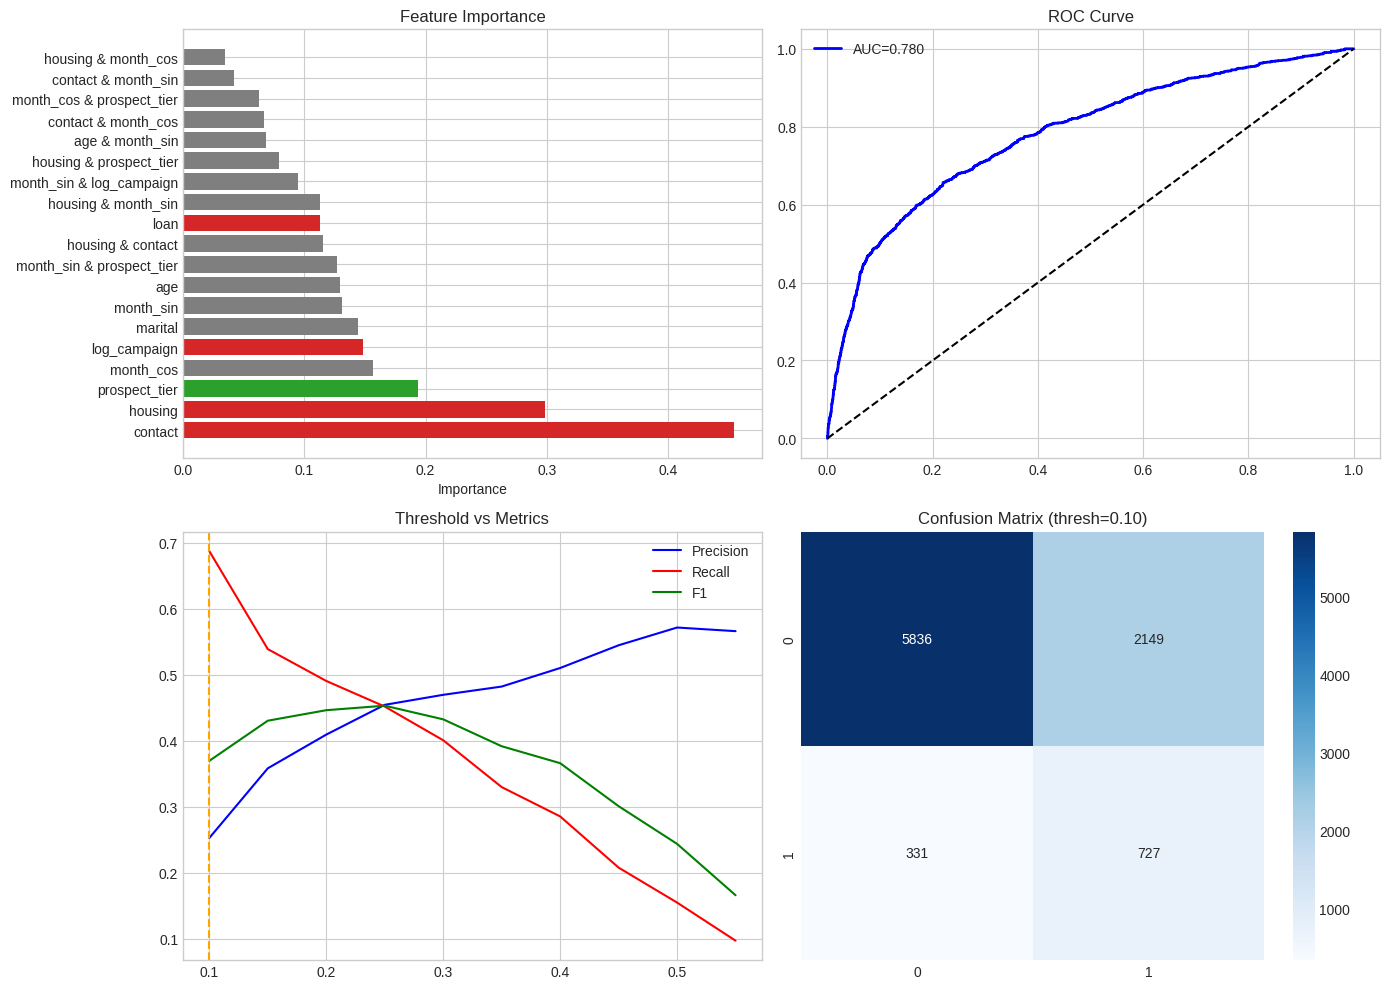


🔍 18.10 QUICK CALIBRATION CHECK
--------------------------------------------------
Brier Score: 0.0863
ECE: 0.0052
✅ ECE acceptable, skipping calibration

💾 18.11 SAVING ARTIFACTS
--------------------------------------------------
✅ Saved to ./models/ebm_ensemble_dict_20260127_000207.joblib

🎯 EBM STAGE 3 COMPLETE (LIGHTENED)

⏱️  TUNING: 12 combinations × 3-fold CV (vs 72 × 5-fold before)
📊 ROC-AUC: 0.7800
🎯 F1: 0.3696 | Recall: 0.6871



In [26]:
# ===================================================================
# CELL 18: STAGE-3 EBM MODEL - LIGHTENED VERSION
# ===================================================================
print("=" * 80)
print("🌳 CELL 18: EBM - LIGHTENED TUNING (Fast Mode)")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
import joblib
import os
import warnings
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve, auc,
                           confusion_matrix, fbeta_score, make_scorer)
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.calibration import calibration_curve
warnings.filterwarnings('ignore')

COLOR_PALETTE = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'positive': '#2ca02c',
    'negative': '#d62728',
    'neutral': '#7f7f7f',
}

plt.style.use('seaborn-v0_8-whitegrid')

# --------------------------------------------------
# 18.1 DATA PREPARATION (GLOBAL SPLIT)
# --------------------------------------------------
print("\n🔧 18.1 DATA PREPARATION")
print("-" * 50)

X_train = GLOBAL_SPLIT['X_train'].copy()
X_test  = GLOBAL_SPLIT['X_test'].copy()
y_train = GLOBAL_SPLIT['y_train'].copy()
y_test  = GLOBAL_SPLIT['y_test'].copy()

train_idx = GLOBAL_SPLIT['train_idx']
test_idx  = GLOBAL_SPLIT['test_idx']

print(f"Train shape: {X_train.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")

# --------------------------------------------------
# 18.2 DROP LEAKY FEATURES
# --------------------------------------------------
print("\n🚫 18.2 DROPPING LEAKY FEATURES")
print("-" * 50)

leaky_features = ['poutcome', 'pdays', 'duration']
leaky_present = [f for f in leaky_features if f in X_train.columns]

if leaky_present:
    print(f"Dropping: {leaky_present}")
    X_train = X_train.drop(columns=leaky_present)
    X_test = X_test.drop(columns=leaky_present)

# --------------------------------------------------
# 18.3 FEATURE ENGINEERING (Same as before)
# --------------------------------------------------
print("\n🔧 18.3 FEATURE ENGINEERING")
print("-" * 50)

features_added = []

# Temporal features
if 'month' in X_train.columns:
    X_train['month_sin'] = np.sin(2 * np.pi * X_train['month'] / 12)
    X_test['month_sin'] = np.sin(2 * np.pi * X_test['month'] / 12)
    X_train['month_cos'] = np.cos(2 * np.pi * X_train['month'] / 12)
    X_test['month_cos'] = np.cos(2 * np.pi * X_test['month'] / 12)
    features_added.extend(['month_sin', 'month_cos'])

# Log campaign
if 'campaign' in X_train.columns:
    X_train['log_campaign'] = np.log1p(X_train['campaign'])
    X_test['log_campaign'] = np.log1p(X_test['campaign'])
    features_added.append('log_campaign')

# Prospect tier
if all(f in X_train.columns for f in ['housing', 'loan', 'balance', 'previous']):
    for df in [X_train, X_test]:
        df['prospect_tier'] = 0
        df.loc[df['previous'] > 0, 'prospect_tier'] = 1
        df.loc[(df['previous'] > 0) & ((df['housing'] == 0) | (df['loan'] == 0)), 'prospect_tier'] = 2
        df.loc[(df['previous'] > 0) & (df['housing'] == 0) & (df['loan'] == 0) & (df['balance'] >= 2500), 'prospect_tier'] = 3
    features_added.append('prospect_tier')

print(f"Features added: {features_added}")

# Drop redundant features
drop_candidates = ['previous', 'month', 'campaign', 'balance', 'day', 'job', 'default', 'education']
drop_present = [f for f in drop_candidates if f in X_train.columns]
X_train = X_train.drop(columns=drop_present)
X_test = X_test.drop(columns=drop_present)

print(f"Final features ({X_train.shape[1]}): {X_train.columns.tolist()}")

# --------------------------------------------------
# 18.4 LIGHTENED HYPERPARAMETER TUNING
# --------------------------------------------------
print("\n🔧 18.4 LIGHTENED HYPERPARAMETER TUNING")
print("-" * 50)

# KEY CHANGES FOR SPEED:
# 1. Use RandomizedSearchCV instead of GridSearchCV
# 2. Reduce CV folds from 5 to 3
# 3. Limit max_rounds to prevent overly long training
# 4. Fewer parameter options

param_distributions = {
    'max_bins': [128, 256],
    'learning_rate': [0.01, 0.02, 0.05],  # Higher LR = faster convergence
    'interactions': [5, 10],
    'min_samples_leaf': [5, 10],  # Fewer options
    'max_leaves': [3],  # Fixed
    'max_rounds': [3000, 5000],  # CRITICAL: Limit iterations
}

n_iter = 12  # Only 12 random combinations instead of 72 grid combinations

print(f"Testing {n_iter} random parameter combinations (3-fold CV)")

ebm_base = ExplainableBoostingClassifier(
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\n🔍 Running RandomizedSearchCV...")
start_time = datetime.now()

random_search = RandomizedSearchCV(
    estimator=ebm_base,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

random_search.fit(X_train, y_train)

elapsed = (datetime.now() - start_time).total_seconds() / 60
print(f"\n✅ Tuning completed in {elapsed:.1f} minutes")
print(f"\n✅ Best parameters:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {random_search.best_score_:.4f}")

ebm_model = random_search.best_estimator_

# --------------------------------------------------
# 18.5 QUICK CV CHECK (5-fold instead of 10)
# --------------------------------------------------
print("\n🔍 18.5 Quick 5-Fold CV Check")
print("-" * 50)

cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_auc = cross_val_score(ebm_model, X_train, y_train, cv=cv_5, scoring='roc_auc', n_jobs=-1)

print(f"5-Fold CV ROC-AUC: {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}")

# --------------------------------------------------
# 18.6 MODEL EVALUATION
# --------------------------------------------------
print("\n📊 18.6 MODEL EVALUATION")
print("-" * 50)

y_pred_proba = ebm_model.predict_proba(X_test)[:, 1]
y_pred = ebm_model.predict(X_test)

metrics_default = {
    'Threshold': 0.5,
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1': f1_score(y_test, y_pred, zero_division=0),
    'F2': fbeta_score(y_test, y_pred, beta=2, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n📊 Performance at Default Threshold (0.5):")
for k, v in metrics_default.items():
    print(f"   {k}: {v:.4f}")

# --------------------------------------------------
# 18.7 THRESHOLD OPTIMIZATION
# --------------------------------------------------
print("\n🎚️ 18.7 THRESHOLD OPTIMIZATION")
print("-" * 50)

thresholds = np.arange(0.1, 0.6, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_t = (y_pred_proba >= thresh).astype(int)
    threshold_results.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t, zero_division=0),
        'f1': f1_score(y_test, y_pred_t, zero_division=0),
        'f2': fbeta_score(y_test, y_pred_t, beta=2, zero_division=0),
    })

threshold_df = pd.DataFrame(threshold_results)
best_f2_idx = threshold_df['f2'].idxmax()
optimal_thresh = threshold_df.loc[best_f2_idx, 'threshold']

y_pred_optimal = (y_pred_proba >= optimal_thresh).astype(int)

metrics_optimal = {
    'Threshold': optimal_thresh,
    'Accuracy': accuracy_score(y_test, y_pred_optimal),
    'Precision': precision_score(y_test, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test, y_pred_optimal, zero_division=0),
    'F1': f1_score(y_test, y_pred_optimal, zero_division=0),
    'F2': fbeta_score(y_test, y_pred_optimal, beta=2, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print(f"\n✅ Optimal Threshold: {optimal_thresh:.2f}")
for k, v in metrics_optimal.items():
    print(f"   {k}: {v:.4f}")

# --------------------------------------------------
# 18.8 FEATURE IMPORTANCE
# --------------------------------------------------
print("\n📊 18.8 FEATURE IMPORTANCE")
print("-" * 50)

# EBM uses term_importances() instead of feature_importances_
try:
    # Method 1: term_importances (preferred for interpret >= 0.3)
    importance_scores = ebm_model.term_importances()
except AttributeError:
    try:
        # Method 2: Older versions might use this
        importance_scores = ebm_model.feature_importances
    except AttributeError:
        # Method 3: Fall back to permutation importance
        print("Using permutation importance (fallback)...")
        from sklearn.inspection import permutation_importance
        perm_imp = permutation_importance(ebm_model, X_test, y_test,
                                          n_repeats=10, random_state=42,
                                          scoring='roc_auc', n_jobs=-1)
        importance_scores = perm_imp.importances_mean

# Get feature names - EBM might include interaction terms
try:
    feature_names = ebm_model.term_names_
except AttributeError:
    feature_names = X_train.columns.tolist()

# Handle case where EBM has more terms than original features (interactions)
if len(importance_scores) != len(X_train.columns):
    print(f"Note: EBM has {len(importance_scores)} terms (includes interactions)")
    feature_importance_ebm = pd.DataFrame({
        'Feature': feature_names[:len(importance_scores)],
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)
else:
    feature_importance_ebm = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)

print(feature_importance_ebm.to_string(index=False))

# --------------------------------------------------
# 18.9 VISUALIZATIONS
# --------------------------------------------------
print("\n📊 18.9 VISUALIZATIONS")
print("-" * 50)

positive_signals = ['prospect_tier']
negative_signals = ['contact', 'housing', 'loan', 'log_campaign']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Feature importance
ax1 = axes[0, 0]
colors = [COLOR_PALETTE['positive'] if f in positive_signals else
          COLOR_PALETTE['negative'] if f in negative_signals else
          COLOR_PALETTE['neutral'] for f in feature_importance_ebm['Feature']]
ax1.barh(feature_importance_ebm['Feature'], feature_importance_ebm['Importance'], color=colors)
ax1.set_xlabel('Importance')
ax1.set_title('Feature Importance')

# ROC Curve
ax2 = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC={metrics_optimal["ROC-AUC"]:.3f}')
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_title('ROC Curve')
ax2.legend()

# Threshold metrics
ax3 = axes[1, 0]
ax3.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision')
ax3.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall')
ax3.plot(threshold_df['threshold'], threshold_df['f1'], 'g-', label='F1')
ax3.axvline(x=optimal_thresh, color='orange', linestyle='--')
ax3.set_title('Threshold vs Metrics')
ax3.legend()

# Confusion matrix
ax4 = axes[1, 1]
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
ax4.set_title(f'Confusion Matrix (thresh={optimal_thresh:.2f})')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 18.10 CALIBRATION CHECK (Simplified)
# --------------------------------------------------
print("\n🔍 18.10 QUICK CALIBRATION CHECK")
print("-" * 50)

from sklearn.metrics import brier_score_loss

def calculate_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        in_bin = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i + 1])
        if in_bin.mean() > 0:
            ece += np.abs(y_true[in_bin].mean() - y_prob[in_bin].mean()) * in_bin.mean()
    return ece

y_test_arr = y_test.values if hasattr(y_test, 'values') else y_test
brier = brier_score_loss(y_test, y_pred_proba)
ece = calculate_ece(y_test_arr, y_pred_proba)

print(f"Brier Score: {brier:.4f}")
print(f"ECE: {ece:.4f}")

# Only calibrate if ECE > 0.05
if ece > 0.05:
    print("\n⚠️ ECE > 0.05, applying light calibration (3-fold)...")
    from sklearn.calibration import CalibratedClassifierCV

    calibrated_ebm = CalibratedClassifierCV(ebm_model, method='isotonic', cv=3, n_jobs=-1)
    calibrated_ebm.fit(X_train, y_train)
    y_pred_proba_cal = calibrated_ebm.predict_proba(X_test)[:, 1]

    brier_cal = brier_score_loss(y_test, y_pred_proba_cal)
    ece_cal = calculate_ece(y_test_arr, y_pred_proba_cal)
    print(f"After calibration - Brier: {brier_cal:.4f}, ECE: {ece_cal:.4f}")
else:
    print("✅ ECE acceptable, skipping calibration")
    calibrated_ebm = None
    y_pred_proba_cal = y_pred_proba

# --------------------------------------------------
# 18.11 SAVE ARTIFACTS
# --------------------------------------------------
print("\n💾 18.11 SAVING ARTIFACTS")
print("-" * 50)

ebm_ensemble_dict = {
    'model': ebm_model,
    'calibrated_model': calibrated_ebm,
    'model_name': 'explainable_boosting_machine',
    'feature_names': X_train.columns.tolist(),
    'best_params': random_search.best_params_,
    'optimal_threshold': optimal_thresh,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'cv_mean_auc': float(cv_scores_auc.mean()),
    'metrics_optimal': metrics_optimal,
    'feature_importance': feature_importance_ebm.to_dict('records'),
    'train_predictions': ebm_model.predict_proba(X_train)[:, 1],
    'test_predictions': y_pred_proba,
    'test_predictions_calibrated': y_pred_proba_cal,
    'train_labels': y_train.values if hasattr(y_train, 'values') else y_train,
    'test_labels': y_test_arr,
    'uncalibrated_metrics': {'brier': brier, 'ece': ece},
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

base_path = "./models"
os.makedirs(base_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

joblib.dump(ebm_ensemble_dict, f"{base_path}/ebm_ensemble_dict_{timestamp}.joblib")
print(f"✅ Saved to {base_path}/ebm_ensemble_dict_{timestamp}.joblib")

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "=" * 80)
print("🎯 EBM STAGE 3 COMPLETE (LIGHTENED)")
print("=" * 80)
print(f"""
⏱️  TUNING: {n_iter} combinations × 3-fold CV (vs 72 × 5-fold before)
📊 ROC-AUC: {metrics_optimal['ROC-AUC']:.4f}
🎯 F1: {metrics_optimal['F1']:.4f} | Recall: {metrics_optimal['Recall']:.4f}
""")


🎯 META-ARBITER — COMPLETE METRICS

📂 1. Loading calibrated predictions...
   LR threshold:  0.0955
   EBM threshold: 0.1000
   Test samples:  9,043

📊 3. Individual Model Performance

   LR (thresh=0.0955)
   Accuracy:  0.6242
   Precision: 0.1994
   Recall:    0.7335
   F1:        0.3135
   F2:        0.4776
   ROC-AUC:   0.7353

   EBM (thresh=0.1000)
   Accuracy:  0.7258
   Precision: 0.2528
   Recall:    0.6871
   F1:        0.3696
   F2:        0.5114
   ROC-AUC:   0.7800

   GLASS (coverage=74.4%)
   Accuracy:  0.6188
   Precision: 0.1904
   Recall:    0.6581
   F1:        0.2953
   F2:        0.4412
   ROC-AUC:   0.6731

📊 5. MODE 1: NO ABSTENTION

   ARBITER (No Abstention) — 100% Coverage
   Accuracy:  0.6697
   Precision: 0.2141
   Recall:    0.6824
   F1:        0.3259
   F2:        0.4747
   ROC-AUC:   0.7572

   Confusion Matrix:
              Pred 0    Pred 1
   Actual 0    5,334     2,651
   Actual 1      336       722

   Decision sources:
   predict_0_2of2: 1,159 (12.

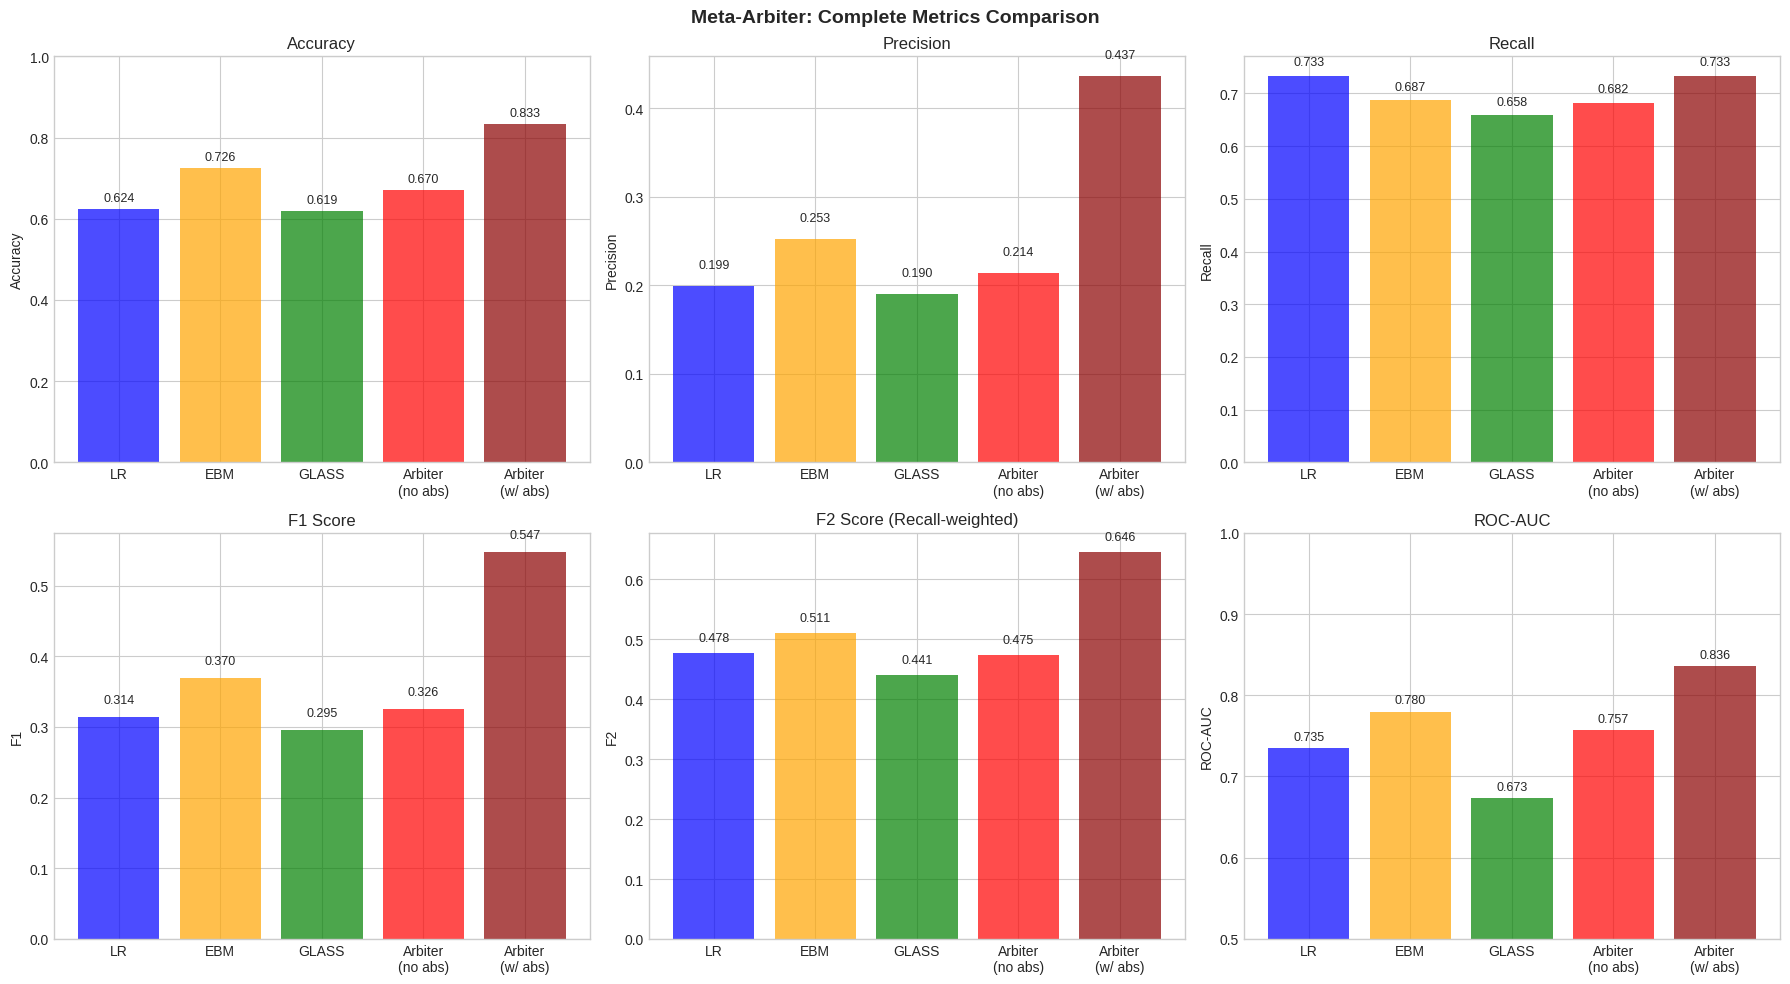


💾 9. Saving...
✅ Saved

🎉 COMPLETE


In [42]:
# ============================================================
# CELL 19: META-ARBITER — COMPLETE METRICS
# ============================================================

print("\n" + "="*80)
print("🎯 META-ARBITER — COMPLETE METRICS")
print("="*80)

import joblib
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score,
    accuracy_score, roc_auc_score, confusion_matrix
)
from datetime import datetime
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. LOAD CALIBRATED DATA
# --------------------------------------------------
print("\n📂 1. Loading calibrated predictions...")

lr_dict = joblib.load("./models/lr_ensemble_calibrated_20260126_231350.joblib")
ebm_dict = joblib.load("./models/ebm_ensemble_dict_20260127_000207.joblib")
glass_bundle = joblib.load("./models/glass_brw_novel_coverage_20260126_233957.joblib")

# Calibrated predictions
lr_prob_train = np.array(lr_dict.get("train_predictions_calibrated", lr_dict["train_predictions"]))
lr_prob_test = np.array(lr_dict.get("test_predictions_calibrated", lr_dict["test_predictions"]))
ebm_prob_train = np.array(ebm_dict.get("train_predictions_calibrated", ebm_dict["train_predictions"]))
ebm_prob_test = np.array(ebm_dict.get("test_predictions_calibrated", ebm_dict["test_predictions"]))

glass_prob_train = glass_bundle["train_proba"][:, 1]
glass_prob_test = glass_bundle["test_proba"][:, 1]
glass_decisions_train = np.array(glass_bundle["train_decisions"])
glass_decisions_test = np.array(glass_bundle["test_decisions"])

y_train = np.array(lr_dict["train_labels"])
y_test = np.array(lr_dict["test_labels"])

# Correct thresholds
LR_THRESH = lr_dict.get("optimal_threshold_calibrated", lr_dict.get("optimal_threshold", 0.0955))
EBM_THRESH = ebm_dict.get("optimal_threshold", 0.10)

# GLASS masks
pass1_train = (glass_decisions_train == "pass1")
pass2_train = (glass_decisions_train == "pass2")
pass1_test = (glass_decisions_test == "pass1")
pass2_test = (glass_decisions_test == "pass2")

print(f"   LR threshold:  {LR_THRESH:.4f}")
print(f"   EBM threshold: {EBM_THRESH:.4f}")
print(f"   Test samples:  {len(y_test):,}")

# --------------------------------------------------
# 2. HELPER: COMPUTE ALL METRICS
# --------------------------------------------------
def compute_all_metrics(y_true, y_pred, y_prob=None):
    """Compute ALL metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
    }
    if y_prob is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    return metrics

def print_metrics(metrics, name=""):
    """Print all metrics"""
    print(f"\n   {name}")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1:        {metrics['f1']:.4f}")
    print(f"   F2:        {metrics['f2']:.4f}")
    if 'roc_auc' in metrics:
        print(f"   ROC-AUC:   {metrics['roc_auc']:.4f}")

# --------------------------------------------------
# 3. INDIVIDUAL MODEL PERFORMANCE
# --------------------------------------------------
print("\n" + "="*80)
print("📊 3. Individual Model Performance")
print("="*80)

lr_pred = (lr_prob_test >= LR_THRESH).astype(int)
ebm_pred = (ebm_prob_test >= EBM_THRESH).astype(int)

glass_pred = np.full(len(y_test), -1)
glass_pred[pass1_test] = 0
glass_pred[pass2_test] = 1
glass_covered = pass1_test | pass2_test

lr_metrics = compute_all_metrics(y_test, lr_pred, lr_prob_test)
ebm_metrics = compute_all_metrics(y_test, ebm_pred, ebm_prob_test)
glass_metrics = compute_all_metrics(y_test[glass_covered], glass_pred[glass_covered], glass_prob_test[glass_covered])

print_metrics(lr_metrics, f"LR (thresh={LR_THRESH:.4f})")
print_metrics(ebm_metrics, f"EBM (thresh={EBM_THRESH:.4f})")
print_metrics(glass_metrics, f"GLASS (coverage={glass_covered.mean():.1%})")

# --------------------------------------------------
# 4. ARBITER FUNCTION
# --------------------------------------------------
def meta_arbiter(
    lr_prob, ebm_prob, glass_prob,
    pass1_mask, pass2_mask,
    lr_thresh, ebm_thresh,
    allow_abstain=False,
    uncertainty_band=0.10
):
    n = len(lr_prob)
    final_pred = np.zeros(n, dtype=int)
    final_prob = np.zeros(n)
    decision_source = [''] * n

    lr_pred = (lr_prob >= lr_thresh).astype(int)
    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)

    lr_conf = np.abs(lr_prob - lr_thresh)
    ebm_conf = np.abs(ebm_prob - ebm_thresh)

    for i in range(n):
        votes = [lr_pred[i], ebm_pred[i]]
        probs = [lr_prob[i], ebm_prob[i]]
        confs = [lr_conf[i], ebm_conf[i]]

        if pass1_mask[i]:
            votes.append(0)
            probs.append(glass_prob[i])
            confs.append(0.5 - glass_prob[i])
        elif pass2_mask[i]:
            votes.append(1)
            probs.append(glass_prob[i])
            confs.append(glass_prob[i] - 0.5)

        votes = np.array(votes)
        probs = np.array(probs)
        confs = np.array(confs)

        vote_1 = (votes == 1).sum()
        vote_0 = (votes == 0).sum()
        n_voters = len(votes)
        avg_prob = probs.mean()

        all_uncertain = np.all(confs < uncertainty_band)

        if allow_abstain:
            if all_uncertain:
                final_pred[i] = -1
                final_prob[i] = avg_prob
                decision_source[i] = 'abstain_all_uncertain'
                continue

            if vote_1 > vote_0:
                confident_1 = np.any((votes == 1) & (confs >= uncertainty_band))
                if confident_1:
                    final_pred[i] = 1
                    final_prob[i] = avg_prob
                    decision_source[i] = f'predict_1_{vote_1}of{n_voters}'
                else:
                    final_pred[i] = -1
                    final_prob[i] = avg_prob
                    decision_source[i] = 'abstain_low_conf'
            elif vote_0 > vote_1:
                confident_0 = np.any((votes == 0) & (confs >= uncertainty_band))
                if confident_0:
                    final_pred[i] = 0
                    final_prob[i] = avg_prob
                    decision_source[i] = f'predict_0_{vote_0}of{n_voters}'
                else:
                    final_pred[i] = -1
                    final_prob[i] = avg_prob
                    decision_source[i] = 'abstain_low_conf'
            else:
                final_pred[i] = -1
                final_prob[i] = avg_prob
                decision_source[i] = 'abstain_tie'
        else:
            if vote_1 > vote_0:
                final_pred[i] = 1
                final_prob[i] = avg_prob
                decision_source[i] = f'predict_1_{vote_1}of{n_voters}'
            elif vote_0 > vote_1:
                final_pred[i] = 0
                final_prob[i] = avg_prob
                decision_source[i] = f'predict_0_{vote_0}of{n_voters}'
            else:
                final_pred[i] = int(avg_prob >= 0.5)
                final_prob[i] = avg_prob
                decision_source[i] = f'predict_{final_pred[i]}_tie'

    return final_pred, final_prob, np.array(decision_source)

# --------------------------------------------------
# 5. NO ABSTENTION MODE
# --------------------------------------------------
print("\n" + "="*80)
print("📊 5. MODE 1: NO ABSTENTION")
print("="*80)

pred_na, prob_na, src_na = meta_arbiter(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    allow_abstain=False
)

metrics_na = compute_all_metrics(y_test, pred_na, prob_na)
print_metrics(metrics_na, "ARBITER (No Abstention) — 100% Coverage")

cm_na = confusion_matrix(y_test, pred_na)
print(f"\n   Confusion Matrix:")
print(f"              Pred 0    Pred 1")
print(f"   Actual 0   {cm_na[0,0]:6,}    {cm_na[0,1]:6,}")
print(f"   Actual 1   {cm_na[1,0]:6,}    {cm_na[1,1]:6,}")

# Decision sources
print(f"\n   Decision sources:")
for src in np.unique(src_na):
    mask = (src_na == src)
    print(f"   {src}: {mask.sum():,} ({mask.mean():.1%})")

# --------------------------------------------------
# 6. WITH ABSTENTION MODE
# --------------------------------------------------
print("\n" + "="*80)
print("📊 6. MODE 2: WITH ABSTENTION")
print("="*80)

# Tune band
best_score = 0
best_band = 0.10
for band in [0.05, 0.08, 0.10, 0.12, 0.15, 0.20]:
    pred, prob, _ = meta_arbiter(
        lr_prob_train, ebm_prob_train, glass_prob_train,
        pass1_train, pass2_train,
        LR_THRESH, EBM_THRESH,
        allow_abstain=True, uncertainty_band=band
    )
    covered = (pred != -1)
    if covered.sum() < 100:
        continue
    f1 = f1_score(y_train[covered], pred[covered])
    score = f1 * np.sqrt(covered.mean())
    if score > best_score:
        best_score = score
        best_band = band

print(f"   Tuned uncertainty_band: {best_band}")

pred_a, prob_a, src_a = meta_arbiter(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    allow_abstain=True, uncertainty_band=best_band
)

covered = (pred_a != -1)
abstained = (pred_a == -1)

metrics_a = compute_all_metrics(y_test[covered], pred_a[covered], prob_a[covered])

print(f"\n   Coverage:  {covered.mean():.1%}")
print(f"   Abstained: {abstained.mean():.1%}")
print_metrics(metrics_a, "ARBITER (With Abstention) — On Covered Only")

cm_a = confusion_matrix(y_test[covered], pred_a[covered])
print(f"\n   Confusion Matrix (covered only):")
print(f"              Pred 0    Pred 1")
print(f"   Actual 0   {cm_a[0,0]:6,}    {cm_a[0,1]:6,}")
print(f"   Actual 1   {cm_a[1,0]:6,}    {cm_a[1,1]:6,}")

# Subscriber fate
total_subs = y_test.sum()
detected_a = ((pred_a == 1) & (y_test == 1)).sum()
missed_a = ((pred_a == 0) & (y_test == 1)).sum()
abstain_subs = ((pred_a == -1) & (y_test == 1)).sum()

print(f"\n   Subscriber fate:")
print(f"   Detected (TP):   {detected_a} ({detected_a/total_subs:.1%})")
print(f"   Missed (FN):     {missed_a} ({missed_a/total_subs:.1%})")
print(f"   In abstain:      {abstain_subs} ({abstain_subs/total_subs:.1%})")

# Decision sources
print(f"\n   Decision sources:")
for src in np.unique(src_a):
    mask = (src_a == src)
    n_subs = (y_test[mask] == 1).sum()
    print(f"   {src}: {mask.sum():,} ({mask.mean():.1%}) — {n_subs} subs")

# --------------------------------------------------
# 7. FINAL COMPARISON TABLE
# --------------------------------------------------
print("\n" + "="*80)
print("📊 7. FINAL COMPARISON — ALL METRICS")
print("="*80)

print(f"\n{'Model':<22} {'Cov':>6} {'Acc':>7} {'Prec':>7} {'Rec':>7} {'F1':>7} {'F2':>7} {'AUC':>7}")
print("-" * 80)

print(f"{'LR':<22} {'100%':>6} "
      f"{lr_metrics['accuracy']:>7.3f} {lr_metrics['precision']:>7.3f} "
      f"{lr_metrics['recall']:>7.3f} {lr_metrics['f1']:>7.3f} "
      f"{lr_metrics['f2']:>7.3f} {lr_metrics['roc_auc']:>7.3f}")

print(f"{'EBM':<22} {'100%':>6} "
      f"{ebm_metrics['accuracy']:>7.3f} {ebm_metrics['precision']:>7.3f} "
      f"{ebm_metrics['recall']:>7.3f} {ebm_metrics['f1']:>7.3f} "
      f"{ebm_metrics['f2']:>7.3f} {ebm_metrics['roc_auc']:>7.3f}")

print(f"{'GLASS':<22} {glass_covered.mean():>6.1%} "
      f"{glass_metrics['accuracy']:>7.3f} {glass_metrics['precision']:>7.3f} "
      f"{glass_metrics['recall']:>7.3f} {glass_metrics['f1']:>7.3f} "
      f"{glass_metrics['f2']:>7.3f} {glass_metrics['roc_auc']:>7.3f}")

print(f"{'ARBITER (no abstain)':<22} {'100%':>6} "
      f"{metrics_na['accuracy']:>7.3f} {metrics_na['precision']:>7.3f} "
      f"{metrics_na['recall']:>7.3f} {metrics_na['f1']:>7.3f} "
      f"{metrics_na['f2']:>7.3f} {metrics_na['roc_auc']:>7.3f}")

print(f"{'ARBITER (w/ abstain)':<22} {covered.mean():>6.1%} "
      f"{metrics_a['accuracy']:>7.3f} {metrics_a['precision']:>7.3f} "
      f"{metrics_a['recall']:>7.3f} {metrics_a['f1']:>7.3f} "
      f"{metrics_a['f2']:>7.3f} {metrics_a['roc_auc']:>7.3f}")

# --------------------------------------------------
# 8. VISUALIZE
# --------------------------------------------------
print("\n📊 8. Visualizing...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models = ['LR', 'EBM', 'GLASS', 'Arbiter\n(no abs)', 'Arbiter\n(w/ abs)']
colors = ['blue', 'orange', 'green', 'red', 'darkred']

# Accuracy
ax = axes[0, 0]
vals = [lr_metrics['accuracy'], ebm_metrics['accuracy'], glass_metrics['accuracy'],
        metrics_na['accuracy'], metrics_a['accuracy']]
ax.bar(models, vals, color=colors, alpha=0.7)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')
ax.set_ylim(0, 1)
for i, v in enumerate(vals):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# Precision
ax = axes[0, 1]
vals = [lr_metrics['precision'], ebm_metrics['precision'], glass_metrics['precision'],
        metrics_na['precision'], metrics_a['precision']]
ax.bar(models, vals, color=colors, alpha=0.7)
ax.set_ylabel('Precision')
ax.set_title('Precision')
for i, v in enumerate(vals):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# Recall
ax = axes[0, 2]
vals = [lr_metrics['recall'], ebm_metrics['recall'], glass_metrics['recall'],
        metrics_na['recall'], metrics_a['recall']]
ax.bar(models, vals, color=colors, alpha=0.7)
ax.set_ylabel('Recall')
ax.set_title('Recall')
for i, v in enumerate(vals):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# F1
ax = axes[1, 0]
vals = [lr_metrics['f1'], ebm_metrics['f1'], glass_metrics['f1'],
        metrics_na['f1'], metrics_a['f1']]
ax.bar(models, vals, color=colors, alpha=0.7)
ax.set_ylabel('F1')
ax.set_title('F1 Score')
for i, v in enumerate(vals):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# F2
ax = axes[1, 1]
vals = [lr_metrics['f2'], ebm_metrics['f2'], glass_metrics['f2'],
        metrics_na['f2'], metrics_a['f2']]
ax.bar(models, vals, color=colors, alpha=0.7)
ax.set_ylabel('F2')
ax.set_title('F2 Score (Recall-weighted)')
for i, v in enumerate(vals):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# ROC-AUC
ax = axes[1, 2]
vals = [lr_metrics['roc_auc'], ebm_metrics['roc_auc'], glass_metrics['roc_auc'],
        metrics_na['roc_auc'], metrics_a['roc_auc']]
ax.bar(models, vals, color=colors, alpha=0.7)
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC')
ax.set_ylim(0.5, 1)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.suptitle('Meta-Arbiter: Complete Metrics Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 9. SAVE
# --------------------------------------------------
print("\n💾 9. Saving...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump({
    'lr_thresh': LR_THRESH,
    'ebm_thresh': EBM_THRESH,
    'uncertainty_band': best_band,
    'individual_models': {
        'lr': lr_metrics,
        'ebm': ebm_metrics,
        'glass': glass_metrics
    },
    'no_abstain': metrics_na,
    'with_abstain': {
        'coverage': covered.mean(),
        'metrics': metrics_a,
        'abstain_rate': abstained.mean()
    },
    'predictions': {
        'no_abstain': pred_na,
        'with_abstain': pred_a,
        'probabilities': prob_na
    }
}, f"./models/meta_arbiter_complete_{timestamp}.joblib")
print(f"✅ Saved")

print("\n" + "="*80)
print("🎉 COMPLETE")
print("="*80)